In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [8]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    ############################################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * dones
    targetQs = rewards + (gamma * nextQs)
    aloss3 = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, aloss, dloss, aloss2, aloss3

In [9]:
def model_opt(a_loss, a_loss2, a_loss3, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
        a_opt3 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss3, var_list=a_vars)
    return a_opt, d_opt, a_opt2, a_opt3

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2, self.a_loss3 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2, self.a_opt3 = model_opt(a_loss=self.a_loss, 
                                                                     a_loss2=self.a_loss2, 
                                                                     a_loss3=self.a_loss3, 
                                                                     d_loss=self.d_loss,
                                                                     a_learning_rate=a_learning_rate,
                                                                     d_learning_rate=d_learning_rate)

In [19]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [20]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [22]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [24]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch, aloss3_batch = [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.sample(batch_size=batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss3, _ = sess.run([model.a_loss3, model.a_opt3], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            aloss3_batch.append(aloss3)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'aloss3:{:.4f}'.format(np.mean(aloss3_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 R:10.0000 rate:0.0200 aloss:1.5056 dloss:0.7783 aloss2:0.6052 aloss3:0.7509 exploreP:0.9990
Episode:1 meanR:10.5000 R:11.0000 rate:0.0220 aloss:1.4675 dloss:0.7766 aloss2:0.6144 aloss3:0.7380 exploreP:0.9979
Episode:2 meanR:17.6667 R:32.0000 rate:0.0640 aloss:1.4669 dloss:0.7650 aloss2:0.6262 aloss3:0.7869 exploreP:0.9948
Episode:3 meanR:17.2500 R:16.0000 rate:0.0320 aloss:1.4468 dloss:0.7549 aloss2:0.6410 aloss3:0.8149 exploreP:0.9932
Episode:4 meanR:17.6000 R:19.0000 rate:0.0380 aloss:1.4603 dloss:0.7423 aloss2:0.6494 aloss3:0.8669 exploreP:0.9913
Episode:5 meanR:18.1667 R:21.0000 rate:0.0420 aloss:1.4494 dloss:0.7381 aloss2:0.6625 aloss3:0.8769 exploreP:0.9893
Episode:6 meanR:17.2857 R:12.0000 rate:0.0240 aloss:1.4388 dloss:0.7278 aloss2:0.6684 aloss3:0.9126 exploreP:0.9881
Episode:7 meanR:17.2500 R:17.0000 rate:0.0340 aloss:1.4443 dloss:0.7189 aloss2:0.6742 aloss3:0.9498 exploreP:0.9864
Episode:8 meanR:19.2222 R:35.0000 rate:0.0700 aloss:1.4377 dloss:0.7081 

Episode:71 meanR:25.3889 R:37.0000 rate:0.0740 aloss:1.3967 dloss:0.2617 aloss2:1.6603 aloss3:8.6070 exploreP:0.8346
Episode:72 meanR:25.2192 R:13.0000 rate:0.0260 aloss:1.3930 dloss:0.2612 aloss2:1.6758 aloss3:8.7468 exploreP:0.8335
Episode:73 meanR:25.0541 R:13.0000 rate:0.0260 aloss:1.3942 dloss:0.2638 aloss2:1.6564 aloss3:8.6647 exploreP:0.8325
Episode:74 meanR:24.8800 R:12.0000 rate:0.0240 aloss:1.3990 dloss:0.2630 aloss2:1.6783 aloss3:8.7524 exploreP:0.8315
Episode:75 meanR:24.6711 R:9.0000 rate:0.0180 aloss:1.4001 dloss:0.2585 aloss2:1.6846 aloss3:9.0229 exploreP:0.8307
Episode:76 meanR:24.5844 R:18.0000 rate:0.0360 aloss:1.4016 dloss:0.2564 aloss2:1.7052 aloss3:9.1540 exploreP:0.8293
Episode:77 meanR:24.5256 R:20.0000 rate:0.0400 aloss:1.3991 dloss:0.2580 aloss2:1.6970 aloss3:9.0807 exploreP:0.8276
Episode:78 meanR:24.3291 R:9.0000 rate:0.0180 aloss:1.4029 dloss:0.2502 aloss2:1.7285 aloss3:9.3887 exploreP:0.8269
Episode:79 meanR:24.3625 R:27.0000 rate:0.0540 aloss:1.3989 dloss:

Episode:141 meanR:20.4000 R:11.0000 rate:0.0220 aloss:1.3903 dloss:0.2220 aloss2:2.0277 aloss3:13.5557 exploreP:0.7303
Episode:142 meanR:20.4300 R:18.0000 rate:0.0360 aloss:1.3938 dloss:0.2199 aloss2:2.0390 aloss3:13.7017 exploreP:0.7290
Episode:143 meanR:20.6600 R:46.0000 rate:0.0920 aloss:1.3935 dloss:0.2222 aloss2:2.0343 aloss3:13.7455 exploreP:0.7257
Episode:144 meanR:20.6800 R:22.0000 rate:0.0440 aloss:1.3938 dloss:0.2208 aloss2:2.0317 aloss3:13.6778 exploreP:0.7242
Episode:145 meanR:20.8500 R:26.0000 rate:0.0520 aloss:1.3903 dloss:0.2218 aloss2:2.0288 aloss3:13.6903 exploreP:0.7223
Episode:146 meanR:20.9000 R:16.0000 rate:0.0320 aloss:1.3935 dloss:0.2243 aloss2:2.0290 aloss3:13.7353 exploreP:0.7212
Episode:147 meanR:20.9100 R:15.0000 rate:0.0300 aloss:1.3925 dloss:0.2144 aloss2:2.0344 aloss3:13.6874 exploreP:0.7201
Episode:148 meanR:20.7200 R:13.0000 rate:0.0260 aloss:1.3918 dloss:0.2228 aloss2:2.0286 aloss3:13.6832 exploreP:0.7192
Episode:149 meanR:20.7400 R:12.0000 rate:0.0240 

Episode:210 meanR:17.5600 R:11.0000 rate:0.0220 aloss:1.3900 dloss:0.2185 aloss2:1.9974 aloss3:14.0184 exploreP:0.6502
Episode:211 meanR:17.2900 R:18.0000 rate:0.0360 aloss:1.3893 dloss:0.2213 aloss2:2.0006 aloss3:14.0263 exploreP:0.6491
Episode:212 meanR:17.2700 R:18.0000 rate:0.0360 aloss:1.3898 dloss:0.2131 aloss2:1.9990 aloss3:14.0046 exploreP:0.6479
Episode:213 meanR:17.2200 R:10.0000 rate:0.0200 aloss:1.3908 dloss:0.2181 aloss2:2.0009 aloss3:13.9180 exploreP:0.6473
Episode:214 meanR:17.2300 R:12.0000 rate:0.0240 aloss:1.3923 dloss:0.2185 aloss2:2.0049 aloss3:14.0939 exploreP:0.6465
Episode:215 meanR:17.2000 R:12.0000 rate:0.0240 aloss:1.3933 dloss:0.2167 aloss2:2.0044 aloss3:14.0747 exploreP:0.6457
Episode:216 meanR:16.9100 R:13.0000 rate:0.0260 aloss:1.3898 dloss:0.2218 aloss2:2.0005 aloss3:14.1576 exploreP:0.6449
Episode:217 meanR:16.9900 R:17.0000 rate:0.0340 aloss:1.3910 dloss:0.2171 aloss2:1.9979 aloss3:14.0363 exploreP:0.6438
Episode:218 meanR:16.9800 R:12.0000 rate:0.0240 

Episode:280 meanR:15.0400 R:12.0000 rate:0.0240 aloss:1.3916 dloss:0.2148 aloss2:1.9892 aloss3:14.0412 exploreP:0.5861
Episode:281 meanR:15.0500 R:12.0000 rate:0.0240 aloss:1.3914 dloss:0.2179 aloss2:1.9859 aloss3:14.2090 exploreP:0.5854
Episode:282 meanR:15.0600 R:12.0000 rate:0.0240 aloss:1.3908 dloss:0.2195 aloss2:1.9874 aloss3:14.1322 exploreP:0.5847
Episode:283 meanR:14.8600 R:16.0000 rate:0.0320 aloss:1.3905 dloss:0.2145 aloss2:1.9807 aloss3:14.2054 exploreP:0.5838
Episode:284 meanR:14.8900 R:18.0000 rate:0.0360 aloss:1.3887 dloss:0.2193 aloss2:1.9808 aloss3:14.2227 exploreP:0.5827
Episode:285 meanR:14.8700 R:11.0000 rate:0.0220 aloss:1.3908 dloss:0.2181 aloss2:1.9808 aloss3:14.1915 exploreP:0.5821
Episode:286 meanR:14.9200 R:16.0000 rate:0.0320 aloss:1.3897 dloss:0.2153 aloss2:1.9775 aloss3:14.1705 exploreP:0.5812
Episode:287 meanR:14.9200 R:16.0000 rate:0.0320 aloss:1.3900 dloss:0.2180 aloss2:1.9801 aloss3:14.0765 exploreP:0.5803
Episode:288 meanR:14.9100 R:13.0000 rate:0.0260 

Episode:349 meanR:14.6500 R:9.0000 rate:0.0180 aloss:1.3878 dloss:0.2130 aloss2:1.9563 aloss3:14.2379 exploreP:0.5330
Episode:350 meanR:14.5300 R:13.0000 rate:0.0260 aloss:1.3897 dloss:0.2151 aloss2:1.9577 aloss3:14.1493 exploreP:0.5323
Episode:351 meanR:14.3500 R:16.0000 rate:0.0320 aloss:1.3906 dloss:0.2128 aloss2:1.9658 aloss3:14.2384 exploreP:0.5315
Episode:352 meanR:14.3600 R:14.0000 rate:0.0280 aloss:1.3901 dloss:0.2121 aloss2:1.9653 aloss3:14.2664 exploreP:0.5308
Episode:353 meanR:14.3800 R:15.0000 rate:0.0300 aloss:1.3902 dloss:0.2168 aloss2:1.9541 aloss3:14.2474 exploreP:0.5300
Episode:354 meanR:14.3500 R:13.0000 rate:0.0260 aloss:1.3876 dloss:0.2143 aloss2:1.9591 aloss3:14.3425 exploreP:0.5293
Episode:355 meanR:14.3700 R:18.0000 rate:0.0360 aloss:1.3898 dloss:0.2157 aloss2:1.9597 aloss3:14.2482 exploreP:0.5284
Episode:356 meanR:14.3500 R:14.0000 rate:0.0280 aloss:1.3908 dloss:0.2156 aloss2:1.9553 aloss3:14.2223 exploreP:0.5277
Episode:357 meanR:14.3100 R:11.0000 rate:0.0220 a

Episode:419 meanR:12.9100 R:10.0000 rate:0.0200 aloss:1.3892 dloss:0.2148 aloss2:1.9448 aloss3:14.0515 exploreP:0.4881
Episode:420 meanR:12.9000 R:13.0000 rate:0.0260 aloss:1.3880 dloss:0.2131 aloss2:1.9317 aloss3:14.3133 exploreP:0.4875
Episode:421 meanR:12.9200 R:12.0000 rate:0.0240 aloss:1.3890 dloss:0.2196 aloss2:1.9407 aloss3:14.2055 exploreP:0.4869
Episode:422 meanR:12.9100 R:9.0000 rate:0.0180 aloss:1.3872 dloss:0.2141 aloss2:1.9499 aloss3:14.2347 exploreP:0.4865
Episode:423 meanR:12.8800 R:10.0000 rate:0.0200 aloss:1.3889 dloss:0.2177 aloss2:1.9403 aloss3:14.2437 exploreP:0.4860
Episode:424 meanR:12.8400 R:9.0000 rate:0.0180 aloss:1.3874 dloss:0.2138 aloss2:1.9454 aloss3:14.2203 exploreP:0.4856
Episode:425 meanR:12.8800 R:13.0000 rate:0.0260 aloss:1.3861 dloss:0.2107 aloss2:1.9312 aloss3:14.2292 exploreP:0.4849
Episode:426 meanR:12.8100 R:12.0000 rate:0.0240 aloss:1.3873 dloss:0.2166 aloss2:1.9338 aloss3:14.2668 exploreP:0.4844
Episode:427 meanR:12.8200 R:11.0000 rate:0.0220 al

Episode:488 meanR:12.8200 R:12.0000 rate:0.0240 aloss:1.3889 dloss:0.2080 aloss2:1.9482 aloss3:14.1855 exploreP:0.4479
Episode:489 meanR:12.7700 R:12.0000 rate:0.0240 aloss:1.3843 dloss:0.2080 aloss2:1.9363 aloss3:14.4004 exploreP:0.4474
Episode:490 meanR:12.7800 R:11.0000 rate:0.0220 aloss:1.3881 dloss:0.2149 aloss2:1.9433 aloss3:14.4011 exploreP:0.4469
Episode:491 meanR:12.8000 R:14.0000 rate:0.0280 aloss:1.3885 dloss:0.2150 aloss2:1.9461 aloss3:14.2353 exploreP:0.4463
Episode:492 meanR:12.7900 R:12.0000 rate:0.0240 aloss:1.3879 dloss:0.2147 aloss2:1.9428 aloss3:14.2495 exploreP:0.4458
Episode:493 meanR:12.8100 R:16.0000 rate:0.0320 aloss:1.3906 dloss:0.2113 aloss2:1.9524 aloss3:14.2935 exploreP:0.4451
Episode:494 meanR:12.8000 R:9.0000 rate:0.0180 aloss:1.3870 dloss:0.2135 aloss2:1.9526 aloss3:14.3835 exploreP:0.4447
Episode:495 meanR:12.8400 R:15.0000 rate:0.0300 aloss:1.3880 dloss:0.2118 aloss2:1.9479 aloss3:14.3905 exploreP:0.4440
Episode:496 meanR:12.8400 R:11.0000 rate:0.0220 a

Episode:557 meanR:12.7300 R:16.0000 rate:0.0320 aloss:1.3889 dloss:0.2125 aloss2:1.9631 aloss3:14.4205 exploreP:0.4111
Episode:558 meanR:12.6900 R:10.0000 rate:0.0200 aloss:1.3882 dloss:0.2112 aloss2:1.9577 aloss3:14.4956 exploreP:0.4107
Episode:559 meanR:12.6300 R:12.0000 rate:0.0240 aloss:1.3887 dloss:0.2151 aloss2:1.9621 aloss3:14.4469 exploreP:0.4102
Episode:560 meanR:12.6600 R:14.0000 rate:0.0280 aloss:1.3884 dloss:0.2117 aloss2:1.9528 aloss3:14.3599 exploreP:0.4097
Episode:561 meanR:12.6900 R:14.0000 rate:0.0280 aloss:1.3887 dloss:0.2176 aloss2:1.9628 aloss3:14.2363 exploreP:0.4091
Episode:562 meanR:12.6700 R:12.0000 rate:0.0240 aloss:1.3850 dloss:0.2131 aloss2:1.9618 aloss3:14.2559 exploreP:0.4086
Episode:563 meanR:12.6300 R:10.0000 rate:0.0200 aloss:1.3858 dloss:0.2141 aloss2:1.9346 aloss3:14.3169 exploreP:0.4082
Episode:564 meanR:12.5800 R:10.0000 rate:0.0200 aloss:1.3877 dloss:0.2124 aloss2:1.9578 aloss3:14.2701 exploreP:0.4078
Episode:565 meanR:12.5700 R:11.0000 rate:0.0220 

Episode:626 meanR:12.5200 R:12.0000 rate:0.0240 aloss:1.3878 dloss:0.2098 aloss2:1.9478 aloss3:14.3718 exploreP:0.3784
Episode:627 meanR:12.4300 R:11.0000 rate:0.0220 aloss:1.3876 dloss:0.2156 aloss2:1.9746 aloss3:14.3326 exploreP:0.3780
Episode:628 meanR:12.4400 R:13.0000 rate:0.0260 aloss:1.3859 dloss:0.2114 aloss2:1.9302 aloss3:14.3405 exploreP:0.3775
Episode:629 meanR:12.3900 R:9.0000 rate:0.0180 aloss:1.3898 dloss:0.2186 aloss2:1.9697 aloss3:14.3510 exploreP:0.3772
Episode:630 meanR:12.3800 R:10.0000 rate:0.0200 aloss:1.3900 dloss:0.2136 aloss2:1.9322 aloss3:14.3745 exploreP:0.3768
Episode:631 meanR:12.4100 R:14.0000 rate:0.0280 aloss:1.3867 dloss:0.2102 aloss2:1.9358 aloss3:14.2440 exploreP:0.3763
Episode:632 meanR:12.4200 R:13.0000 rate:0.0260 aloss:1.3853 dloss:0.2125 aloss2:1.9612 aloss3:14.2361 exploreP:0.3758
Episode:633 meanR:12.3700 R:12.0000 rate:0.0240 aloss:1.3909 dloss:0.2141 aloss2:1.9693 aloss3:14.3579 exploreP:0.3754
Episode:634 meanR:12.2800 R:11.0000 rate:0.0220 a

Episode:696 meanR:11.7800 R:11.0000 rate:0.0220 aloss:1.3878 dloss:0.2089 aloss2:1.9753 aloss3:14.4031 exploreP:0.3496
Episode:697 meanR:11.8000 R:11.0000 rate:0.0220 aloss:1.3849 dloss:0.2126 aloss2:1.9733 aloss3:14.4331 exploreP:0.3492
Episode:698 meanR:11.8000 R:12.0000 rate:0.0240 aloss:1.3864 dloss:0.2079 aloss2:1.9650 aloss3:14.3382 exploreP:0.3488
Episode:699 meanR:11.8000 R:11.0000 rate:0.0220 aloss:1.3877 dloss:0.2121 aloss2:1.9538 aloss3:14.5734 exploreP:0.3484
Episode:700 meanR:11.7500 R:9.0000 rate:0.0180 aloss:1.3891 dloss:0.2083 aloss2:1.9635 aloss3:14.3807 exploreP:0.3481
Episode:701 meanR:11.6900 R:9.0000 rate:0.0180 aloss:1.3901 dloss:0.2163 aloss2:1.9581 aloss3:14.5173 exploreP:0.3478
Episode:702 meanR:11.6500 R:9.0000 rate:0.0180 aloss:1.3900 dloss:0.2059 aloss2:1.9664 aloss3:14.4140 exploreP:0.3475
Episode:703 meanR:11.6300 R:11.0000 rate:0.0220 aloss:1.3880 dloss:0.2111 aloss2:1.9746 aloss3:14.4370 exploreP:0.3471
Episode:704 meanR:11.6000 R:11.0000 rate:0.0220 alo

Episode:765 meanR:11.5700 R:19.0000 rate:0.0380 aloss:1.3873 dloss:0.2092 aloss2:1.9757 aloss3:14.3933 exploreP:0.3234
Episode:766 meanR:11.6000 R:13.0000 rate:0.0260 aloss:1.3864 dloss:0.2086 aloss2:1.9855 aloss3:14.5259 exploreP:0.3230
Episode:767 meanR:11.5700 R:9.0000 rate:0.0180 aloss:1.3903 dloss:0.2108 aloss2:1.9902 aloss3:14.4071 exploreP:0.3227
Episode:768 meanR:11.5400 R:11.0000 rate:0.0220 aloss:1.3887 dloss:0.2126 aloss2:1.9903 aloss3:14.5771 exploreP:0.3224
Episode:769 meanR:11.5500 R:14.0000 rate:0.0280 aloss:1.3868 dloss:0.2090 aloss2:1.9772 aloss3:14.4537 exploreP:0.3219
Episode:770 meanR:11.5700 R:13.0000 rate:0.0260 aloss:1.3884 dloss:0.2041 aloss2:1.9803 aloss3:14.3844 exploreP:0.3215
Episode:771 meanR:11.6000 R:14.0000 rate:0.0280 aloss:1.3879 dloss:0.2129 aloss2:1.9847 aloss3:14.4348 exploreP:0.3211
Episode:772 meanR:11.5800 R:9.0000 rate:0.0180 aloss:1.3855 dloss:0.2131 aloss2:1.9824 aloss3:14.5015 exploreP:0.3208
Episode:773 meanR:11.5000 R:11.0000 rate:0.0220 al

Episode:835 meanR:11.5700 R:10.0000 rate:0.0200 aloss:1.3882 dloss:0.2035 aloss2:1.9971 aloss3:14.4630 exploreP:0.2995
Episode:836 meanR:11.5100 R:9.0000 rate:0.0180 aloss:1.3856 dloss:0.2072 aloss2:1.9955 aloss3:14.5121 exploreP:0.2992
Episode:837 meanR:11.5300 R:12.0000 rate:0.0240 aloss:1.3873 dloss:0.2118 aloss2:2.0099 aloss3:14.5033 exploreP:0.2989
Episode:838 meanR:11.5400 R:13.0000 rate:0.0260 aloss:1.3830 dloss:0.2108 aloss2:1.9919 aloss3:14.5970 exploreP:0.2985
Episode:839 meanR:11.4700 R:9.0000 rate:0.0180 aloss:1.3863 dloss:0.2117 aloss2:1.9831 aloss3:14.5354 exploreP:0.2982
Episode:840 meanR:11.4500 R:10.0000 rate:0.0200 aloss:1.3894 dloss:0.2074 aloss2:2.0076 aloss3:14.5557 exploreP:0.2980
Episode:841 meanR:11.4500 R:11.0000 rate:0.0220 aloss:1.3873 dloss:0.2094 aloss2:1.9835 aloss3:14.5969 exploreP:0.2976
Episode:842 meanR:11.4300 R:12.0000 rate:0.0240 aloss:1.3871 dloss:0.2061 aloss2:2.0095 aloss3:14.5335 exploreP:0.2973
Episode:843 meanR:11.4400 R:11.0000 rate:0.0220 al

Episode:904 meanR:11.6600 R:10.0000 rate:0.0200 aloss:1.3828 dloss:0.2065 aloss2:2.0364 aloss3:14.6919 exploreP:0.2768
Episode:905 meanR:11.6400 R:9.0000 rate:0.0180 aloss:1.3856 dloss:0.2087 aloss2:2.0183 aloss3:14.6115 exploreP:0.2765
Episode:906 meanR:11.6600 R:11.0000 rate:0.0220 aloss:1.3883 dloss:0.2001 aloss2:2.0194 aloss3:14.5699 exploreP:0.2762
Episode:907 meanR:11.6200 R:11.0000 rate:0.0220 aloss:1.3870 dloss:0.2124 aloss2:2.0227 aloss3:14.6545 exploreP:0.2759
Episode:908 meanR:11.6700 R:16.0000 rate:0.0320 aloss:1.3875 dloss:0.2062 aloss2:2.0255 aloss3:14.6470 exploreP:0.2755
Episode:909 meanR:11.7000 R:13.0000 rate:0.0260 aloss:1.3848 dloss:0.2088 aloss2:2.0299 aloss3:14.5609 exploreP:0.2752
Episode:910 meanR:11.7200 R:14.0000 rate:0.0280 aloss:1.3858 dloss:0.2031 aloss2:2.0136 aloss3:14.6579 exploreP:0.2748
Episode:911 meanR:11.7300 R:11.0000 rate:0.0220 aloss:1.3868 dloss:0.2063 aloss2:2.0006 aloss3:14.7165 exploreP:0.2745
Episode:912 meanR:11.7400 R:11.0000 rate:0.0220 a

Episode:974 meanR:11.7600 R:14.0000 rate:0.0280 aloss:1.3843 dloss:0.2016 aloss2:2.0346 aloss3:14.7045 exploreP:0.2555
Episode:975 meanR:11.7800 R:13.0000 rate:0.0260 aloss:1.3821 dloss:0.2047 aloss2:2.0599 aloss3:14.5949 exploreP:0.2551
Episode:976 meanR:11.7900 R:10.0000 rate:0.0200 aloss:1.3832 dloss:0.2079 aloss2:2.0334 aloss3:14.7820 exploreP:0.2549
Episode:977 meanR:11.7800 R:10.0000 rate:0.0200 aloss:1.3843 dloss:0.2088 aloss2:2.0599 aloss3:14.7215 exploreP:0.2546
Episode:978 meanR:11.8300 R:14.0000 rate:0.0280 aloss:1.3843 dloss:0.2023 aloss2:2.0569 aloss3:14.7104 exploreP:0.2543
Episode:979 meanR:11.8500 R:13.0000 rate:0.0260 aloss:1.3864 dloss:0.2076 aloss2:2.0621 aloss3:14.7637 exploreP:0.2540
Episode:980 meanR:11.8500 R:12.0000 rate:0.0240 aloss:1.3841 dloss:0.2067 aloss2:2.0664 aloss3:14.7393 exploreP:0.2537
Episode:981 meanR:11.8900 R:15.0000 rate:0.0300 aloss:1.3836 dloss:0.2080 aloss2:2.0297 aloss3:14.7450 exploreP:0.2533
Episode:982 meanR:11.8900 R:11.0000 rate:0.0220 

Episode:1044 meanR:13.0100 R:16.0000 rate:0.0320 aloss:1.3829 dloss:0.1997 aloss2:2.0483 aloss3:14.6765 exploreP:0.2340
Episode:1045 meanR:13.0300 R:12.0000 rate:0.0240 aloss:1.3822 dloss:0.2070 aloss2:2.0378 aloss3:14.8496 exploreP:0.2338
Episode:1046 meanR:13.0500 R:12.0000 rate:0.0240 aloss:1.3813 dloss:0.2089 aloss2:2.0353 aloss3:14.7263 exploreP:0.2335
Episode:1047 meanR:13.0100 R:10.0000 rate:0.0200 aloss:1.3835 dloss:0.2056 aloss2:2.0290 aloss3:14.8877 exploreP:0.2333
Episode:1048 meanR:12.9500 R:10.0000 rate:0.0200 aloss:1.3805 dloss:0.2080 aloss2:2.0353 aloss3:14.6522 exploreP:0.2331
Episode:1049 meanR:12.9200 R:10.0000 rate:0.0200 aloss:1.3789 dloss:0.2063 aloss2:2.0387 aloss3:14.6647 exploreP:0.2328
Episode:1050 meanR:12.9200 R:13.0000 rate:0.0260 aloss:1.3841 dloss:0.2070 aloss2:2.0321 aloss3:14.7076 exploreP:0.2325
Episode:1051 meanR:12.8900 R:14.0000 rate:0.0280 aloss:1.3812 dloss:0.2032 aloss2:2.0134 aloss3:14.7803 exploreP:0.2322
Episode:1052 meanR:12.8800 R:11.0000 rat

Episode:1113 meanR:12.0700 R:10.0000 rate:0.0200 aloss:1.3830 dloss:0.2083 aloss2:2.0422 aloss3:14.5619 exploreP:0.2165
Episode:1114 meanR:12.0600 R:12.0000 rate:0.0240 aloss:1.3812 dloss:0.2073 aloss2:2.0490 aloss3:14.6722 exploreP:0.2163
Episode:1115 meanR:12.0800 R:13.0000 rate:0.0260 aloss:1.3799 dloss:0.2019 aloss2:2.0647 aloss3:14.7377 exploreP:0.2160
Episode:1116 meanR:12.0700 R:12.0000 rate:0.0240 aloss:1.3817 dloss:0.2071 aloss2:2.0365 aloss3:14.6940 exploreP:0.2158
Episode:1117 meanR:12.0500 R:13.0000 rate:0.0260 aloss:1.3811 dloss:0.2087 aloss2:2.0500 aloss3:14.6672 exploreP:0.2155
Episode:1118 meanR:12.0000 R:12.0000 rate:0.0240 aloss:1.3787 dloss:0.2084 aloss2:2.0324 aloss3:14.7550 exploreP:0.2152
Episode:1119 meanR:12.0400 R:16.0000 rate:0.0320 aloss:1.3791 dloss:0.2081 aloss2:2.0436 aloss3:14.6070 exploreP:0.2149
Episode:1120 meanR:12.0100 R:9.0000 rate:0.0180 aloss:1.3824 dloss:0.2059 aloss2:2.0419 aloss3:14.4698 exploreP:0.2147
Episode:1121 meanR:11.9600 R:9.0000 rate:

Episode:1182 meanR:11.1600 R:10.0000 rate:0.0200 aloss:1.3825 dloss:0.2046 aloss2:2.0521 aloss3:14.6897 exploreP:0.2013
Episode:1183 meanR:11.1500 R:12.0000 rate:0.0240 aloss:1.3788 dloss:0.2024 aloss2:2.0527 aloss3:14.8803 exploreP:0.2010
Episode:1184 meanR:11.1500 R:12.0000 rate:0.0240 aloss:1.3798 dloss:0.2022 aloss2:2.0786 aloss3:14.9041 exploreP:0.2008
Episode:1185 meanR:11.1500 R:10.0000 rate:0.0200 aloss:1.3782 dloss:0.2048 aloss2:2.0953 aloss3:14.8458 exploreP:0.2006
Episode:1186 meanR:11.1600 R:12.0000 rate:0.0240 aloss:1.3770 dloss:0.2001 aloss2:2.0932 aloss3:14.9785 exploreP:0.2004
Episode:1187 meanR:11.1500 R:10.0000 rate:0.0200 aloss:1.3785 dloss:0.2070 aloss2:2.0624 aloss3:14.8763 exploreP:0.2002
Episode:1188 meanR:11.1200 R:9.0000 rate:0.0180 aloss:1.3752 dloss:0.2072 aloss2:2.0503 aloss3:14.8454 exploreP:0.2000
Episode:1189 meanR:11.1400 R:11.0000 rate:0.0220 aloss:1.3791 dloss:0.2007 aloss2:2.0963 aloss3:14.9925 exploreP:0.1998
Episode:1190 meanR:11.1500 R:11.0000 rate

Episode:1250 meanR:10.8900 R:11.0000 rate:0.0220 aloss:1.3789 dloss:0.2021 aloss2:2.0708 aloss3:14.6231 exploreP:0.1875
Episode:1251 meanR:10.9200 R:12.0000 rate:0.0240 aloss:1.3791 dloss:0.2008 aloss2:2.0707 aloss3:14.9289 exploreP:0.1873
Episode:1252 meanR:10.9400 R:12.0000 rate:0.0240 aloss:1.3809 dloss:0.2020 aloss2:2.0896 aloss3:14.8390 exploreP:0.1871
Episode:1253 meanR:10.9100 R:9.0000 rate:0.0180 aloss:1.3799 dloss:0.2005 aloss2:2.1394 aloss3:14.8126 exploreP:0.1870
Episode:1254 meanR:10.8800 R:9.0000 rate:0.0180 aloss:1.3817 dloss:0.2046 aloss2:2.1085 aloss3:14.8720 exploreP:0.1868
Episode:1255 meanR:10.9000 R:10.0000 rate:0.0200 aloss:1.3801 dloss:0.2036 aloss2:2.0517 aloss3:14.9389 exploreP:0.1866
Episode:1256 meanR:10.9000 R:11.0000 rate:0.0220 aloss:1.3806 dloss:0.2065 aloss2:2.0659 aloss3:14.8528 exploreP:0.1864
Episode:1257 meanR:10.9000 R:9.0000 rate:0.0180 aloss:1.3811 dloss:0.2093 aloss2:2.0702 aloss3:14.7863 exploreP:0.1863
Episode:1258 meanR:10.9300 R:11.0000 rate:0

Episode:1320 meanR:10.5100 R:12.0000 rate:0.0240 aloss:1.3814 dloss:0.2052 aloss2:2.0498 aloss3:14.9725 exploreP:0.1749
Episode:1321 meanR:10.5200 R:10.0000 rate:0.0200 aloss:1.3811 dloss:0.2023 aloss2:2.0531 aloss3:14.9442 exploreP:0.1748
Episode:1322 meanR:10.4900 R:9.0000 rate:0.0180 aloss:1.3848 dloss:0.2059 aloss2:2.0761 aloss3:14.8873 exploreP:0.1746
Episode:1323 meanR:10.4400 R:10.0000 rate:0.0200 aloss:1.3793 dloss:0.2036 aloss2:2.0391 aloss3:14.9380 exploreP:0.1745
Episode:1324 meanR:10.4600 R:15.0000 rate:0.0300 aloss:1.3790 dloss:0.1998 aloss2:2.0867 aloss3:14.8560 exploreP:0.1742
Episode:1325 meanR:10.4500 R:10.0000 rate:0.0200 aloss:1.3822 dloss:0.1986 aloss2:2.0809 aloss3:15.0199 exploreP:0.1741
Episode:1326 meanR:10.4500 R:11.0000 rate:0.0220 aloss:1.3808 dloss:0.2053 aloss2:2.0802 aloss3:15.0471 exploreP:0.1739
Episode:1327 meanR:10.4500 R:9.0000 rate:0.0180 aloss:1.3830 dloss:0.1996 aloss2:2.0788 aloss3:14.9746 exploreP:0.1737
Episode:1328 meanR:10.4300 R:11.0000 rate:

Episode:1389 meanR:10.2600 R:9.0000 rate:0.0180 aloss:1.3808 dloss:0.2043 aloss2:2.0838 aloss3:14.8929 exploreP:0.1638
Episode:1390 meanR:10.3100 R:13.0000 rate:0.0260 aloss:1.3817 dloss:0.1959 aloss2:2.0427 aloss3:14.9708 exploreP:0.1636
Episode:1391 meanR:10.3300 R:11.0000 rate:0.0220 aloss:1.3809 dloss:0.2029 aloss2:2.0223 aloss3:15.0324 exploreP:0.1634
Episode:1392 meanR:10.3500 R:11.0000 rate:0.0220 aloss:1.3804 dloss:0.1974 aloss2:2.0826 aloss3:14.9442 exploreP:0.1633
Episode:1393 meanR:10.3200 R:10.0000 rate:0.0200 aloss:1.3777 dloss:0.2001 aloss2:2.0253 aloss3:15.0130 exploreP:0.1631
Episode:1394 meanR:10.2900 R:11.0000 rate:0.0220 aloss:1.3797 dloss:0.1972 aloss2:2.0466 aloss3:15.0888 exploreP:0.1629
Episode:1395 meanR:10.3100 R:13.0000 rate:0.0260 aloss:1.3798 dloss:0.2061 aloss2:2.0619 aloss3:15.1253 exploreP:0.1628
Episode:1396 meanR:10.2600 R:9.0000 rate:0.0180 aloss:1.3820 dloss:0.1989 aloss2:2.0493 aloss3:15.0867 exploreP:0.1626
Episode:1397 meanR:10.3000 R:14.0000 rate:

Episode:1458 meanR:10.3400 R:12.0000 rate:0.0240 aloss:1.3827 dloss:0.2040 aloss2:2.1090 aloss3:15.0968 exploreP:0.1530
Episode:1459 meanR:10.3800 R:13.0000 rate:0.0260 aloss:1.3791 dloss:0.1979 aloss2:2.0641 aloss3:15.0592 exploreP:0.1528
Episode:1460 meanR:10.3900 R:12.0000 rate:0.0240 aloss:1.3792 dloss:0.2037 aloss2:2.0873 aloss3:14.9910 exploreP:0.1526
Episode:1461 meanR:10.3900 R:11.0000 rate:0.0220 aloss:1.3798 dloss:0.2027 aloss2:2.1154 aloss3:15.0359 exploreP:0.1524
Episode:1462 meanR:10.4000 R:10.0000 rate:0.0200 aloss:1.3778 dloss:0.2031 aloss2:2.0804 aloss3:14.8663 exploreP:0.1523
Episode:1463 meanR:10.4100 R:11.0000 rate:0.0220 aloss:1.3804 dloss:0.2044 aloss2:2.0767 aloss3:15.0947 exploreP:0.1521
Episode:1464 meanR:10.3900 R:9.0000 rate:0.0180 aloss:1.3783 dloss:0.1983 aloss2:2.0687 aloss3:15.0292 exploreP:0.1520
Episode:1465 meanR:10.4200 R:11.0000 rate:0.0220 aloss:1.3780 dloss:0.2038 aloss2:2.0389 aloss3:15.0415 exploreP:0.1519
Episode:1466 meanR:10.4500 R:12.0000 rate

Episode:1527 meanR:14.4000 R:16.0000 rate:0.0320 aloss:1.3830 dloss:0.2006 aloss2:2.1342 aloss3:15.1056 exploreP:0.1377
Episode:1528 meanR:14.5800 R:28.0000 rate:0.0560 aloss:1.3814 dloss:0.2011 aloss2:2.1326 aloss3:15.1090 exploreP:0.1374
Episode:1529 meanR:14.7300 R:26.0000 rate:0.0520 aloss:1.3816 dloss:0.2011 aloss2:2.1652 aloss3:15.0709 exploreP:0.1370
Episode:1530 meanR:15.0200 R:39.0000 rate:0.0780 aloss:1.3820 dloss:0.2023 aloss2:2.1394 aloss3:15.0306 exploreP:0.1365
Episode:1531 meanR:15.1900 R:27.0000 rate:0.0540 aloss:1.3779 dloss:0.1983 aloss2:2.1463 aloss3:15.0763 exploreP:0.1362
Episode:1532 meanR:15.2800 R:19.0000 rate:0.0380 aloss:1.3822 dloss:0.1956 aloss2:2.1540 aloss3:15.3058 exploreP:0.1360
Episode:1533 meanR:15.4700 R:28.0000 rate:0.0560 aloss:1.3794 dloss:0.1971 aloss2:2.1939 aloss3:15.2151 exploreP:0.1356
Episode:1534 meanR:15.6000 R:24.0000 rate:0.0480 aloss:1.3820 dloss:0.2006 aloss2:2.1769 aloss3:15.1385 exploreP:0.1353
Episode:1535 meanR:15.6800 R:17.0000 rat

Episode:1597 meanR:28.3600 R:10.0000 rate:0.0200 aloss:1.3801 dloss:0.2032 aloss2:2.2263 aloss3:15.0982 exploreP:0.1120
Episode:1598 meanR:28.8100 R:56.0000 rate:0.1120 aloss:1.3806 dloss:0.2003 aloss2:2.2428 aloss3:15.0632 exploreP:0.1114
Episode:1599 meanR:29.2400 R:54.0000 rate:0.1080 aloss:1.3811 dloss:0.2029 aloss2:2.2563 aloss3:15.0369 exploreP:0.1109
Episode:1600 meanR:29.5800 R:52.0000 rate:0.1040 aloss:1.3812 dloss:0.2044 aloss2:2.2400 aloss3:14.9110 exploreP:0.1103
Episode:1601 meanR:29.5600 R:18.0000 rate:0.0360 aloss:1.3814 dloss:0.1995 aloss2:2.2313 aloss3:14.9971 exploreP:0.1102
Episode:1602 meanR:29.9300 R:45.0000 rate:0.0900 aloss:1.3790 dloss:0.2053 aloss2:2.2651 aloss3:14.8586 exploreP:0.1097
Episode:1603 meanR:30.4000 R:73.0000 rate:0.1460 aloss:1.3803 dloss:0.2009 aloss2:2.2517 aloss3:14.9910 exploreP:0.1090
Episode:1604 meanR:31.5600 R:135.0000 rate:0.2700 aloss:1.3811 dloss:0.2004 aloss2:2.2527 aloss3:15.0628 exploreP:0.1077
Episode:1605 meanR:31.9400 R:57.0000 ra

Episode:1666 meanR:42.9500 R:45.0000 rate:0.0900 aloss:1.3817 dloss:0.2046 aloss2:2.3004 aloss3:14.8200 exploreP:0.0838
Episode:1667 meanR:43.0000 R:37.0000 rate:0.0740 aloss:1.3829 dloss:0.2088 aloss2:2.3050 aloss3:14.8093 exploreP:0.0835
Episode:1668 meanR:42.8400 R:29.0000 rate:0.0580 aloss:1.3816 dloss:0.2067 aloss2:2.3281 aloss3:14.8413 exploreP:0.0833
Episode:1669 meanR:42.8600 R:37.0000 rate:0.0740 aloss:1.3814 dloss:0.2052 aloss2:2.2883 aloss3:14.7768 exploreP:0.0830
Episode:1670 meanR:42.8800 R:43.0000 rate:0.0860 aloss:1.3806 dloss:0.2100 aloss2:2.2925 aloss3:14.8098 exploreP:0.0827
Episode:1671 meanR:43.0300 R:45.0000 rate:0.0900 aloss:1.3818 dloss:0.2091 aloss2:2.2822 aloss3:14.7556 exploreP:0.0824
Episode:1672 meanR:43.3300 R:50.0000 rate:0.1000 aloss:1.3810 dloss:0.2099 aloss2:2.2823 aloss3:14.6996 exploreP:0.0820
Episode:1673 meanR:43.7100 R:51.0000 rate:0.1020 aloss:1.3807 dloss:0.2062 aloss2:2.2808 aloss3:14.7054 exploreP:0.0816
Episode:1674 meanR:43.5900 R:32.0000 rat

Episode:1735 meanR:42.7400 R:56.0000 rate:0.1120 aloss:1.3787 dloss:0.2121 aloss2:2.3188 aloss3:14.5787 exploreP:0.0642
Episode:1736 meanR:42.9600 R:39.0000 rate:0.0780 aloss:1.3823 dloss:0.2107 aloss2:2.3199 aloss3:14.5172 exploreP:0.0640
Episode:1737 meanR:42.7100 R:15.0000 rate:0.0300 aloss:1.3818 dloss:0.2109 aloss2:2.3212 aloss3:14.4997 exploreP:0.0639
Episode:1738 meanR:42.7100 R:51.0000 rate:0.1020 aloss:1.3799 dloss:0.2130 aloss2:2.3308 aloss3:14.4570 exploreP:0.0636
Episode:1739 meanR:42.4500 R:13.0000 rate:0.0260 aloss:1.3793 dloss:0.2135 aloss2:2.3146 aloss3:14.4626 exploreP:0.0635
Episode:1740 meanR:42.4900 R:29.0000 rate:0.0580 aloss:1.3798 dloss:0.2153 aloss2:2.3183 aloss3:14.3890 exploreP:0.0634
Episode:1741 meanR:42.6700 R:45.0000 rate:0.0900 aloss:1.3809 dloss:0.2151 aloss2:2.2865 aloss3:14.3400 exploreP:0.0631
Episode:1742 meanR:42.5700 R:37.0000 rate:0.0740 aloss:1.3792 dloss:0.2125 aloss2:2.2932 aloss3:14.3797 exploreP:0.0630
Episode:1743 meanR:43.3000 R:112.0000 ra

Episode:1804 meanR:55.8400 R:37.0000 rate:0.0740 aloss:1.3828 dloss:0.2253 aloss2:2.2560 aloss3:13.9064 exploreP:0.0458
Episode:1805 meanR:55.6700 R:38.0000 rate:0.0760 aloss:1.3806 dloss:0.2264 aloss2:2.2753 aloss3:13.8892 exploreP:0.0457
Episode:1806 meanR:55.7500 R:33.0000 rate:0.0660 aloss:1.3806 dloss:0.2253 aloss2:2.2674 aloss3:13.8177 exploreP:0.0456
Episode:1807 meanR:55.7600 R:41.0000 rate:0.0820 aloss:1.3801 dloss:0.2216 aloss2:2.2257 aloss3:13.9509 exploreP:0.0454
Episode:1808 meanR:57.0500 R:168.0000 rate:0.3360 aloss:1.3809 dloss:0.2233 aloss2:2.2626 aloss3:13.9964 exploreP:0.0449
Episode:1809 meanR:57.1000 R:41.0000 rate:0.0820 aloss:1.3805 dloss:0.2259 aloss2:2.2700 aloss3:13.9699 exploreP:0.0447
Episode:1810 meanR:58.5200 R:195.0000 rate:0.3900 aloss:1.3789 dloss:0.2243 aloss2:2.2498 aloss3:13.9592 exploreP:0.0440
Episode:1811 meanR:57.9600 R:47.0000 rate:0.0940 aloss:1.3794 dloss:0.2280 aloss2:2.2519 aloss3:13.8845 exploreP:0.0439
Episode:1812 meanR:57.8800 R:35.0000 r

Episode:1873 meanR:69.9800 R:49.0000 rate:0.0980 aloss:1.3897 dloss:0.2398 aloss2:2.2658 aloss3:13.3812 exploreP:0.0317
Episode:1874 meanR:69.9500 R:49.0000 rate:0.0980 aloss:1.3847 dloss:0.2427 aloss2:2.2671 aloss3:13.3252 exploreP:0.0316
Episode:1875 meanR:69.6000 R:41.0000 rate:0.0820 aloss:1.3907 dloss:0.2431 aloss2:2.2464 aloss3:13.2984 exploreP:0.0315
Episode:1876 meanR:70.5300 R:128.0000 rate:0.2560 aloss:1.3890 dloss:0.2387 aloss2:2.2675 aloss3:13.4413 exploreP:0.0312
Episode:1877 meanR:71.9200 R:188.0000 rate:0.3760 aloss:1.3865 dloss:0.2434 aloss2:2.2461 aloss3:13.3155 exploreP:0.0308
Episode:1878 meanR:73.6600 R:213.0000 rate:0.4260 aloss:1.3857 dloss:0.2439 aloss2:2.2663 aloss3:13.2902 exploreP:0.0304
Episode:1879 meanR:73.5600 R:39.0000 rate:0.0780 aloss:1.3868 dloss:0.2491 aloss2:2.2670 aloss3:13.3509 exploreP:0.0303
Episode:1880 meanR:73.9400 R:83.0000 rate:0.1660 aloss:1.3875 dloss:0.2461 aloss2:2.2494 aloss3:13.1850 exploreP:0.0301
Episode:1881 meanR:73.5600 R:41.0000 

Episode:1942 meanR:62.1300 R:33.0000 rate:0.0660 aloss:1.3854 dloss:0.2561 aloss2:2.3146 aloss3:13.0029 exploreP:0.0242
Episode:1943 meanR:62.2200 R:49.0000 rate:0.0980 aloss:1.3877 dloss:0.2526 aloss2:2.3387 aloss3:13.0803 exploreP:0.0241
Episode:1944 meanR:62.2200 R:44.0000 rate:0.0880 aloss:1.3860 dloss:0.2500 aloss2:2.3488 aloss3:13.1062 exploreP:0.0240
Episode:1945 meanR:62.5200 R:71.0000 rate:0.1420 aloss:1.3827 dloss:0.2484 aloss2:2.3712 aloss3:13.2794 exploreP:0.0239
Episode:1946 meanR:61.2100 R:46.0000 rate:0.0920 aloss:1.3764 dloss:0.2482 aloss2:2.3638 aloss3:13.2563 exploreP:0.0239
Episode:1947 meanR:61.0500 R:46.0000 rate:0.0920 aloss:1.3850 dloss:0.2517 aloss2:2.3626 aloss3:13.1644 exploreP:0.0238
Episode:1948 meanR:60.8400 R:69.0000 rate:0.1380 aloss:1.3818 dloss:0.2546 aloss2:2.3672 aloss3:13.1412 exploreP:0.0237
Episode:1949 meanR:61.1400 R:65.0000 rate:0.1300 aloss:1.3819 dloss:0.2529 aloss2:2.3621 aloss3:13.1009 exploreP:0.0236
Episode:1950 meanR:61.2200 R:51.0000 rat

Episode:2011 meanR:61.5700 R:59.0000 rate:0.1180 aloss:1.3741 dloss:0.2603 aloss2:2.5057 aloss3:12.8929 exploreP:0.0191
Episode:2012 meanR:61.6100 R:85.0000 rate:0.1700 aloss:1.3868 dloss:0.2611 aloss2:2.4914 aloss3:12.8296 exploreP:0.0191
Episode:2013 meanR:61.7700 R:55.0000 rate:0.1100 aloss:1.3769 dloss:0.2596 aloss2:2.5082 aloss3:12.8408 exploreP:0.0190
Episode:2014 meanR:61.9500 R:55.0000 rate:0.1100 aloss:1.3867 dloss:0.2567 aloss2:2.5326 aloss3:12.9441 exploreP:0.0190
Episode:2015 meanR:61.2800 R:57.0000 rate:0.1140 aloss:1.3790 dloss:0.2585 aloss2:2.5352 aloss3:12.9870 exploreP:0.0189
Episode:2016 meanR:61.0500 R:38.0000 rate:0.0760 aloss:1.3800 dloss:0.2592 aloss2:2.5359 aloss3:12.9191 exploreP:0.0189
Episode:2017 meanR:60.6400 R:35.0000 rate:0.0700 aloss:1.3846 dloss:0.2626 aloss2:2.5051 aloss3:12.7907 exploreP:0.0188
Episode:2018 meanR:60.2400 R:56.0000 rate:0.1120 aloss:1.3787 dloss:0.2612 aloss2:2.5379 aloss3:12.8535 exploreP:0.0188
Episode:2019 meanR:60.7200 R:92.0000 rat

Episode:2080 meanR:59.6700 R:63.0000 rate:0.1260 aloss:1.3475 dloss:0.2687 aloss2:2.6544 aloss3:12.5356 exploreP:0.0161
Episode:2081 meanR:59.7200 R:58.0000 rate:0.1160 aloss:1.3489 dloss:0.2685 aloss2:2.6296 aloss3:12.6144 exploreP:0.0160
Episode:2082 meanR:59.9800 R:76.0000 rate:0.1520 aloss:1.3466 dloss:0.2661 aloss2:2.6564 aloss3:12.6565 exploreP:0.0160
Episode:2083 meanR:60.0800 R:57.0000 rate:0.1140 aloss:1.3428 dloss:0.2664 aloss2:2.6503 aloss3:12.7157 exploreP:0.0159
Episode:2084 meanR:60.1000 R:52.0000 rate:0.1040 aloss:1.3485 dloss:0.2681 aloss2:2.6597 aloss3:12.6684 exploreP:0.0159
Episode:2085 meanR:60.1800 R:47.0000 rate:0.0940 aloss:1.3445 dloss:0.2683 aloss2:2.6455 aloss3:12.6858 exploreP:0.0159
Episode:2086 meanR:61.6100 R:186.0000 rate:0.3720 aloss:1.3453 dloss:0.2675 aloss2:2.6399 aloss3:12.5839 exploreP:0.0158
Episode:2087 meanR:61.7100 R:49.0000 rate:0.0980 aloss:1.3431 dloss:0.2684 aloss2:2.6717 aloss3:12.8272 exploreP:0.0157
Episode:2088 meanR:61.7900 R:65.0000 ra

Episode:2149 meanR:62.2900 R:52.0000 rate:0.1040 aloss:1.3323 dloss:0.2735 aloss2:2.6114 aloss3:12.3971 exploreP:0.0139
Episode:2150 meanR:62.4100 R:63.0000 rate:0.1260 aloss:1.3321 dloss:0.2726 aloss2:2.6090 aloss3:12.4650 exploreP:0.0139
Episode:2151 meanR:62.5500 R:69.0000 rate:0.1380 aloss:1.3357 dloss:0.2770 aloss2:2.6030 aloss3:12.4651 exploreP:0.0138
Episode:2152 meanR:62.5700 R:57.0000 rate:0.1140 aloss:1.3342 dloss:0.2759 aloss2:2.5907 aloss3:12.2991 exploreP:0.0138
Episode:2153 meanR:62.2900 R:49.0000 rate:0.0980 aloss:1.3320 dloss:0.2803 aloss2:2.5804 aloss3:12.2485 exploreP:0.0138
Episode:2154 meanR:63.3200 R:143.0000 rate:0.2860 aloss:1.3274 dloss:0.2786 aloss2:2.5723 aloss3:12.3156 exploreP:0.0138
Episode:2155 meanR:63.3000 R:45.0000 rate:0.0900 aloss:1.3333 dloss:0.2787 aloss2:2.5746 aloss3:12.2251 exploreP:0.0137
Episode:2156 meanR:63.0000 R:45.0000 rate:0.0900 aloss:1.3356 dloss:0.2803 aloss2:2.5710 aloss3:12.2605 exploreP:0.0137
Episode:2157 meanR:62.8900 R:42.0000 ra

Episode:2218 meanR:66.0300 R:51.0000 rate:0.1020 aloss:1.3242 dloss:0.2862 aloss2:2.4195 aloss3:12.0063 exploreP:0.0125
Episode:2219 meanR:65.5400 R:54.0000 rate:0.1080 aloss:1.3229 dloss:0.2875 aloss2:2.4082 aloss3:12.0436 exploreP:0.0125
Episode:2220 meanR:65.4500 R:43.0000 rate:0.0860 aloss:1.3218 dloss:0.2887 aloss2:2.3864 aloss3:11.9439 exploreP:0.0125
Episode:2221 meanR:65.1100 R:39.0000 rate:0.0780 aloss:1.3182 dloss:0.2899 aloss2:2.3956 aloss3:11.8979 exploreP:0.0124
Episode:2222 meanR:65.3200 R:72.0000 rate:0.1440 aloss:1.3233 dloss:0.2844 aloss2:2.4169 aloss3:12.1288 exploreP:0.0124
Episode:2223 meanR:65.0400 R:40.0000 rate:0.0800 aloss:1.3195 dloss:0.2913 aloss2:2.4123 aloss3:12.0032 exploreP:0.0124
Episode:2224 meanR:64.9700 R:37.0000 rate:0.0740 aloss:1.3214 dloss:0.2850 aloss2:2.3983 aloss3:11.9457 exploreP:0.0124
Episode:2225 meanR:64.7100 R:42.0000 rate:0.0840 aloss:1.3187 dloss:0.2847 aloss2:2.4137 aloss3:12.1108 exploreP:0.0124
Episode:2226 meanR:64.4200 R:38.0000 rat

Episode:2287 meanR:59.5500 R:49.0000 rate:0.0980 aloss:1.3095 dloss:0.2884 aloss2:2.2784 aloss3:11.8877 exploreP:0.0116
Episode:2288 meanR:59.5600 R:71.0000 rate:0.1420 aloss:1.3037 dloss:0.2977 aloss2:2.2449 aloss3:11.6967 exploreP:0.0116
Episode:2289 meanR:59.4700 R:46.0000 rate:0.0920 aloss:1.3012 dloss:0.2923 aloss2:2.2593 aloss3:11.7394 exploreP:0.0116
Episode:2290 meanR:59.3300 R:43.0000 rate:0.0860 aloss:1.2993 dloss:0.2939 aloss2:2.2796 aloss3:11.8520 exploreP:0.0116
Episode:2291 meanR:59.2600 R:38.0000 rate:0.0760 aloss:1.3049 dloss:0.2941 aloss2:2.2736 aloss3:11.7210 exploreP:0.0116
Episode:2292 meanR:59.3000 R:64.0000 rate:0.1280 aloss:1.2976 dloss:0.2989 aloss2:2.2605 aloss3:11.7750 exploreP:0.0116
Episode:2293 meanR:59.0900 R:44.0000 rate:0.0880 aloss:1.3019 dloss:0.2968 aloss2:2.2163 aloss3:11.6645 exploreP:0.0116
Episode:2294 meanR:59.1000 R:54.0000 rate:0.1080 aloss:1.3052 dloss:0.2938 aloss2:2.2469 aloss3:11.7919 exploreP:0.0116
Episode:2295 meanR:59.7300 R:142.0000 ra

Episode:2356 meanR:64.8400 R:41.0000 rate:0.0820 aloss:1.3016 dloss:0.2981 aloss2:2.0912 aloss3:11.6567 exploreP:0.0111
Episode:2357 meanR:63.9000 R:36.0000 rate:0.0720 aloss:1.2785 dloss:0.3050 aloss2:2.0729 aloss3:11.5716 exploreP:0.0111
Episode:2358 meanR:63.7500 R:38.0000 rate:0.0760 aloss:1.3003 dloss:0.3006 aloss2:2.0612 aloss3:11.6680 exploreP:0.0111
Episode:2359 meanR:64.3100 R:98.0000 rate:0.1960 aloss:1.3045 dloss:0.3000 aloss2:2.0500 aloss3:11.6239 exploreP:0.0110
Episode:2360 meanR:64.4300 R:59.0000 rate:0.1180 aloss:1.2838 dloss:0.3054 aloss2:2.0454 aloss3:11.4633 exploreP:0.0110
Episode:2361 meanR:64.2100 R:30.0000 rate:0.0600 aloss:1.3011 dloss:0.3002 aloss2:2.0381 aloss3:11.5503 exploreP:0.0110
Episode:2362 meanR:64.2100 R:35.0000 rate:0.0700 aloss:1.3028 dloss:0.3043 aloss2:2.0477 aloss3:11.4725 exploreP:0.0110
Episode:2363 meanR:63.9800 R:48.0000 rate:0.0960 aloss:1.3017 dloss:0.3051 aloss2:2.0084 aloss3:11.4812 exploreP:0.0110
Episode:2364 meanR:63.7400 R:34.0000 rat

Episode:2425 meanR:58.7400 R:39.0000 rate:0.0780 aloss:1.3092 dloss:0.3089 aloss2:1.8098 aloss3:11.2538 exploreP:0.0107
Episode:2426 meanR:57.6200 R:63.0000 rate:0.1260 aloss:1.2909 dloss:0.3117 aloss2:1.8275 aloss3:11.3525 exploreP:0.0107
Episode:2427 meanR:57.0500 R:36.0000 rate:0.0720 aloss:1.2983 dloss:0.3155 aloss2:1.8276 aloss3:11.2396 exploreP:0.0107
Episode:2428 meanR:57.0400 R:55.0000 rate:0.1100 aloss:1.2942 dloss:0.3113 aloss2:1.8110 aloss3:11.2401 exploreP:0.0107
Episode:2429 meanR:57.1000 R:47.0000 rate:0.0940 aloss:1.3021 dloss:0.3077 aloss2:1.8321 aloss3:11.3161 exploreP:0.0107
Episode:2430 meanR:56.7400 R:33.0000 rate:0.0660 aloss:1.3080 dloss:0.3054 aloss2:1.8451 aloss3:11.5530 exploreP:0.0107
Episode:2431 meanR:57.1700 R:102.0000 rate:0.2040 aloss:1.3007 dloss:0.3132 aloss2:1.8092 aloss3:11.2405 exploreP:0.0107
Episode:2432 meanR:57.0300 R:31.0000 rate:0.0620 aloss:1.2908 dloss:0.3088 aloss2:1.8165 aloss3:11.2536 exploreP:0.0107
Episode:2433 meanR:57.3000 R:78.0000 ra

Episode:2494 meanR:56.4800 R:39.0000 rate:0.0780 aloss:1.3241 dloss:0.3132 aloss2:1.7587 aloss3:11.2715 exploreP:0.0105
Episode:2495 meanR:56.7000 R:57.0000 rate:0.1140 aloss:1.3084 dloss:0.3109 aloss2:1.7411 aloss3:11.2348 exploreP:0.0105
Episode:2496 meanR:56.7200 R:43.0000 rate:0.0860 aloss:1.3238 dloss:0.3160 aloss2:1.7167 aloss3:11.2407 exploreP:0.0105
Episode:2497 meanR:56.8600 R:61.0000 rate:0.1220 aloss:1.3083 dloss:0.3190 aloss2:1.6993 aloss3:11.1561 exploreP:0.0105
Episode:2498 meanR:56.8100 R:34.0000 rate:0.0680 aloss:1.3144 dloss:0.3214 aloss2:1.6589 aloss3:11.0184 exploreP:0.0105
Episode:2499 meanR:56.7800 R:39.0000 rate:0.0780 aloss:1.3237 dloss:0.3138 aloss2:1.7164 aloss3:11.1880 exploreP:0.0105
Episode:2500 meanR:58.2700 R:198.0000 rate:0.3960 aloss:1.3393 dloss:0.3152 aloss2:1.7016 aloss3:11.2072 exploreP:0.0105
Episode:2501 meanR:58.2900 R:43.0000 rate:0.0860 aloss:1.3222 dloss:0.3155 aloss2:1.7140 aloss3:11.1763 exploreP:0.0105
Episode:2502 meanR:57.6700 R:48.0000 ra

Episode:2563 meanR:60.2700 R:56.0000 rate:0.1120 aloss:1.3768 dloss:0.3240 aloss2:1.5928 aloss3:10.9436 exploreP:0.0103
Episode:2564 meanR:60.1100 R:37.0000 rate:0.0740 aloss:1.3151 dloss:0.3259 aloss2:1.6087 aloss3:11.0224 exploreP:0.0103
Episode:2565 meanR:60.0600 R:32.0000 rate:0.0640 aloss:1.3632 dloss:0.3228 aloss2:1.6279 aloss3:10.9533 exploreP:0.0103
Episode:2566 meanR:59.7700 R:37.0000 rate:0.0740 aloss:1.3644 dloss:0.3174 aloss2:1.6118 aloss3:11.0020 exploreP:0.0103
Episode:2567 meanR:59.5100 R:45.0000 rate:0.0900 aloss:1.3069 dloss:0.3254 aloss2:1.6212 aloss3:10.9698 exploreP:0.0103
Episode:2568 meanR:59.6000 R:56.0000 rate:0.1120 aloss:1.3843 dloss:0.3255 aloss2:1.5822 aloss3:10.8670 exploreP:0.0103
Episode:2569 meanR:60.0200 R:126.0000 rate:0.2520 aloss:1.3626 dloss:0.3257 aloss2:1.6196 aloss3:10.8737 exploreP:0.0103
Episode:2570 meanR:60.7400 R:109.0000 rate:0.2180 aloss:1.3457 dloss:0.3230 aloss2:1.6009 aloss3:10.9761 exploreP:0.0103
Episode:2571 meanR:60.8400 R:43.0000 r

Episode:2632 meanR:60.1900 R:37.0000 rate:0.0740 aloss:1.2638 dloss:0.3375 aloss2:1.5687 aloss3:10.4060 exploreP:0.0102
Episode:2633 meanR:60.2300 R:48.0000 rate:0.0960 aloss:1.3136 dloss:0.3331 aloss2:1.5605 aloss3:10.5441 exploreP:0.0102
Episode:2634 meanR:60.3800 R:53.0000 rate:0.1060 aloss:1.2890 dloss:0.3231 aloss2:1.6170 aloss3:10.8259 exploreP:0.0102
Episode:2635 meanR:60.0100 R:40.0000 rate:0.0800 aloss:1.2896 dloss:0.3313 aloss2:1.6215 aloss3:10.8632 exploreP:0.0102
Episode:2636 meanR:59.9400 R:39.0000 rate:0.0780 aloss:1.2997 dloss:0.3347 aloss2:1.5829 aloss3:10.5889 exploreP:0.0102
Episode:2637 meanR:59.8700 R:35.0000 rate:0.0700 aloss:1.2874 dloss:0.3361 aloss2:1.5715 aloss3:10.5748 exploreP:0.0102
Episode:2638 meanR:59.9400 R:57.0000 rate:0.1140 aloss:1.2909 dloss:0.3351 aloss2:1.5758 aloss3:10.5084 exploreP:0.0102
Episode:2639 meanR:59.8100 R:39.0000 rate:0.0780 aloss:1.3142 dloss:0.3331 aloss2:1.5911 aloss3:10.6088 exploreP:0.0102
Episode:2640 meanR:59.7800 R:38.0000 rat

Episode:2701 meanR:60.7900 R:35.0000 rate:0.0700 aloss:1.2495 dloss:0.3515 aloss2:1.5833 aloss3:10.1946 exploreP:0.0101
Episode:2702 meanR:60.5900 R:35.0000 rate:0.0700 aloss:1.3260 dloss:0.3407 aloss2:1.5923 aloss3:10.3388 exploreP:0.0101
Episode:2703 meanR:60.9500 R:89.0000 rate:0.1780 aloss:1.2955 dloss:0.3383 aloss2:1.6170 aloss3:10.5013 exploreP:0.0101
Episode:2704 meanR:60.9600 R:38.0000 rate:0.0760 aloss:1.3064 dloss:0.3451 aloss2:1.6074 aloss3:10.3348 exploreP:0.0101
Episode:2705 meanR:61.4900 R:63.0000 rate:0.1260 aloss:1.2922 dloss:0.3397 aloss2:1.6311 aloss3:10.4930 exploreP:0.0101
Episode:2706 meanR:61.5200 R:44.0000 rate:0.0880 aloss:1.2945 dloss:0.3422 aloss2:1.6255 aloss3:10.3793 exploreP:0.0101
Episode:2707 meanR:61.9400 R:96.0000 rate:0.1920 aloss:1.2999 dloss:0.3415 aloss2:1.6086 aloss3:10.3761 exploreP:0.0101
Episode:2708 meanR:60.4700 R:40.0000 rate:0.0800 aloss:1.2719 dloss:0.3476 aloss2:1.5945 aloss3:10.3181 exploreP:0.0101
Episode:2709 meanR:60.8700 R:124.0000 ra

Episode:2770 meanR:53.7500 R:11.0000 rate:0.0220 aloss:2.2453 dloss:0.3576 aloss2:0.9835 aloss3:10.1958 exploreP:0.0101
Episode:2771 meanR:53.3800 R:13.0000 rate:0.0260 aloss:2.2458 dloss:0.3437 aloss2:1.0271 aloss3:10.3315 exploreP:0.0101
Episode:2772 meanR:50.2400 R:13.0000 rate:0.0260 aloss:2.1668 dloss:0.3469 aloss2:1.0942 aloss3:10.2721 exploreP:0.0101
Episode:2773 meanR:49.9100 R:15.0000 rate:0.0300 aloss:2.2424 dloss:0.3514 aloss2:1.1056 aloss3:10.3615 exploreP:0.0101
Episode:2774 meanR:49.3100 R:14.0000 rate:0.0280 aloss:2.1450 dloss:0.3490 aloss2:1.0837 aloss3:10.2084 exploreP:0.0101
Episode:2775 meanR:48.8300 R:10.0000 rate:0.0200 aloss:2.1839 dloss:0.3467 aloss2:1.0640 aloss3:10.3208 exploreP:0.0101
Episode:2776 meanR:48.4900 R:12.0000 rate:0.0240 aloss:2.2159 dloss:0.3465 aloss2:1.1054 aloss3:10.3110 exploreP:0.0101
Episode:2777 meanR:48.1800 R:13.0000 rate:0.0260 aloss:2.0699 dloss:0.3434 aloss2:1.1825 aloss3:10.4014 exploreP:0.0101
Episode:2778 meanR:47.8100 R:11.0000 rat

Episode:2839 meanR:26.6300 R:35.0000 rate:0.0700 aloss:1.3118 dloss:0.3495 aloss2:1.4525 aloss3:10.2449 exploreP:0.0101
Episode:2840 meanR:26.7800 R:50.0000 rate:0.1000 aloss:1.3409 dloss:0.3457 aloss2:1.4455 aloss3:10.3393 exploreP:0.0101
Episode:2841 meanR:27.1300 R:86.0000 rate:0.1720 aloss:1.3737 dloss:0.3441 aloss2:1.4505 aloss3:10.4587 exploreP:0.0101
Episode:2842 meanR:26.7600 R:58.0000 rate:0.1160 aloss:1.3301 dloss:0.3449 aloss2:1.4577 aloss3:10.4582 exploreP:0.0101
Episode:2843 meanR:26.7600 R:47.0000 rate:0.0940 aloss:1.3642 dloss:0.3499 aloss2:1.4222 aloss3:10.2279 exploreP:0.0101
Episode:2844 meanR:27.0200 R:66.0000 rate:0.1320 aloss:1.3949 dloss:0.3448 aloss2:1.4278 aloss3:10.4769 exploreP:0.0101
Episode:2845 meanR:26.3600 R:40.0000 rate:0.0800 aloss:1.3624 dloss:0.3462 aloss2:1.4250 aloss3:10.3931 exploreP:0.0101
Episode:2846 meanR:26.3200 R:41.0000 rate:0.0820 aloss:1.3770 dloss:0.3450 aloss2:1.4290 aloss3:10.3960 exploreP:0.0101
Episode:2847 meanR:26.6600 R:71.0000 rat

Episode:2908 meanR:44.1900 R:63.0000 rate:0.1260 aloss:1.4113 dloss:0.3484 aloss2:1.3750 aloss3:10.3376 exploreP:0.0101
Episode:2909 meanR:44.4600 R:37.0000 rate:0.0740 aloss:1.4148 dloss:0.3507 aloss2:1.3834 aloss3:10.4392 exploreP:0.0101
Episode:2910 meanR:45.0100 R:65.0000 rate:0.1300 aloss:1.3904 dloss:0.3475 aloss2:1.3701 aloss3:10.3117 exploreP:0.0101
Episode:2911 meanR:45.3200 R:41.0000 rate:0.0820 aloss:1.3861 dloss:0.3538 aloss2:1.3750 aloss3:10.0344 exploreP:0.0101
Episode:2912 meanR:46.0500 R:95.0000 rate:0.1900 aloss:1.3875 dloss:0.3517 aloss2:1.3815 aloss3:10.2621 exploreP:0.0101
Episode:2913 meanR:46.4900 R:54.0000 rate:0.1080 aloss:1.3864 dloss:0.3483 aloss2:1.3817 aloss3:10.2954 exploreP:0.0101
Episode:2914 meanR:46.4900 R:32.0000 rate:0.0640 aloss:1.4018 dloss:0.3481 aloss2:1.3692 aloss3:10.4274 exploreP:0.0101
Episode:2915 meanR:46.7400 R:35.0000 rate:0.0700 aloss:1.4196 dloss:0.3522 aloss2:1.3720 aloss3:10.2522 exploreP:0.0101
Episode:2916 meanR:46.8100 R:36.0000 rat

Episode:2977 meanR:45.3400 R:38.0000 rate:0.0760 aloss:1.4830 dloss:0.3511 aloss2:1.4254 aloss3:10.1567 exploreP:0.0100
Episode:2978 meanR:45.4300 R:52.0000 rate:0.1040 aloss:1.4703 dloss:0.3543 aloss2:1.4447 aloss3:10.2948 exploreP:0.0100
Episode:2979 meanR:45.0600 R:30.0000 rate:0.0600 aloss:1.4875 dloss:0.3538 aloss2:1.4294 aloss3:10.2455 exploreP:0.0100
Episode:2980 meanR:44.9700 R:34.0000 rate:0.0680 aloss:1.5057 dloss:0.3567 aloss2:1.4189 aloss3:10.1734 exploreP:0.0100
Episode:2981 meanR:45.0300 R:36.0000 rate:0.0720 aloss:1.4732 dloss:0.3573 aloss2:1.4360 aloss3:9.9737 exploreP:0.0100
Episode:2982 meanR:45.0200 R:29.0000 rate:0.0580 aloss:1.4825 dloss:0.3599 aloss2:1.4256 aloss3:9.9687 exploreP:0.0100
Episode:2983 meanR:44.3200 R:57.0000 rate:0.1140 aloss:1.4641 dloss:0.3562 aloss2:1.4596 aloss3:10.0998 exploreP:0.0100
Episode:2984 meanR:44.4600 R:53.0000 rate:0.1060 aloss:1.4789 dloss:0.3564 aloss2:1.4339 aloss3:10.0830 exploreP:0.0100
Episode:2985 meanR:44.3300 R:28.0000 rate:

Episode:3046 meanR:35.9300 R:22.0000 rate:0.0440 aloss:1.5938 dloss:0.3541 aloss2:1.4086 aloss3:10.1257 exploreP:0.0100
Episode:3047 meanR:35.7500 R:33.0000 rate:0.0660 aloss:1.6390 dloss:0.3500 aloss2:1.4078 aloss3:10.2696 exploreP:0.0100
Episode:3048 meanR:35.5400 R:22.0000 rate:0.0440 aloss:1.6026 dloss:0.3554 aloss2:1.3800 aloss3:10.1901 exploreP:0.0100
Episode:3049 meanR:35.5100 R:24.0000 rate:0.0480 aloss:1.5960 dloss:0.3539 aloss2:1.3765 aloss3:10.1540 exploreP:0.0100
Episode:3050 meanR:35.2500 R:26.0000 rate:0.0520 aloss:1.6162 dloss:0.3600 aloss2:1.3369 aloss3:9.9392 exploreP:0.0100
Episode:3051 meanR:35.0800 R:24.0000 rate:0.0480 aloss:1.6641 dloss:0.3503 aloss2:1.3385 aloss3:10.2225 exploreP:0.0100
Episode:3052 meanR:34.8100 R:37.0000 rate:0.0740 aloss:1.6344 dloss:0.3555 aloss2:1.3552 aloss3:10.1384 exploreP:0.0100
Episode:3053 meanR:34.4900 R:25.0000 rate:0.0500 aloss:1.6531 dloss:0.3547 aloss2:1.3547 aloss3:10.2501 exploreP:0.0100
Episode:3054 meanR:34.2400 R:25.0000 rate

Episode:3116 meanR:22.4800 R:11.0000 rate:0.0220 aloss:1.7185 dloss:0.3633 aloss2:1.3009 aloss3:10.1631 exploreP:0.0100
Episode:3117 meanR:22.2300 R:13.0000 rate:0.0260 aloss:1.6493 dloss:0.3640 aloss2:1.2923 aloss3:9.8771 exploreP:0.0100
Episode:3118 meanR:22.1500 R:19.0000 rate:0.0380 aloss:1.6516 dloss:0.3625 aloss2:1.2745 aloss3:9.8314 exploreP:0.0100
Episode:3119 meanR:21.8900 R:17.0000 rate:0.0340 aloss:1.7019 dloss:0.3567 aloss2:1.2724 aloss3:9.9011 exploreP:0.0100
Episode:3120 meanR:21.8000 R:19.0000 rate:0.0380 aloss:1.6512 dloss:0.3575 aloss2:1.2779 aloss3:9.9789 exploreP:0.0100
Episode:3121 meanR:21.6500 R:16.0000 rate:0.0320 aloss:1.6504 dloss:0.3546 aloss2:1.2825 aloss3:9.9456 exploreP:0.0100
Episode:3122 meanR:21.7200 R:21.0000 rate:0.0420 aloss:1.6419 dloss:0.3526 aloss2:1.3304 aloss3:10.2499 exploreP:0.0100
Episode:3123 meanR:21.6300 R:21.0000 rate:0.0420 aloss:1.6576 dloss:0.3633 aloss2:1.3007 aloss3:9.8967 exploreP:0.0100
Episode:3124 meanR:21.4400 R:10.0000 rate:0.02

Episode:3185 meanR:25.8900 R:43.0000 rate:0.0860 aloss:1.4527 dloss:0.3540 aloss2:1.4977 aloss3:10.1409 exploreP:0.0100
Episode:3186 meanR:26.3300 R:53.0000 rate:0.1060 aloss:1.4464 dloss:0.3558 aloss2:1.4925 aloss3:10.0389 exploreP:0.0100
Episode:3187 meanR:26.7300 R:58.0000 rate:0.1160 aloss:1.4496 dloss:0.3558 aloss2:1.4968 aloss3:10.0662 exploreP:0.0100
Episode:3188 meanR:26.9600 R:51.0000 rate:0.1020 aloss:1.4586 dloss:0.3564 aloss2:1.4932 aloss3:10.0214 exploreP:0.0100
Episode:3189 meanR:27.4600 R:66.0000 rate:0.1320 aloss:1.4276 dloss:0.3551 aloss2:1.5051 aloss3:10.0191 exploreP:0.0100
Episode:3190 meanR:27.4900 R:17.0000 rate:0.0340 aloss:1.4320 dloss:0.3654 aloss2:1.4827 aloss3:9.8250 exploreP:0.0100
Episode:3191 meanR:27.7800 R:44.0000 rate:0.0880 aloss:1.4291 dloss:0.3588 aloss2:1.4970 aloss3:9.9718 exploreP:0.0100
Episode:3192 meanR:28.0500 R:41.0000 rate:0.0820 aloss:1.4260 dloss:0.3578 aloss2:1.5055 aloss3:9.8977 exploreP:0.0100
Episode:3193 meanR:28.2900 R:39.0000 rate:0

Episode:3254 meanR:52.2400 R:24.0000 rate:0.0480 aloss:1.3891 dloss:0.3697 aloss2:1.4408 aloss3:9.4496 exploreP:0.0100
Episode:3255 meanR:52.2700 R:71.0000 rate:0.1420 aloss:1.3467 dloss:0.3652 aloss2:1.4565 aloss3:9.5444 exploreP:0.0100
Episode:3256 meanR:52.7900 R:81.0000 rate:0.1620 aloss:1.3270 dloss:0.3706 aloss2:1.4425 aloss3:9.4040 exploreP:0.0100
Episode:3257 meanR:53.1000 R:65.0000 rate:0.1300 aloss:1.3546 dloss:0.3684 aloss2:1.4517 aloss3:9.4940 exploreP:0.0100
Episode:3258 meanR:53.1700 R:55.0000 rate:0.1100 aloss:1.3375 dloss:0.3726 aloss2:1.4349 aloss3:9.3705 exploreP:0.0100
Episode:3259 meanR:53.3200 R:51.0000 rate:0.1020 aloss:1.3219 dloss:0.3667 aloss2:1.4493 aloss3:9.4999 exploreP:0.0100
Episode:3260 meanR:53.3700 R:14.0000 rate:0.0280 aloss:1.3360 dloss:0.3674 aloss2:1.4509 aloss3:9.5263 exploreP:0.0100
Episode:3261 meanR:53.5200 R:57.0000 rate:0.1140 aloss:1.3618 dloss:0.3670 aloss2:1.4492 aloss3:9.4888 exploreP:0.0100
Episode:3262 meanR:53.9100 R:78.0000 rate:0.1560

Episode:3323 meanR:60.5200 R:61.0000 rate:0.1220 aloss:1.2365 dloss:0.3800 aloss2:1.3840 aloss3:9.0702 exploreP:0.0100
Episode:3324 meanR:59.6600 R:44.0000 rate:0.0880 aloss:1.2132 dloss:0.3785 aloss2:1.3797 aloss3:9.0148 exploreP:0.0100
Episode:3325 meanR:59.9000 R:67.0000 rate:0.1340 aloss:1.2161 dloss:0.3757 aloss2:1.3764 aloss3:9.1512 exploreP:0.0100
Episode:3326 meanR:59.9100 R:60.0000 rate:0.1200 aloss:1.2140 dloss:0.3788 aloss2:1.3667 aloss3:9.0322 exploreP:0.0100
Episode:3327 meanR:60.5800 R:76.0000 rate:0.1520 aloss:1.2097 dloss:0.3798 aloss2:1.3571 aloss3:9.0140 exploreP:0.0100
Episode:3328 meanR:59.9900 R:50.0000 rate:0.1000 aloss:1.2187 dloss:0.3794 aloss2:1.3613 aloss3:9.0033 exploreP:0.0100
Episode:3329 meanR:60.0900 R:41.0000 rate:0.0820 aloss:1.1952 dloss:0.3815 aloss2:1.3432 aloss3:8.9053 exploreP:0.0100
Episode:3330 meanR:60.3500 R:57.0000 rate:0.1140 aloss:1.2339 dloss:0.3809 aloss2:1.3466 aloss3:8.9289 exploreP:0.0100
Episode:3331 meanR:60.2000 R:42.0000 rate:0.0840

Episode:3392 meanR:59.5700 R:41.0000 rate:0.0820 aloss:1.1703 dloss:0.3898 aloss2:1.2477 aloss3:8.7170 exploreP:0.0100
Episode:3393 meanR:59.6000 R:57.0000 rate:0.1140 aloss:1.1666 dloss:0.3861 aloss2:1.2485 aloss3:8.7383 exploreP:0.0100
Episode:3394 meanR:59.1900 R:65.0000 rate:0.1300 aloss:1.2072 dloss:0.3907 aloss2:1.2534 aloss3:8.6618 exploreP:0.0100
Episode:3395 meanR:59.3200 R:68.0000 rate:0.1360 aloss:1.2006 dloss:0.3872 aloss2:1.2491 aloss3:8.7535 exploreP:0.0100
Episode:3396 meanR:58.9700 R:36.0000 rate:0.0720 aloss:1.1682 dloss:0.3870 aloss2:1.2464 aloss3:8.7306 exploreP:0.0100
Episode:3397 meanR:58.9700 R:47.0000 rate:0.0940 aloss:1.2051 dloss:0.3872 aloss2:1.2351 aloss3:8.7493 exploreP:0.0100
Episode:3398 meanR:59.1000 R:79.0000 rate:0.1580 aloss:1.2076 dloss:0.3868 aloss2:1.2422 aloss3:8.7369 exploreP:0.0100
Episode:3399 meanR:59.0200 R:46.0000 rate:0.0920 aloss:1.1922 dloss:0.3888 aloss2:1.2557 aloss3:8.7430 exploreP:0.0100
Episode:3400 meanR:58.9000 R:46.0000 rate:0.0920

Episode:3461 meanR:50.3000 R:56.0000 rate:0.1120 aloss:1.2284 dloss:0.3916 aloss2:1.1308 aloss3:8.5960 exploreP:0.0100
Episode:3462 meanR:50.1800 R:43.0000 rate:0.0860 aloss:1.2508 dloss:0.3931 aloss2:1.1238 aloss3:8.6183 exploreP:0.0100
Episode:3463 meanR:49.5100 R:28.0000 rate:0.0560 aloss:1.2131 dloss:0.3952 aloss2:1.1336 aloss3:8.5572 exploreP:0.0100
Episode:3464 meanR:49.4800 R:44.0000 rate:0.0880 aloss:1.2046 dloss:0.3943 aloss2:1.1405 aloss3:8.5799 exploreP:0.0100
Episode:3465 meanR:49.6400 R:55.0000 rate:0.1100 aloss:1.2228 dloss:0.3948 aloss2:1.1287 aloss3:8.5118 exploreP:0.0100
Episode:3466 meanR:49.8400 R:55.0000 rate:0.1100 aloss:1.2116 dloss:0.3942 aloss2:1.1298 aloss3:8.5378 exploreP:0.0100
Episode:3467 meanR:49.2600 R:41.0000 rate:0.0820 aloss:1.2297 dloss:0.3956 aloss2:1.1145 aloss3:8.5466 exploreP:0.0100
Episode:3468 meanR:49.0700 R:42.0000 rate:0.0840 aloss:1.1812 dloss:0.3901 aloss2:1.1279 aloss3:8.6060 exploreP:0.0100
Episode:3469 meanR:49.0100 R:35.0000 rate:0.0700

Episode:3530 meanR:47.3800 R:44.0000 rate:0.0880 aloss:1.2475 dloss:0.3943 aloss2:1.1099 aloss3:8.5741 exploreP:0.0100
Episode:3531 meanR:47.3600 R:29.0000 rate:0.0580 aloss:1.3103 dloss:0.3896 aloss2:1.1018 aloss3:8.6667 exploreP:0.0100
Episode:3532 meanR:47.4500 R:40.0000 rate:0.0800 aloss:1.2498 dloss:0.3924 aloss2:1.1016 aloss3:8.6017 exploreP:0.0100
Episode:3533 meanR:47.4100 R:38.0000 rate:0.0760 aloss:1.2657 dloss:0.3967 aloss2:1.0945 aloss3:8.5094 exploreP:0.0100
Episode:3534 meanR:47.1400 R:52.0000 rate:0.1040 aloss:1.2565 dloss:0.3905 aloss2:1.1041 aloss3:8.6571 exploreP:0.0100
Episode:3535 meanR:46.8800 R:36.0000 rate:0.0720 aloss:1.2637 dloss:0.3914 aloss2:1.1084 aloss3:8.6048 exploreP:0.0100
Episode:3536 meanR:46.7400 R:39.0000 rate:0.0780 aloss:1.2445 dloss:0.3898 aloss2:1.1076 aloss3:8.7374 exploreP:0.0100
Episode:3537 meanR:46.3200 R:38.0000 rate:0.0760 aloss:1.2351 dloss:0.3892 aloss2:1.1083 aloss3:8.7575 exploreP:0.0100
Episode:3538 meanR:45.9500 R:51.0000 rate:0.1020

Episode:3599 meanR:44.0500 R:35.0000 rate:0.0700 aloss:1.2615 dloss:0.3959 aloss2:1.0950 aloss3:8.5581 exploreP:0.0100
Episode:3600 meanR:44.1100 R:39.0000 rate:0.0780 aloss:1.2497 dloss:0.3937 aloss2:1.0823 aloss3:8.5137 exploreP:0.0100
Episode:3601 meanR:44.0800 R:44.0000 rate:0.0880 aloss:1.2494 dloss:0.3876 aloss2:1.1092 aloss3:8.7485 exploreP:0.0100
Episode:3602 meanR:44.1400 R:36.0000 rate:0.0720 aloss:1.2923 dloss:0.3924 aloss2:1.1018 aloss3:8.6184 exploreP:0.0100
Episode:3603 meanR:44.0200 R:36.0000 rate:0.0720 aloss:1.2589 dloss:0.3930 aloss2:1.0796 aloss3:8.6271 exploreP:0.0100
Episode:3604 meanR:43.9000 R:39.0000 rate:0.0780 aloss:1.2544 dloss:0.3925 aloss2:1.0832 aloss3:8.5574 exploreP:0.0100
Episode:3605 meanR:44.4300 R:98.0000 rate:0.1960 aloss:1.2666 dloss:0.3933 aloss2:1.0983 aloss3:8.5760 exploreP:0.0100
Episode:3606 meanR:44.6000 R:54.0000 rate:0.1080 aloss:1.2551 dloss:0.3928 aloss2:1.1067 aloss3:8.6226 exploreP:0.0100
Episode:3607 meanR:44.4500 R:30.0000 rate:0.0600

Episode:3668 meanR:43.6900 R:41.0000 rate:0.0820 aloss:1.2491 dloss:0.3924 aloss2:1.1023 aloss3:8.6273 exploreP:0.0100
Episode:3669 meanR:43.7900 R:44.0000 rate:0.0880 aloss:1.2391 dloss:0.3922 aloss2:1.0925 aloss3:8.6318 exploreP:0.0100
Episode:3670 meanR:43.7700 R:28.0000 rate:0.0560 aloss:1.2592 dloss:0.3841 aloss2:1.0805 aloss3:8.7355 exploreP:0.0100
Episode:3671 meanR:43.8900 R:42.0000 rate:0.0840 aloss:1.2608 dloss:0.3877 aloss2:1.0919 aloss3:8.7267 exploreP:0.0100
Episode:3672 meanR:44.0200 R:49.0000 rate:0.0980 aloss:1.2643 dloss:0.3886 aloss2:1.0807 aloss3:8.6812 exploreP:0.0100
Episode:3673 meanR:44.0200 R:40.0000 rate:0.0800 aloss:1.2428 dloss:0.3890 aloss2:1.1073 aloss3:8.7025 exploreP:0.0100
Episode:3674 meanR:43.8600 R:37.0000 rate:0.0740 aloss:1.2587 dloss:0.3894 aloss2:1.0936 aloss3:8.7268 exploreP:0.0100
Episode:3675 meanR:43.8600 R:35.0000 rate:0.0700 aloss:1.2779 dloss:0.3899 aloss2:1.0947 aloss3:8.6809 exploreP:0.0100
Episode:3676 meanR:43.9100 R:35.0000 rate:0.0700

Episode:3737 meanR:49.9700 R:95.0000 rate:0.1900 aloss:1.2408 dloss:0.3853 aloss2:1.1119 aloss3:8.7815 exploreP:0.0100
Episode:3738 meanR:50.1800 R:53.0000 rate:0.1060 aloss:1.2548 dloss:0.3878 aloss2:1.1111 aloss3:8.7800 exploreP:0.0100
Episode:3739 meanR:50.2600 R:43.0000 rate:0.0860 aloss:1.2261 dloss:0.3855 aloss2:1.1044 aloss3:8.7782 exploreP:0.0100
Episode:3740 meanR:50.3700 R:53.0000 rate:0.1060 aloss:1.2414 dloss:0.3841 aloss2:1.1089 aloss3:8.7882 exploreP:0.0100
Episode:3741 meanR:50.2900 R:38.0000 rate:0.0760 aloss:1.2513 dloss:0.3884 aloss2:1.1133 aloss3:8.8068 exploreP:0.0100
Episode:3742 meanR:50.0100 R:57.0000 rate:0.1140 aloss:1.2344 dloss:0.3866 aloss2:1.0971 aloss3:8.7194 exploreP:0.0100
Episode:3743 meanR:49.9300 R:49.0000 rate:0.0980 aloss:1.2312 dloss:0.3871 aloss2:1.0994 aloss3:8.7629 exploreP:0.0100
Episode:3744 meanR:49.9900 R:43.0000 rate:0.0860 aloss:1.2361 dloss:0.3874 aloss2:1.0920 aloss3:8.7108 exploreP:0.0100
Episode:3745 meanR:50.4200 R:78.0000 rate:0.1560

Episode:3806 meanR:56.6600 R:55.0000 rate:0.1100 aloss:1.3085 dloss:0.3826 aloss2:0.9721 aloss3:8.8278 exploreP:0.0100
Episode:3807 meanR:57.2100 R:110.0000 rate:0.2200 aloss:1.2687 dloss:0.3802 aloss2:0.9550 aloss3:8.8726 exploreP:0.0100
Episode:3808 meanR:57.0100 R:43.0000 rate:0.0860 aloss:1.2865 dloss:0.3797 aloss2:0.9478 aloss3:8.9206 exploreP:0.0100
Episode:3809 meanR:57.2000 R:55.0000 rate:0.1100 aloss:1.3027 dloss:0.3824 aloss2:0.9319 aloss3:8.8558 exploreP:0.0100
Episode:3810 meanR:57.3200 R:53.0000 rate:0.1060 aloss:1.2979 dloss:0.3822 aloss2:0.9291 aloss3:8.8210 exploreP:0.0100
Episode:3811 meanR:57.6200 R:82.0000 rate:0.1640 aloss:1.2824 dloss:0.3776 aloss2:0.9154 aloss3:8.9540 exploreP:0.0100
Episode:3812 meanR:57.5300 R:59.0000 rate:0.1180 aloss:1.2997 dloss:0.3825 aloss2:0.9056 aloss3:8.8814 exploreP:0.0100
Episode:3813 meanR:57.7000 R:62.0000 rate:0.1240 aloss:1.2988 dloss:0.3801 aloss2:0.8840 aloss3:8.8815 exploreP:0.0100
Episode:3814 meanR:57.8400 R:54.0000 rate:0.108

Episode:3875 meanR:61.3000 R:33.0000 rate:0.0660 aloss:1.1617 dloss:0.3834 aloss2:0.7840 aloss3:8.7770 exploreP:0.0100
Episode:3876 meanR:60.8800 R:44.0000 rate:0.0880 aloss:1.1662 dloss:0.3792 aloss2:0.7802 aloss3:8.8823 exploreP:0.0100
Episode:3877 meanR:60.6200 R:38.0000 rate:0.0760 aloss:1.2021 dloss:0.3756 aloss2:0.7764 aloss3:8.9511 exploreP:0.0100
Episode:3878 meanR:60.6000 R:55.0000 rate:0.1100 aloss:1.1689 dloss:0.3814 aloss2:0.7794 aloss3:8.8179 exploreP:0.0100
Episode:3879 meanR:60.5200 R:45.0000 rate:0.0900 aloss:1.1613 dloss:0.3791 aloss2:0.7995 aloss3:8.8995 exploreP:0.0100
Episode:3880 meanR:60.3100 R:35.0000 rate:0.0700 aloss:1.1704 dloss:0.3833 aloss2:0.8002 aloss3:8.8406 exploreP:0.0100
Episode:3881 meanR:60.2100 R:46.0000 rate:0.0920 aloss:1.1682 dloss:0.3792 aloss2:0.8025 aloss3:8.8228 exploreP:0.0100
Episode:3882 meanR:60.6400 R:114.0000 rate:0.2280 aloss:1.1706 dloss:0.3781 aloss2:0.7917 aloss3:8.8877 exploreP:0.0100
Episode:3883 meanR:60.4200 R:47.0000 rate:0.094

Episode:3944 meanR:55.8200 R:29.0000 rate:0.0580 aloss:1.1096 dloss:0.3817 aloss2:0.8669 aloss3:8.8203 exploreP:0.0100
Episode:3945 meanR:55.9400 R:51.0000 rate:0.1020 aloss:1.1472 dloss:0.3817 aloss2:0.8558 aloss3:8.8224 exploreP:0.0100
Episode:3946 meanR:56.2600 R:151.0000 rate:0.3020 aloss:1.1548 dloss:0.3759 aloss2:0.8726 aloss3:8.9539 exploreP:0.0100
Episode:3947 meanR:56.4600 R:65.0000 rate:0.1300 aloss:1.1451 dloss:0.3773 aloss2:0.8827 aloss3:8.8585 exploreP:0.0100
Episode:3948 meanR:56.4200 R:37.0000 rate:0.0740 aloss:1.1236 dloss:0.3780 aloss2:0.8889 aloss3:8.9575 exploreP:0.0100
Episode:3949 meanR:56.5600 R:59.0000 rate:0.1180 aloss:1.1642 dloss:0.3775 aloss2:0.8705 aloss3:8.8936 exploreP:0.0100
Episode:3950 meanR:56.3800 R:53.0000 rate:0.1060 aloss:1.1361 dloss:0.3777 aloss2:0.8741 aloss3:8.9198 exploreP:0.0100
Episode:3951 meanR:56.0900 R:44.0000 rate:0.0880 aloss:1.1262 dloss:0.3757 aloss2:0.8463 aloss3:8.9163 exploreP:0.0100
Episode:3952 meanR:56.2300 R:61.0000 rate:0.122

Episode:4013 meanR:53.7900 R:35.0000 rate:0.0700 aloss:1.1264 dloss:0.3784 aloss2:0.8988 aloss3:8.8340 exploreP:0.0100
Episode:4014 meanR:54.4700 R:107.0000 rate:0.2140 aloss:1.1230 dloss:0.3751 aloss2:0.8867 aloss3:8.9731 exploreP:0.0100
Episode:4015 meanR:54.4100 R:74.0000 rate:0.1480 aloss:1.1104 dloss:0.3759 aloss2:0.8956 aloss3:8.9809 exploreP:0.0100
Episode:4016 meanR:54.3600 R:40.0000 rate:0.0800 aloss:1.0933 dloss:0.3761 aloss2:0.8812 aloss3:8.9341 exploreP:0.0100
Episode:4017 meanR:54.2900 R:36.0000 rate:0.0720 aloss:1.1062 dloss:0.3793 aloss2:0.8909 aloss3:8.8559 exploreP:0.0100
Episode:4018 meanR:54.2400 R:46.0000 rate:0.0920 aloss:1.1261 dloss:0.3758 aloss2:0.8915 aloss3:8.9447 exploreP:0.0100
Episode:4019 meanR:54.4000 R:57.0000 rate:0.1140 aloss:1.1035 dloss:0.3773 aloss2:0.8765 aloss3:8.9116 exploreP:0.0100
Episode:4020 meanR:53.6400 R:32.0000 rate:0.0640 aloss:1.1190 dloss:0.3743 aloss2:0.8906 aloss3:8.9946 exploreP:0.0100
Episode:4021 meanR:53.7200 R:43.0000 rate:0.086

Episode:4082 meanR:51.8200 R:96.0000 rate:0.1920 aloss:1.0848 dloss:0.3772 aloss2:0.9673 aloss3:8.9050 exploreP:0.0100
Episode:4083 meanR:51.7500 R:34.0000 rate:0.0680 aloss:1.1099 dloss:0.3747 aloss2:0.9458 aloss3:8.9994 exploreP:0.0100
Episode:4084 meanR:51.8600 R:48.0000 rate:0.0960 aloss:1.1043 dloss:0.3754 aloss2:0.9639 aloss3:8.9140 exploreP:0.0100
Episode:4085 meanR:51.5900 R:33.0000 rate:0.0660 aloss:1.1197 dloss:0.3722 aloss2:0.9535 aloss3:9.0585 exploreP:0.0100
Episode:4086 meanR:51.6600 R:47.0000 rate:0.0940 aloss:1.0929 dloss:0.3761 aloss2:0.9474 aloss3:8.9321 exploreP:0.0100
Episode:4087 meanR:52.1500 R:96.0000 rate:0.1920 aloss:1.0905 dloss:0.3743 aloss2:0.9579 aloss3:8.9985 exploreP:0.0100
Episode:4088 meanR:52.1600 R:37.0000 rate:0.0740 aloss:1.0972 dloss:0.3744 aloss2:0.9913 aloss3:9.0235 exploreP:0.0100
Episode:4089 meanR:52.7400 R:105.0000 rate:0.2100 aloss:1.1084 dloss:0.3787 aloss2:0.9568 aloss3:8.8698 exploreP:0.0100
Episode:4090 meanR:52.9200 R:61.0000 rate:0.122

Episode:4151 meanR:56.0400 R:33.0000 rate:0.0660 aloss:1.1029 dloss:0.3750 aloss2:1.0363 aloss3:8.9857 exploreP:0.0100
Episode:4152 meanR:56.0200 R:42.0000 rate:0.0840 aloss:1.0968 dloss:0.3747 aloss2:1.0409 aloss3:8.9873 exploreP:0.0100
Episode:4153 meanR:55.8600 R:35.0000 rate:0.0700 aloss:1.1341 dloss:0.3751 aloss2:1.0696 aloss3:8.9914 exploreP:0.0100
Episode:4154 meanR:55.8700 R:45.0000 rate:0.0900 aloss:1.0962 dloss:0.3701 aloss2:1.0592 aloss3:9.0406 exploreP:0.0100
Episode:4155 meanR:55.8400 R:38.0000 rate:0.0760 aloss:1.0955 dloss:0.3737 aloss2:1.0667 aloss3:9.0230 exploreP:0.0100
Episode:4156 meanR:55.7900 R:52.0000 rate:0.1040 aloss:1.1005 dloss:0.3761 aloss2:1.0505 aloss3:8.9365 exploreP:0.0100
Episode:4157 meanR:55.9100 R:43.0000 rate:0.0860 aloss:1.0886 dloss:0.3742 aloss2:1.0955 aloss3:8.9459 exploreP:0.0100
Episode:4158 meanR:55.8800 R:40.0000 rate:0.0800 aloss:1.1000 dloss:0.3763 aloss2:1.1189 aloss3:8.9418 exploreP:0.0100
Episode:4159 meanR:55.0200 R:42.0000 rate:0.0840

Episode:4220 meanR:55.5100 R:73.0000 rate:0.1460 aloss:1.0863 dloss:0.3724 aloss2:1.0523 aloss3:9.0279 exploreP:0.0100
Episode:4221 meanR:55.6700 R:53.0000 rate:0.1060 aloss:1.0915 dloss:0.3746 aloss2:1.0598 aloss3:8.9568 exploreP:0.0100
Episode:4222 meanR:55.6800 R:41.0000 rate:0.0820 aloss:1.1009 dloss:0.3737 aloss2:1.0682 aloss3:9.0077 exploreP:0.0100
Episode:4223 meanR:55.3200 R:39.0000 rate:0.0780 aloss:1.1022 dloss:0.3756 aloss2:1.0492 aloss3:8.9047 exploreP:0.0100
Episode:4224 meanR:55.7600 R:145.0000 rate:0.2900 aloss:1.0977 dloss:0.3720 aloss2:1.0627 aloss3:9.0342 exploreP:0.0100
Episode:4225 meanR:54.9800 R:71.0000 rate:0.1420 aloss:1.0945 dloss:0.3720 aloss2:1.0665 aloss3:9.0203 exploreP:0.0100
Episode:4226 meanR:54.4300 R:57.0000 rate:0.1140 aloss:1.0878 dloss:0.3731 aloss2:1.0527 aloss3:9.0266 exploreP:0.0100
Episode:4227 meanR:54.4600 R:45.0000 rate:0.0900 aloss:1.0727 dloss:0.3730 aloss2:1.0565 aloss3:8.9635 exploreP:0.0100
Episode:4228 meanR:55.7500 R:165.0000 rate:0.33

Episode:4289 meanR:56.7400 R:96.0000 rate:0.1920 aloss:1.0739 dloss:0.3693 aloss2:1.0522 aloss3:9.0565 exploreP:0.0100
Episode:4290 meanR:57.0400 R:69.0000 rate:0.1380 aloss:1.0811 dloss:0.3706 aloss2:1.0334 aloss3:9.0780 exploreP:0.0100
Episode:4291 meanR:56.8900 R:38.0000 rate:0.0760 aloss:1.0701 dloss:0.3743 aloss2:1.0618 aloss3:9.0415 exploreP:0.0100
Episode:4292 meanR:56.8900 R:41.0000 rate:0.0820 aloss:1.0558 dloss:0.3715 aloss2:1.0805 aloss3:9.0586 exploreP:0.0100
Episode:4293 meanR:56.7500 R:37.0000 rate:0.0740 aloss:1.0578 dloss:0.3705 aloss2:1.0754 aloss3:9.0127 exploreP:0.0100
Episode:4294 meanR:56.5700 R:37.0000 rate:0.0740 aloss:1.0713 dloss:0.3719 aloss2:1.0481 aloss3:9.0286 exploreP:0.0100
Episode:4295 meanR:56.5800 R:46.0000 rate:0.0920 aloss:1.0649 dloss:0.3752 aloss2:1.0618 aloss3:9.0505 exploreP:0.0100
Episode:4296 meanR:56.6100 R:51.0000 rate:0.1020 aloss:1.0651 dloss:0.3698 aloss2:1.0743 aloss3:9.0014 exploreP:0.0100
Episode:4297 meanR:56.6300 R:37.0000 rate:0.0740

Episode:4358 meanR:52.1000 R:51.0000 rate:0.1020 aloss:1.1151 dloss:0.3671 aloss2:0.9823 aloss3:9.2921 exploreP:0.0100
Episode:4359 meanR:52.6900 R:102.0000 rate:0.2040 aloss:1.1184 dloss:0.3700 aloss2:1.0002 aloss3:9.1612 exploreP:0.0100
Episode:4360 meanR:52.8800 R:74.0000 rate:0.1480 aloss:1.0921 dloss:0.3688 aloss2:1.0086 aloss3:9.1958 exploreP:0.0100
Episode:4361 meanR:52.0400 R:28.0000 rate:0.0560 aloss:1.1014 dloss:0.3676 aloss2:0.9991 aloss3:9.4483 exploreP:0.0100
Episode:4362 meanR:52.0300 R:40.0000 rate:0.0800 aloss:1.1163 dloss:0.3723 aloss2:1.0168 aloss3:9.1698 exploreP:0.0100
Episode:4363 meanR:52.2800 R:72.0000 rate:0.1440 aloss:1.1156 dloss:0.3690 aloss2:0.9981 aloss3:9.2346 exploreP:0.0100
Episode:4364 meanR:51.6200 R:28.0000 rate:0.0560 aloss:1.0968 dloss:0.3714 aloss2:0.9826 aloss3:9.1646 exploreP:0.0100
Episode:4365 meanR:51.5200 R:26.0000 rate:0.0520 aloss:1.1054 dloss:0.3710 aloss2:0.9983 aloss3:9.2020 exploreP:0.0100
Episode:4366 meanR:51.4900 R:45.0000 rate:0.090

Episode:4427 meanR:50.5100 R:52.0000 rate:0.1040 aloss:1.0741 dloss:0.3693 aloss2:0.9359 aloss3:9.1711 exploreP:0.0100
Episode:4428 meanR:50.4600 R:43.0000 rate:0.0860 aloss:1.0786 dloss:0.3646 aloss2:0.9364 aloss3:9.3857 exploreP:0.0100
Episode:4429 meanR:50.2800 R:41.0000 rate:0.0820 aloss:1.1036 dloss:0.3671 aloss2:0.9530 aloss3:9.2217 exploreP:0.0100
Episode:4430 meanR:49.9400 R:37.0000 rate:0.0740 aloss:1.0959 dloss:0.3716 aloss2:0.9299 aloss3:9.1485 exploreP:0.0100
Episode:4431 meanR:49.9900 R:39.0000 rate:0.0780 aloss:1.1105 dloss:0.3713 aloss2:0.9321 aloss3:9.1992 exploreP:0.0100
Episode:4432 meanR:49.5800 R:49.0000 rate:0.0980 aloss:1.0870 dloss:0.3676 aloss2:0.9541 aloss3:9.1637 exploreP:0.0100
Episode:4433 meanR:48.7400 R:34.0000 rate:0.0680 aloss:1.0997 dloss:0.3663 aloss2:0.9371 aloss3:9.3377 exploreP:0.0100
Episode:4434 meanR:48.7800 R:38.0000 rate:0.0760 aloss:1.1113 dloss:0.3673 aloss2:0.9226 aloss3:9.2457 exploreP:0.0100
Episode:4435 meanR:48.8400 R:41.0000 rate:0.0820

Episode:4496 meanR:41.9300 R:30.0000 rate:0.0600 aloss:1.1555 dloss:0.3681 aloss2:0.8962 aloss3:9.3515 exploreP:0.0100
Episode:4497 meanR:42.2100 R:76.0000 rate:0.1520 aloss:1.1389 dloss:0.3650 aloss2:0.9240 aloss3:9.3590 exploreP:0.0100
Episode:4498 meanR:42.1800 R:31.0000 rate:0.0620 aloss:1.1440 dloss:0.3646 aloss2:0.9207 aloss3:9.3516 exploreP:0.0100
Episode:4499 meanR:42.1300 R:47.0000 rate:0.0940 aloss:1.1374 dloss:0.3660 aloss2:0.8979 aloss3:9.3472 exploreP:0.0100
Episode:4500 meanR:42.2200 R:37.0000 rate:0.0740 aloss:1.1364 dloss:0.3659 aloss2:0.9169 aloss3:9.3362 exploreP:0.0100
Episode:4501 meanR:42.1800 R:34.0000 rate:0.0680 aloss:1.1520 dloss:0.3692 aloss2:0.9107 aloss3:9.3377 exploreP:0.0100
Episode:4502 meanR:42.0300 R:39.0000 rate:0.0780 aloss:1.1548 dloss:0.3647 aloss2:0.9228 aloss3:9.4054 exploreP:0.0100
Episode:4503 meanR:42.1200 R:37.0000 rate:0.0740 aloss:1.1505 dloss:0.3681 aloss2:0.8954 aloss3:9.4705 exploreP:0.0100
Episode:4504 meanR:42.1000 R:34.0000 rate:0.0680

Episode:4565 meanR:38.3200 R:39.0000 rate:0.0780 aloss:1.1750 dloss:0.3619 aloss2:0.8816 aloss3:9.4766 exploreP:0.0100
Episode:4566 meanR:38.2700 R:32.0000 rate:0.0640 aloss:1.2181 dloss:0.3646 aloss2:0.8465 aloss3:9.3565 exploreP:0.0100
Episode:4567 meanR:38.1600 R:30.0000 rate:0.0600 aloss:1.1751 dloss:0.3573 aloss2:0.8477 aloss3:9.5758 exploreP:0.0100
Episode:4568 meanR:38.1100 R:32.0000 rate:0.0640 aloss:1.2131 dloss:0.3575 aloss2:0.8598 aloss3:9.5563 exploreP:0.0100
Episode:4569 meanR:38.7800 R:110.0000 rate:0.2200 aloss:1.2096 dloss:0.3618 aloss2:0.8525 aloss3:9.4714 exploreP:0.0100
Episode:4570 meanR:38.7900 R:40.0000 rate:0.0800 aloss:1.2348 dloss:0.3602 aloss2:0.8506 aloss3:9.5820 exploreP:0.0100
Episode:4571 meanR:38.6700 R:28.0000 rate:0.0560 aloss:1.2211 dloss:0.3621 aloss2:0.8502 aloss3:9.4800 exploreP:0.0100
Episode:4572 meanR:39.3600 R:102.0000 rate:0.2040 aloss:1.2023 dloss:0.3611 aloss2:0.8751 aloss3:9.4653 exploreP:0.0100
Episode:4573 meanR:39.2000 R:31.0000 rate:0.06

Episode:4634 meanR:37.8200 R:31.0000 rate:0.0620 aloss:1.2613 dloss:0.3631 aloss2:0.7937 aloss3:9.5144 exploreP:0.0100
Episode:4635 meanR:37.7600 R:31.0000 rate:0.0620 aloss:1.2303 dloss:0.3600 aloss2:0.8048 aloss3:9.4937 exploreP:0.0100
Episode:4636 meanR:37.6700 R:30.0000 rate:0.0600 aloss:1.2607 dloss:0.3576 aloss2:0.7949 aloss3:9.5431 exploreP:0.0100
Episode:4637 meanR:37.7200 R:33.0000 rate:0.0660 aloss:1.2914 dloss:0.3564 aloss2:0.7924 aloss3:9.7393 exploreP:0.0100
Episode:4638 meanR:37.3600 R:29.0000 rate:0.0580 aloss:1.2619 dloss:0.3593 aloss2:0.8366 aloss3:9.5114 exploreP:0.0100
Episode:4639 meanR:37.3000 R:27.0000 rate:0.0540 aloss:1.2664 dloss:0.3585 aloss2:0.8259 aloss3:9.6575 exploreP:0.0100
Episode:4640 meanR:37.3000 R:31.0000 rate:0.0620 aloss:1.2514 dloss:0.3539 aloss2:0.8036 aloss3:9.6675 exploreP:0.0100
Episode:4641 meanR:37.1700 R:35.0000 rate:0.0700 aloss:1.2952 dloss:0.3575 aloss2:0.8517 aloss3:9.6920 exploreP:0.0100
Episode:4642 meanR:37.1800 R:35.0000 rate:0.0700

Episode:4703 meanR:35.1600 R:42.0000 rate:0.0840 aloss:1.3288 dloss:0.3541 aloss2:0.7651 aloss3:9.6080 exploreP:0.0100
Episode:4704 meanR:35.1300 R:36.0000 rate:0.0720 aloss:1.2885 dloss:0.3557 aloss2:0.7231 aloss3:9.6905 exploreP:0.0100
Episode:4705 meanR:35.1900 R:37.0000 rate:0.0740 aloss:1.2461 dloss:0.3525 aloss2:0.7962 aloss3:9.6571 exploreP:0.0100
Episode:4706 meanR:35.2300 R:42.0000 rate:0.0840 aloss:1.3382 dloss:0.3539 aloss2:0.7751 aloss3:9.8266 exploreP:0.0100
Episode:4707 meanR:35.1100 R:25.0000 rate:0.0500 aloss:1.2903 dloss:0.3531 aloss2:0.7530 aloss3:9.7035 exploreP:0.0100
Episode:4708 meanR:35.0500 R:35.0000 rate:0.0700 aloss:1.2927 dloss:0.3583 aloss2:0.7797 aloss3:9.5707 exploreP:0.0100
Episode:4709 meanR:35.0200 R:26.0000 rate:0.0520 aloss:1.2409 dloss:0.3549 aloss2:0.7851 aloss3:9.6071 exploreP:0.0100
Episode:4710 meanR:35.2100 R:47.0000 rate:0.0940 aloss:1.2528 dloss:0.3514 aloss2:0.7667 aloss3:9.7007 exploreP:0.0100
Episode:4711 meanR:35.2400 R:28.0000 rate:0.0560

Episode:4772 meanR:39.1600 R:37.0000 rate:0.0740 aloss:1.2210 dloss:0.3514 aloss2:0.8163 aloss3:9.7669 exploreP:0.0100
Episode:4773 meanR:39.5900 R:79.0000 rate:0.1580 aloss:1.2266 dloss:0.3493 aloss2:0.8160 aloss3:9.7710 exploreP:0.0100
Episode:4774 meanR:39.6400 R:42.0000 rate:0.0840 aloss:1.2892 dloss:0.3491 aloss2:0.8295 aloss3:9.8135 exploreP:0.0100
Episode:4775 meanR:39.6900 R:41.0000 rate:0.0820 aloss:1.3184 dloss:0.3499 aloss2:0.8326 aloss3:9.8104 exploreP:0.0100
Episode:4776 meanR:39.6700 R:34.0000 rate:0.0680 aloss:1.2345 dloss:0.3542 aloss2:0.8052 aloss3:9.6526 exploreP:0.0100
Episode:4777 meanR:39.7500 R:46.0000 rate:0.0920 aloss:1.2017 dloss:0.3455 aloss2:0.8522 aloss3:9.9058 exploreP:0.0100
Episode:4778 meanR:39.8100 R:37.0000 rate:0.0740 aloss:1.2270 dloss:0.3528 aloss2:0.8280 aloss3:9.6779 exploreP:0.0100
Episode:4779 meanR:39.9900 R:51.0000 rate:0.1020 aloss:1.2899 dloss:0.3498 aloss2:0.8748 aloss3:9.8036 exploreP:0.0100
Episode:4780 meanR:40.1100 R:47.0000 rate:0.0940

Episode:4841 meanR:40.1900 R:28.0000 rate:0.0560 aloss:1.1924 dloss:0.3460 aloss2:0.9631 aloss3:9.8748 exploreP:0.0100
Episode:4842 meanR:40.2300 R:44.0000 rate:0.0880 aloss:1.2070 dloss:0.3459 aloss2:0.9700 aloss3:9.8534 exploreP:0.0100
Episode:4843 meanR:40.2600 R:29.0000 rate:0.0580 aloss:1.1655 dloss:0.3472 aloss2:0.9309 aloss3:9.9491 exploreP:0.0100
Episode:4844 meanR:40.0300 R:41.0000 rate:0.0820 aloss:1.1825 dloss:0.3440 aloss2:0.9647 aloss3:9.8770 exploreP:0.0100
Episode:4845 meanR:40.0500 R:30.0000 rate:0.0600 aloss:1.2143 dloss:0.3474 aloss2:0.9912 aloss3:9.8709 exploreP:0.0100
Episode:4846 meanR:39.8700 R:43.0000 rate:0.0860 aloss:1.2240 dloss:0.3482 aloss2:0.8935 aloss3:9.8629 exploreP:0.0100
Episode:4847 meanR:39.5200 R:28.0000 rate:0.0560 aloss:1.2194 dloss:0.3472 aloss2:1.0074 aloss3:9.8829 exploreP:0.0100
Episode:4848 meanR:39.4400 R:30.0000 rate:0.0600 aloss:1.1499 dloss:0.3445 aloss2:0.9686 aloss3:9.9704 exploreP:0.0100
Episode:4849 meanR:39.4900 R:46.0000 rate:0.0920

Episode:4910 meanR:37.0300 R:34.0000 rate:0.0680 aloss:1.1669 dloss:0.3425 aloss2:1.0366 aloss3:10.1547 exploreP:0.0100
Episode:4911 meanR:36.9200 R:28.0000 rate:0.0560 aloss:1.1751 dloss:0.3423 aloss2:0.9647 aloss3:10.1266 exploreP:0.0100
Episode:4912 meanR:36.9200 R:25.0000 rate:0.0500 aloss:1.1700 dloss:0.3450 aloss2:0.9629 aloss3:10.2210 exploreP:0.0100
Episode:4913 meanR:37.0100 R:47.0000 rate:0.0940 aloss:1.1845 dloss:0.3401 aloss2:1.0116 aloss3:10.1825 exploreP:0.0100
Episode:4914 meanR:37.3200 R:63.0000 rate:0.1260 aloss:1.1764 dloss:0.3440 aloss2:1.0020 aloss3:10.3132 exploreP:0.0100
Episode:4915 meanR:37.1200 R:29.0000 rate:0.0580 aloss:1.2155 dloss:0.3433 aloss2:1.0676 aloss3:10.4203 exploreP:0.0100
Episode:4916 meanR:36.6400 R:39.0000 rate:0.0780 aloss:1.1747 dloss:0.3429 aloss2:1.0419 aloss3:10.2213 exploreP:0.0100
Episode:4917 meanR:36.6000 R:37.0000 rate:0.0740 aloss:1.2267 dloss:0.3448 aloss2:1.0612 aloss3:10.2655 exploreP:0.0100
Episode:4918 meanR:36.4300 R:23.0000 rat

Episode:4979 meanR:39.7300 R:60.0000 rate:0.1200 aloss:1.2029 dloss:0.3421 aloss2:1.2076 aloss3:10.6312 exploreP:0.0100
Episode:4980 meanR:40.0200 R:64.0000 rate:0.1280 aloss:1.2045 dloss:0.3416 aloss2:1.2068 aloss3:10.7914 exploreP:0.0100
Episode:4981 meanR:40.3200 R:63.0000 rate:0.1260 aloss:1.2176 dloss:0.3448 aloss2:1.2134 aloss3:10.4126 exploreP:0.0100
Episode:4982 meanR:40.5300 R:46.0000 rate:0.0920 aloss:1.2266 dloss:0.3449 aloss2:1.2440 aloss3:10.8890 exploreP:0.0100
Episode:4983 meanR:40.4800 R:34.0000 rate:0.0680 aloss:1.2417 dloss:0.3429 aloss2:1.2061 aloss3:10.5299 exploreP:0.0100
Episode:4984 meanR:40.8200 R:56.0000 rate:0.1120 aloss:1.2195 dloss:0.3471 aloss2:1.2162 aloss3:10.6590 exploreP:0.0100
Episode:4985 meanR:41.0900 R:60.0000 rate:0.1200 aloss:1.2117 dloss:0.3437 aloss2:1.1981 aloss3:10.7099 exploreP:0.0100
Episode:4986 meanR:41.2600 R:44.0000 rate:0.0880 aloss:1.2084 dloss:0.3444 aloss2:1.1893 aloss3:10.6854 exploreP:0.0100
Episode:4987 meanR:41.4600 R:47.0000 rat

Episode:5048 meanR:40.7500 R:39.0000 rate:0.0780 aloss:1.2396 dloss:0.3421 aloss2:1.3142 aloss3:10.8646 exploreP:0.0100
Episode:5049 meanR:40.7700 R:49.0000 rate:0.0980 aloss:1.2571 dloss:0.3414 aloss2:1.3013 aloss3:10.6651 exploreP:0.0100
Episode:5050 meanR:40.7900 R:35.0000 rate:0.0700 aloss:1.2615 dloss:0.3415 aloss2:1.3221 aloss3:11.8118 exploreP:0.0100
Episode:5051 meanR:40.8300 R:37.0000 rate:0.0740 aloss:1.2280 dloss:0.3403 aloss2:1.3049 aloss3:11.5382 exploreP:0.0100
Episode:5052 meanR:40.8000 R:45.0000 rate:0.0900 aloss:1.2246 dloss:0.3423 aloss2:1.3157 aloss3:11.2958 exploreP:0.0100
Episode:5053 meanR:40.6700 R:33.0000 rate:0.0660 aloss:1.2433 dloss:0.3437 aloss2:1.3820 aloss3:11.6592 exploreP:0.0100
Episode:5054 meanR:40.6000 R:36.0000 rate:0.0720 aloss:1.3003 dloss:0.3423 aloss2:1.3274 aloss3:12.0928 exploreP:0.0100
Episode:5055 meanR:40.5600 R:26.0000 rate:0.0520 aloss:1.1955 dloss:0.3411 aloss2:1.4005 aloss3:10.8964 exploreP:0.0100
Episode:5056 meanR:40.5300 R:26.0000 rat

Episode:5117 meanR:36.9500 R:31.0000 rate:0.0620 aloss:1.4137 dloss:0.3410 aloss2:1.3264 aloss3:10.8452 exploreP:0.0100
Episode:5118 meanR:36.9700 R:35.0000 rate:0.0700 aloss:1.4874 dloss:0.3384 aloss2:1.3078 aloss3:11.2554 exploreP:0.0100
Episode:5119 meanR:36.8500 R:48.0000 rate:0.0960 aloss:1.3142 dloss:0.3402 aloss2:1.3154 aloss3:11.5464 exploreP:0.0100
Episode:5120 meanR:37.1300 R:69.0000 rate:0.1380 aloss:1.4037 dloss:0.3405 aloss2:1.2743 aloss3:11.3221 exploreP:0.0100
Episode:5121 meanR:37.2500 R:42.0000 rate:0.0840 aloss:1.3287 dloss:0.3417 aloss2:1.2841 aloss3:12.0552 exploreP:0.0100
Episode:5122 meanR:37.2300 R:31.0000 rate:0.0620 aloss:1.4575 dloss:0.3377 aloss2:1.2462 aloss3:11.6799 exploreP:0.0100
Episode:5123 meanR:37.3200 R:39.0000 rate:0.0780 aloss:1.3625 dloss:0.3392 aloss2:1.2873 aloss3:12.1631 exploreP:0.0100
Episode:5124 meanR:37.2300 R:31.0000 rate:0.0620 aloss:1.3584 dloss:0.3399 aloss2:1.2839 aloss3:11.7769 exploreP:0.0100
Episode:5125 meanR:36.9200 R:28.0000 rat

Episode:5186 meanR:40.7300 R:46.0000 rate:0.0920 aloss:1.4952 dloss:0.3383 aloss2:1.1475 aloss3:11.1743 exploreP:0.0100
Episode:5187 meanR:40.7500 R:35.0000 rate:0.0700 aloss:1.5487 dloss:0.3391 aloss2:1.1665 aloss3:11.9868 exploreP:0.0100
Episode:5188 meanR:40.8100 R:42.0000 rate:0.0840 aloss:1.4488 dloss:0.3393 aloss2:1.2157 aloss3:12.0606 exploreP:0.0100
Episode:5189 meanR:40.8200 R:38.0000 rate:0.0760 aloss:1.4429 dloss:0.3362 aloss2:1.1620 aloss3:11.4524 exploreP:0.0100
Episode:5190 meanR:40.6600 R:35.0000 rate:0.0700 aloss:1.5618 dloss:0.3416 aloss2:1.1487 aloss3:10.3840 exploreP:0.0100
Episode:5191 meanR:40.6700 R:41.0000 rate:0.0820 aloss:1.5389 dloss:0.3401 aloss2:1.1835 aloss3:11.2764 exploreP:0.0100
Episode:5192 meanR:40.6000 R:37.0000 rate:0.0740 aloss:1.4040 dloss:0.3428 aloss2:1.1788 aloss3:11.2026 exploreP:0.0100
Episode:5193 meanR:40.9800 R:66.0000 rate:0.1320 aloss:1.5565 dloss:0.3411 aloss2:1.1774 aloss3:11.4874 exploreP:0.0100
Episode:5194 meanR:41.2600 R:52.0000 rat

Episode:5255 meanR:45.3400 R:92.0000 rate:0.1840 aloss:1.4645 dloss:0.3442 aloss2:1.1350 aloss3:10.4893 exploreP:0.0100
Episode:5256 meanR:45.4800 R:83.0000 rate:0.1660 aloss:1.4576 dloss:0.3459 aloss2:1.1185 aloss3:10.4058 exploreP:0.0100
Episode:5257 meanR:45.4700 R:30.0000 rate:0.0600 aloss:1.4566 dloss:0.3467 aloss2:1.1141 aloss3:10.3196 exploreP:0.0100
Episode:5258 meanR:45.5100 R:61.0000 rate:0.1220 aloss:1.4524 dloss:0.3476 aloss2:1.0645 aloss3:10.1939 exploreP:0.0100
Episode:5259 meanR:45.5800 R:45.0000 rate:0.0900 aloss:1.3118 dloss:0.3454 aloss2:1.0603 aloss3:10.3891 exploreP:0.0100
Episode:5260 meanR:45.6200 R:73.0000 rate:0.1460 aloss:1.5064 dloss:0.3445 aloss2:1.0735 aloss3:10.4579 exploreP:0.0100
Episode:5261 meanR:45.5300 R:28.0000 rate:0.0560 aloss:1.4399 dloss:0.3452 aloss2:1.0871 aloss3:10.3718 exploreP:0.0100
Episode:5262 meanR:45.5100 R:48.0000 rate:0.0960 aloss:1.2818 dloss:0.3456 aloss2:1.1098 aloss3:10.3968 exploreP:0.0100
Episode:5263 meanR:45.5200 R:57.0000 rat

Episode:5324 meanR:52.0600 R:120.0000 rate:0.2400 aloss:1.2967 dloss:0.3435 aloss2:0.9229 aloss3:11.2670 exploreP:0.0100
Episode:5325 meanR:52.2300 R:57.0000 rate:0.1140 aloss:1.2930 dloss:0.3456 aloss2:0.9566 aloss3:11.0411 exploreP:0.0100
Episode:5326 meanR:52.4600 R:62.0000 rate:0.1240 aloss:1.3068 dloss:0.3447 aloss2:0.9147 aloss3:11.8205 exploreP:0.0100
Episode:5327 meanR:52.5900 R:66.0000 rate:0.1320 aloss:1.3055 dloss:0.3433 aloss2:0.9515 aloss3:11.3125 exploreP:0.0100
Episode:5328 meanR:52.7600 R:58.0000 rate:0.1160 aloss:1.2450 dloss:0.3438 aloss2:0.9881 aloss3:11.6775 exploreP:0.0100
Episode:5329 meanR:52.8100 R:37.0000 rate:0.0740 aloss:1.2799 dloss:0.3435 aloss2:0.8758 aloss3:11.4206 exploreP:0.0100
Episode:5330 meanR:53.1600 R:71.0000 rate:0.1420 aloss:1.3330 dloss:0.3427 aloss2:0.9214 aloss3:11.6939 exploreP:0.0100
Episode:5331 meanR:53.0400 R:36.0000 rate:0.0720 aloss:1.2594 dloss:0.3431 aloss2:0.8811 aloss3:11.2394 exploreP:0.0100
Episode:5332 meanR:53.0500 R:37.0000 ra

Episode:5393 meanR:59.9400 R:59.0000 rate:0.1180 aloss:1.2917 dloss:0.3443 aloss2:2.5071 aloss3:12.1109 exploreP:0.0100
Episode:5394 meanR:60.0800 R:58.0000 rate:0.1160 aloss:1.3044 dloss:0.3419 aloss2:2.5090 aloss3:11.5637 exploreP:0.0100
Episode:5395 meanR:60.0700 R:62.0000 rate:0.1240 aloss:1.3252 dloss:0.3428 aloss2:2.2843 aloss3:12.4628 exploreP:0.0100
Episode:5396 meanR:59.8800 R:44.0000 rate:0.0880 aloss:1.3276 dloss:0.3446 aloss2:2.6309 aloss3:12.1229 exploreP:0.0100
Episode:5397 meanR:60.3400 R:61.0000 rate:0.1220 aloss:1.3387 dloss:0.3425 aloss2:2.6116 aloss3:12.4118 exploreP:0.0100
Episode:5398 meanR:60.2000 R:35.0000 rate:0.0700 aloss:1.3503 dloss:0.3436 aloss2:2.4380 aloss3:11.0191 exploreP:0.0100
Episode:5399 meanR:60.2600 R:43.0000 rate:0.0860 aloss:1.4061 dloss:0.3446 aloss2:2.7120 aloss3:15.3794 exploreP:0.0100
Episode:5400 meanR:60.3900 R:65.0000 rate:0.1300 aloss:1.3476 dloss:0.3418 aloss2:2.5791 aloss3:11.3889 exploreP:0.0100
Episode:5401 meanR:60.2100 R:57.0000 rat

Episode:5462 meanR:57.9000 R:61.0000 rate:0.1220 aloss:1.5014 dloss:0.3402 aloss2:2.7389 aloss3:11.2099 exploreP:0.0100
Episode:5463 meanR:57.4400 R:16.0000 rate:0.0320 aloss:1.5190 dloss:0.3445 aloss2:2.6505 aloss3:12.6067 exploreP:0.0100
Episode:5464 meanR:57.3000 R:54.0000 rate:0.1080 aloss:1.4729 dloss:0.3426 aloss2:2.9210 aloss3:11.1118 exploreP:0.0100
Episode:5465 meanR:57.5200 R:75.0000 rate:0.1500 aloss:1.5077 dloss:0.3408 aloss2:2.6063 aloss3:11.3817 exploreP:0.0100
Episode:5466 meanR:57.7500 R:73.0000 rate:0.1460 aloss:1.4692 dloss:0.3420 aloss2:2.8418 aloss3:11.4964 exploreP:0.0100
Episode:5467 meanR:58.0300 R:76.0000 rate:0.1520 aloss:1.4559 dloss:0.3437 aloss2:2.7240 aloss3:11.1663 exploreP:0.0100
Episode:5468 meanR:57.9000 R:46.0000 rate:0.0920 aloss:1.4819 dloss:0.3429 aloss2:2.4640 aloss3:11.3387 exploreP:0.0100
Episode:5469 meanR:57.6600 R:43.0000 rate:0.0860 aloss:1.4788 dloss:0.3418 aloss2:2.4893 aloss3:10.8390 exploreP:0.0100
Episode:5470 meanR:57.5700 R:57.0000 rat

Episode:5531 meanR:56.4700 R:61.0000 rate:0.1220 aloss:1.3161 dloss:0.3453 aloss2:1.9233 aloss3:10.5899 exploreP:0.0100
Episode:5532 meanR:56.3300 R:41.0000 rate:0.0820 aloss:1.3621 dloss:0.3394 aloss2:2.0560 aloss3:10.5515 exploreP:0.0100
Episode:5533 meanR:56.2300 R:39.0000 rate:0.0780 aloss:1.3898 dloss:0.3442 aloss2:1.9766 aloss3:10.1819 exploreP:0.0100
Episode:5534 meanR:55.9600 R:45.0000 rate:0.0900 aloss:1.3060 dloss:0.3448 aloss2:1.8220 aloss3:10.3205 exploreP:0.0100
Episode:5535 meanR:55.7000 R:40.0000 rate:0.0800 aloss:1.3291 dloss:0.3432 aloss2:1.7727 aloss3:10.2717 exploreP:0.0100
Episode:5536 meanR:55.5300 R:37.0000 rate:0.0740 aloss:1.3183 dloss:0.3420 aloss2:1.8246 aloss3:10.2731 exploreP:0.0100
Episode:5537 meanR:55.1600 R:32.0000 rate:0.0640 aloss:1.3828 dloss:0.3446 aloss2:1.8303 aloss3:10.6455 exploreP:0.0100
Episode:5538 meanR:54.7700 R:35.0000 rate:0.0700 aloss:1.2846 dloss:0.3449 aloss2:1.8779 aloss3:10.1538 exploreP:0.0100
Episode:5539 meanR:54.1800 R:25.0000 rat

Episode:5600 meanR:47.3000 R:74.0000 rate:0.1480 aloss:1.2017 dloss:0.3432 aloss2:1.6463 aloss3:10.1946 exploreP:0.0100
Episode:5601 meanR:47.7900 R:91.0000 rate:0.1820 aloss:1.2058 dloss:0.3438 aloss2:1.7785 aloss3:10.2499 exploreP:0.0100
Episode:5602 meanR:47.5000 R:35.0000 rate:0.0700 aloss:1.1945 dloss:0.3446 aloss2:1.7740 aloss3:10.3650 exploreP:0.0100
Episode:5603 meanR:47.3100 R:59.0000 rate:0.1180 aloss:1.1711 dloss:0.3447 aloss2:1.9367 aloss3:10.3029 exploreP:0.0100
Episode:5604 meanR:46.9300 R:37.0000 rate:0.0740 aloss:1.2243 dloss:0.3456 aloss2:1.7690 aloss3:9.9084 exploreP:0.0100
Episode:5605 meanR:47.0600 R:48.0000 rate:0.0960 aloss:1.2059 dloss:0.3442 aloss2:1.6600 aloss3:10.1058 exploreP:0.0100
Episode:5606 meanR:47.1800 R:48.0000 rate:0.0960 aloss:1.1900 dloss:0.3442 aloss2:1.8429 aloss3:10.2264 exploreP:0.0100
Episode:5607 meanR:47.0800 R:39.0000 rate:0.0780 aloss:1.2356 dloss:0.3446 aloss2:1.7074 aloss3:10.1376 exploreP:0.0100
Episode:5608 meanR:47.3900 R:92.0000 rate

Episode:5669 meanR:49.3000 R:37.0000 rate:0.0740 aloss:1.1470 dloss:0.3419 aloss2:1.5799 aloss3:10.2888 exploreP:0.0100
Episode:5670 meanR:49.2300 R:40.0000 rate:0.0800 aloss:1.1174 dloss:0.3452 aloss2:1.5079 aloss3:10.3642 exploreP:0.0100
Episode:5671 meanR:49.4400 R:58.0000 rate:0.1160 aloss:1.1034 dloss:0.3429 aloss2:1.5716 aloss3:10.3315 exploreP:0.0100
Episode:5672 meanR:49.5000 R:58.0000 rate:0.1160 aloss:1.1073 dloss:0.3430 aloss2:1.6295 aloss3:10.2211 exploreP:0.0100
Episode:5673 meanR:49.5900 R:52.0000 rate:0.1040 aloss:1.1070 dloss:0.3453 aloss2:1.5865 aloss3:10.3641 exploreP:0.0100
Episode:5674 meanR:49.5300 R:35.0000 rate:0.0700 aloss:1.1100 dloss:0.3441 aloss2:1.5474 aloss3:10.2013 exploreP:0.0100
Episode:5675 meanR:49.4900 R:33.0000 rate:0.0660 aloss:1.1079 dloss:0.3452 aloss2:1.4679 aloss3:10.1892 exploreP:0.0100
Episode:5676 meanR:49.8700 R:73.0000 rate:0.1460 aloss:1.0954 dloss:0.3437 aloss2:1.6235 aloss3:10.0175 exploreP:0.0100
Episode:5677 meanR:49.4900 R:36.0000 rat

Episode:5738 meanR:48.3400 R:50.0000 rate:0.1000 aloss:1.1177 dloss:0.3444 aloss2:1.0707 aloss3:10.0226 exploreP:0.0100
Episode:5739 meanR:47.9000 R:35.0000 rate:0.0700 aloss:1.1123 dloss:0.3443 aloss2:1.0172 aloss3:9.8488 exploreP:0.0100
Episode:5740 meanR:47.9300 R:43.0000 rate:0.0860 aloss:1.1258 dloss:0.3407 aloss2:1.0945 aloss3:10.1161 exploreP:0.0100
Episode:5741 meanR:47.8400 R:51.0000 rate:0.1020 aloss:1.1182 dloss:0.3449 aloss2:1.0075 aloss3:9.9947 exploreP:0.0100
Episode:5742 meanR:47.8700 R:39.0000 rate:0.0780 aloss:1.0726 dloss:0.3424 aloss2:1.0707 aloss3:10.1888 exploreP:0.0100
Episode:5743 meanR:47.8200 R:39.0000 rate:0.0780 aloss:1.1131 dloss:0.3468 aloss2:1.0807 aloss3:9.8923 exploreP:0.0100
Episode:5744 meanR:47.7300 R:41.0000 rate:0.0820 aloss:1.1087 dloss:0.3464 aloss2:1.0776 aloss3:10.0262 exploreP:0.0100
Episode:5745 meanR:47.6100 R:41.0000 rate:0.0820 aloss:1.1511 dloss:0.3451 aloss2:0.9974 aloss3:9.9984 exploreP:0.0100
Episode:5746 meanR:47.7900 R:48.0000 rate:0.

Episode:5807 meanR:51.5200 R:44.0000 rate:0.0880 aloss:1.0684 dloss:0.3436 aloss2:1.0787 aloss3:9.8820 exploreP:0.0100
Episode:5808 meanR:52.2200 R:112.0000 rate:0.2240 aloss:1.1624 dloss:0.3438 aloss2:1.0527 aloss3:10.1658 exploreP:0.0100
Episode:5809 meanR:52.2300 R:39.0000 rate:0.0780 aloss:1.1393 dloss:0.3464 aloss2:0.9668 aloss3:9.9633 exploreP:0.0100
Episode:5810 meanR:51.9400 R:54.0000 rate:0.1080 aloss:1.1558 dloss:0.3466 aloss2:1.0083 aloss3:9.8362 exploreP:0.0100
Episode:5811 meanR:52.0100 R:50.0000 rate:0.1000 aloss:1.1824 dloss:0.3464 aloss2:1.0813 aloss3:9.8063 exploreP:0.0100
Episode:5812 meanR:51.7800 R:47.0000 rate:0.0940 aloss:1.1804 dloss:0.3489 aloss2:0.9829 aloss3:9.8540 exploreP:0.0100
Episode:5813 meanR:51.7500 R:34.0000 rate:0.0680 aloss:1.1373 dloss:0.3435 aloss2:0.9813 aloss3:9.8883 exploreP:0.0100
Episode:5814 meanR:51.7200 R:44.0000 rate:0.0880 aloss:1.1922 dloss:0.3454 aloss2:0.9547 aloss3:10.1080 exploreP:0.0100
Episode:5815 meanR:51.7700 R:45.0000 rate:0.0

Episode:5876 meanR:54.0900 R:54.0000 rate:0.1080 aloss:1.2329 dloss:0.3435 aloss2:1.1013 aloss3:10.0134 exploreP:0.0100
Episode:5877 meanR:53.7000 R:53.0000 rate:0.1060 aloss:1.1808 dloss:0.3429 aloss2:1.0016 aloss3:9.9475 exploreP:0.0100
Episode:5878 meanR:53.7800 R:41.0000 rate:0.0820 aloss:1.2443 dloss:0.3452 aloss2:0.9694 aloss3:9.7175 exploreP:0.0100
Episode:5879 meanR:54.0300 R:75.0000 rate:0.1500 aloss:1.2352 dloss:0.3449 aloss2:1.0354 aloss3:9.8914 exploreP:0.0100
Episode:5880 meanR:54.1100 R:56.0000 rate:0.1120 aloss:1.2138 dloss:0.3428 aloss2:0.9518 aloss3:10.0888 exploreP:0.0100
Episode:5881 meanR:53.9200 R:36.0000 rate:0.0720 aloss:1.2809 dloss:0.3449 aloss2:1.2638 aloss3:10.0771 exploreP:0.0100
Episode:5882 meanR:53.6300 R:50.0000 rate:0.1000 aloss:1.2923 dloss:0.3439 aloss2:0.9827 aloss3:9.8880 exploreP:0.0100
Episode:5883 meanR:54.4800 R:144.0000 rate:0.2880 aloss:1.1953 dloss:0.3461 aloss2:1.0506 aloss3:9.9094 exploreP:0.0100
Episode:5884 meanR:54.7400 R:63.0000 rate:0.

Episode:5945 meanR:55.8600 R:51.0000 rate:0.1020 aloss:1.2356 dloss:0.3455 aloss2:0.9657 aloss3:9.9782 exploreP:0.0100
Episode:5946 meanR:55.9800 R:66.0000 rate:0.1320 aloss:1.2438 dloss:0.3454 aloss2:1.0229 aloss3:9.8502 exploreP:0.0100
Episode:5947 meanR:55.7200 R:52.0000 rate:0.1040 aloss:1.2028 dloss:0.3464 aloss2:1.0487 aloss3:10.1000 exploreP:0.0100
Episode:5948 meanR:55.9300 R:59.0000 rate:0.1180 aloss:1.2609 dloss:0.3435 aloss2:1.0104 aloss3:9.7809 exploreP:0.0100
Episode:5949 meanR:55.4300 R:47.0000 rate:0.0940 aloss:1.3066 dloss:0.3454 aloss2:1.0445 aloss3:9.7960 exploreP:0.0100
Episode:5950 meanR:55.5700 R:62.0000 rate:0.1240 aloss:1.2251 dloss:0.3412 aloss2:1.0226 aloss3:9.9717 exploreP:0.0100
Episode:5951 meanR:55.3900 R:50.0000 rate:0.1000 aloss:1.1947 dloss:0.3402 aloss2:0.9825 aloss3:9.8593 exploreP:0.0100
Episode:5952 meanR:55.4000 R:41.0000 rate:0.0820 aloss:1.2300 dloss:0.3432 aloss2:1.0630 aloss3:10.0720 exploreP:0.0100
Episode:5953 meanR:55.5400 R:56.0000 rate:0.11

Episode:6014 meanR:59.2600 R:54.0000 rate:0.1080 aloss:1.2481 dloss:0.3459 aloss2:1.0840 aloss3:10.0122 exploreP:0.0100
Episode:6015 meanR:59.2900 R:53.0000 rate:0.1060 aloss:1.3241 dloss:0.3445 aloss2:1.1252 aloss3:10.0570 exploreP:0.0100
Episode:6016 meanR:59.2100 R:37.0000 rate:0.0740 aloss:1.2886 dloss:0.3458 aloss2:1.1230 aloss3:10.0309 exploreP:0.0100
Episode:6017 meanR:59.2200 R:58.0000 rate:0.1160 aloss:1.2383 dloss:0.3435 aloss2:1.1685 aloss3:10.0012 exploreP:0.0100
Episode:6018 meanR:59.2100 R:43.0000 rate:0.0860 aloss:1.2106 dloss:0.3450 aloss2:1.1550 aloss3:9.7331 exploreP:0.0100
Episode:6019 meanR:58.9900 R:57.0000 rate:0.1140 aloss:1.2502 dloss:0.3451 aloss2:1.1228 aloss3:9.8938 exploreP:0.0100
Episode:6020 meanR:59.2900 R:70.0000 rate:0.1400 aloss:1.2206 dloss:0.3419 aloss2:1.1806 aloss3:10.0468 exploreP:0.0100
Episode:6021 meanR:59.0100 R:37.0000 rate:0.0740 aloss:1.2168 dloss:0.3434 aloss2:1.1961 aloss3:10.0778 exploreP:0.0100
Episode:6022 meanR:58.9900 R:47.0000 rate:

Episode:6083 meanR:62.1900 R:36.0000 rate:0.0720 aloss:1.3394 dloss:0.3476 aloss2:1.3538 aloss3:9.8697 exploreP:0.0100
Episode:6084 meanR:62.0600 R:36.0000 rate:0.0720 aloss:1.3065 dloss:0.3446 aloss2:1.4281 aloss3:11.5275 exploreP:0.0100
Episode:6085 meanR:61.9500 R:39.0000 rate:0.0780 aloss:1.2725 dloss:0.3443 aloss2:1.7787 aloss3:9.9690 exploreP:0.0100
Episode:6086 meanR:61.9200 R:44.0000 rate:0.0880 aloss:1.3225 dloss:0.3460 aloss2:1.5309 aloss3:10.3414 exploreP:0.0100
Episode:6087 meanR:62.0200 R:47.0000 rate:0.0940 aloss:1.3267 dloss:0.3444 aloss2:1.4661 aloss3:22.5735 exploreP:0.0100
Episode:6088 meanR:61.7200 R:29.0000 rate:0.0580 aloss:1.2821 dloss:0.3460 aloss2:1.5171 aloss3:16.4160 exploreP:0.0100
Episode:6089 meanR:61.4800 R:39.0000 rate:0.0780 aloss:1.3411 dloss:0.3455 aloss2:1.5096 aloss3:25.7385 exploreP:0.0100
Episode:6090 meanR:61.2900 R:29.0000 rate:0.0580 aloss:1.3895 dloss:0.3467 aloss2:1.3480 aloss3:34.7349 exploreP:0.0100
Episode:6091 meanR:60.9900 R:41.0000 rate:

Episode:6152 meanR:41.1000 R:24.0000 rate:0.0480 aloss:1.3151 dloss:0.3461 aloss2:1.4554 aloss3:10.0651 exploreP:0.0100
Episode:6153 meanR:40.9700 R:23.0000 rate:0.0460 aloss:1.3259 dloss:0.3453 aloss2:1.4195 aloss3:33.9549 exploreP:0.0100
Episode:6154 meanR:40.5900 R:22.0000 rate:0.0440 aloss:1.3415 dloss:0.3414 aloss2:1.0718 aloss3:25.5214 exploreP:0.0100
Episode:6155 meanR:40.4200 R:25.0000 rate:0.0500 aloss:1.3012 dloss:0.3437 aloss2:1.3051 aloss3:10.3469 exploreP:0.0100
Episode:6156 meanR:40.0400 R:16.0000 rate:0.0320 aloss:1.3001 dloss:0.3469 aloss2:1.4852 aloss3:15.4728 exploreP:0.0100
Episode:6157 meanR:39.7600 R:31.0000 rate:0.0620 aloss:1.2957 dloss:0.3467 aloss2:1.2692 aloss3:19.9729 exploreP:0.0100
Episode:6158 meanR:39.6100 R:29.0000 rate:0.0580 aloss:1.2636 dloss:0.3446 aloss2:1.5662 aloss3:9.9509 exploreP:0.0100
Episode:6159 meanR:39.3700 R:25.0000 rate:0.0500 aloss:1.3164 dloss:0.3422 aloss2:1.3271 aloss3:19.5417 exploreP:0.0100
Episode:6160 meanR:39.0800 R:26.0000 rate

Episode:6221 meanR:26.6300 R:43.0000 rate:0.0860 aloss:1.3461 dloss:0.3388 aloss2:1.0635 aloss3:16.3259 exploreP:0.0100
Episode:6222 meanR:26.7000 R:30.0000 rate:0.0600 aloss:1.2897 dloss:0.3415 aloss2:1.3359 aloss3:14.5934 exploreP:0.0100
Episode:6223 meanR:26.5900 R:22.0000 rate:0.0440 aloss:1.2635 dloss:0.3370 aloss2:1.3707 aloss3:10.3023 exploreP:0.0100
Episode:6224 meanR:26.5100 R:25.0000 rate:0.0500 aloss:1.2530 dloss:0.3398 aloss2:1.4483 aloss3:10.3857 exploreP:0.0100
Episode:6225 meanR:26.3400 R:20.0000 rate:0.0400 aloss:1.2916 dloss:0.3448 aloss2:1.2886 aloss3:17.7231 exploreP:0.0100
Episode:6226 meanR:26.2900 R:28.0000 rate:0.0560 aloss:1.2795 dloss:0.3386 aloss2:1.3341 aloss3:10.2774 exploreP:0.0100
Episode:6227 meanR:26.3700 R:30.0000 rate:0.0600 aloss:1.3001 dloss:0.3403 aloss2:1.3178 aloss3:12.4504 exploreP:0.0100
Episode:6228 meanR:26.4900 R:34.0000 rate:0.0680 aloss:1.3090 dloss:0.3390 aloss2:1.1650 aloss3:12.4370 exploreP:0.0100
Episode:6229 meanR:26.5400 R:28.0000 rat

Episode:6290 meanR:26.3000 R:39.0000 rate:0.0780 aloss:1.3062 dloss:0.3367 aloss2:1.1682 aloss3:11.4713 exploreP:0.0100
Episode:6291 meanR:26.4300 R:33.0000 rate:0.0660 aloss:1.3250 dloss:0.3395 aloss2:1.0968 aloss3:12.5042 exploreP:0.0100
Episode:6292 meanR:26.3800 R:31.0000 rate:0.0620 aloss:1.2616 dloss:0.3384 aloss2:1.2852 aloss3:10.8653 exploreP:0.0100
Episode:6293 meanR:26.2600 R:21.0000 rate:0.0420 aloss:1.2577 dloss:0.3377 aloss2:1.2410 aloss3:13.7275 exploreP:0.0100
Episode:6294 meanR:26.2300 R:16.0000 rate:0.0320 aloss:1.2753 dloss:0.3366 aloss2:1.3536 aloss3:10.9855 exploreP:0.0100
Episode:6295 meanR:26.5000 R:53.0000 rate:0.1060 aloss:1.3192 dloss:0.3365 aloss2:1.2810 aloss3:12.4161 exploreP:0.0100
Episode:6296 meanR:26.5600 R:31.0000 rate:0.0620 aloss:1.2811 dloss:0.3359 aloss2:1.2945 aloss3:10.6846 exploreP:0.0100
Episode:6297 meanR:26.5800 R:19.0000 rate:0.0380 aloss:1.2751 dloss:0.3302 aloss2:1.4512 aloss3:10.8624 exploreP:0.0100
Episode:6298 meanR:26.6900 R:32.0000 rat

Episode:6359 meanR:27.4100 R:22.0000 rate:0.0440 aloss:1.3029 dloss:0.3374 aloss2:1.4164 aloss3:11.2801 exploreP:0.0100
Episode:6360 meanR:27.3100 R:23.0000 rate:0.0460 aloss:1.2950 dloss:0.3339 aloss2:1.1344 aloss3:10.9681 exploreP:0.0100
Episode:6361 meanR:27.6300 R:47.0000 rate:0.0940 aloss:1.3077 dloss:0.3352 aloss2:1.1425 aloss3:11.3831 exploreP:0.0100
Episode:6362 meanR:27.7300 R:32.0000 rate:0.0640 aloss:1.3350 dloss:0.3337 aloss2:1.1549 aloss3:10.9955 exploreP:0.0100
Episode:6363 meanR:27.6700 R:16.0000 rate:0.0320 aloss:1.3251 dloss:0.3332 aloss2:1.1186 aloss3:10.7134 exploreP:0.0100
Episode:6364 meanR:27.8300 R:32.0000 rate:0.0640 aloss:1.3219 dloss:0.3347 aloss2:1.2692 aloss3:10.9817 exploreP:0.0100
Episode:6365 meanR:27.7200 R:17.0000 rate:0.0340 aloss:1.3170 dloss:0.3312 aloss2:0.8700 aloss3:10.5160 exploreP:0.0100
Episode:6366 meanR:27.8200 R:25.0000 rate:0.0500 aloss:1.2895 dloss:0.3321 aloss2:1.3290 aloss3:10.2179 exploreP:0.0100
Episode:6367 meanR:27.7900 R:28.0000 rat

Episode:6429 meanR:28.1100 R:31.0000 rate:0.0620 aloss:1.3377 dloss:0.3338 aloss2:1.1263 aloss3:11.3863 exploreP:0.0100
Episode:6430 meanR:28.0700 R:30.0000 rate:0.0600 aloss:1.3170 dloss:0.3315 aloss2:0.9458 aloss3:12.1081 exploreP:0.0100
Episode:6431 meanR:28.0500 R:26.0000 rate:0.0520 aloss:1.2894 dloss:0.3324 aloss2:1.2684 aloss3:10.9400 exploreP:0.0100
Episode:6432 meanR:27.9300 R:15.0000 rate:0.0300 aloss:1.3340 dloss:0.3380 aloss2:0.9653 aloss3:10.3173 exploreP:0.0100
Episode:6433 meanR:27.9500 R:24.0000 rate:0.0480 aloss:1.3271 dloss:0.3324 aloss2:0.9425 aloss3:12.0083 exploreP:0.0100
Episode:6434 meanR:28.0600 R:32.0000 rate:0.0640 aloss:1.2715 dloss:0.3306 aloss2:1.2902 aloss3:10.6505 exploreP:0.0100
Episode:6435 meanR:28.0400 R:31.0000 rate:0.0620 aloss:1.2855 dloss:0.3306 aloss2:1.1242 aloss3:11.5382 exploreP:0.0100
Episode:6436 meanR:28.0200 R:28.0000 rate:0.0560 aloss:1.3167 dloss:0.3355 aloss2:1.1052 aloss3:12.2338 exploreP:0.0100
Episode:6437 meanR:28.2500 R:56.0000 rat

Episode:6499 meanR:28.3300 R:16.0000 rate:0.0320 aloss:1.3191 dloss:0.3252 aloss2:1.1680 aloss3:12.8937 exploreP:0.0100
Episode:6500 meanR:28.4400 R:41.0000 rate:0.0820 aloss:1.3174 dloss:0.3259 aloss2:1.0982 aloss3:10.8161 exploreP:0.0100
Episode:6501 meanR:28.3800 R:22.0000 rate:0.0440 aloss:1.2806 dloss:0.3292 aloss2:1.6412 aloss3:11.9158 exploreP:0.0100
Episode:6502 meanR:28.3600 R:21.0000 rate:0.0420 aloss:1.3039 dloss:0.3286 aloss2:1.2830 aloss3:10.5631 exploreP:0.0100
Episode:6503 meanR:28.3600 R:15.0000 rate:0.0300 aloss:1.2814 dloss:0.3219 aloss2:1.3494 aloss3:11.1208 exploreP:0.0100
Episode:6504 meanR:28.5000 R:30.0000 rate:0.0600 aloss:1.3404 dloss:0.3294 aloss2:0.8860 aloss3:12.7769 exploreP:0.0100
Episode:6505 meanR:28.4800 R:27.0000 rate:0.0540 aloss:1.3106 dloss:0.3356 aloss2:1.4419 aloss3:10.3402 exploreP:0.0100
Episode:6506 meanR:28.5300 R:27.0000 rate:0.0540 aloss:1.2847 dloss:0.3273 aloss2:1.4694 aloss3:10.4462 exploreP:0.0100
Episode:6507 meanR:28.6800 R:42.0000 rat

Episode:6568 meanR:26.3400 R:37.0000 rate:0.0740 aloss:1.3225 dloss:0.3266 aloss2:1.3887 aloss3:10.8907 exploreP:0.0100
Episode:6569 meanR:26.3600 R:28.0000 rate:0.0560 aloss:1.3129 dloss:0.3244 aloss2:1.5526 aloss3:10.8091 exploreP:0.0100
Episode:6570 meanR:26.1500 R:14.0000 rate:0.0280 aloss:1.2877 dloss:0.3251 aloss2:1.5343 aloss3:11.1642 exploreP:0.0100
Episode:6571 meanR:26.2100 R:31.0000 rate:0.0620 aloss:1.3134 dloss:0.3263 aloss2:1.3319 aloss3:11.5388 exploreP:0.0100
Episode:6572 meanR:26.0800 R:15.0000 rate:0.0300 aloss:1.2972 dloss:0.3262 aloss2:1.5448 aloss3:10.5780 exploreP:0.0100
Episode:6573 meanR:26.3000 R:37.0000 rate:0.0740 aloss:1.3068 dloss:0.3252 aloss2:1.4351 aloss3:11.2240 exploreP:0.0100
Episode:6574 meanR:26.3600 R:22.0000 rate:0.0440 aloss:1.3313 dloss:0.3239 aloss2:1.4844 aloss3:11.1518 exploreP:0.0100
Episode:6575 meanR:26.3900 R:24.0000 rate:0.0480 aloss:1.2843 dloss:0.3249 aloss2:1.5631 aloss3:10.5897 exploreP:0.0100
Episode:6576 meanR:26.4700 R:23.0000 rat

Episode:6637 meanR:28.3100 R:34.0000 rate:0.0680 aloss:1.2951 dloss:0.3234 aloss2:1.6750 aloss3:11.9750 exploreP:0.0100
Episode:6638 meanR:28.1800 R:22.0000 rate:0.0440 aloss:1.3643 dloss:0.3224 aloss2:1.4587 aloss3:11.3044 exploreP:0.0100
Episode:6639 meanR:28.1800 R:32.0000 rate:0.0640 aloss:1.3087 dloss:0.3209 aloss2:2.0463 aloss3:10.8177 exploreP:0.0100
Episode:6640 meanR:28.2300 R:57.0000 rate:0.1140 aloss:1.3120 dloss:0.3227 aloss2:2.0576 aloss3:10.9307 exploreP:0.0100
Episode:6641 meanR:28.2300 R:15.0000 rate:0.0300 aloss:1.3248 dloss:0.3206 aloss2:1.7003 aloss3:10.7913 exploreP:0.0100
Episode:6642 meanR:28.4700 R:53.0000 rate:0.1060 aloss:1.3134 dloss:0.3228 aloss2:2.0160 aloss3:11.2602 exploreP:0.0100
Episode:6643 meanR:28.5900 R:36.0000 rate:0.0720 aloss:1.3333 dloss:0.3263 aloss2:2.0745 aloss3:11.5407 exploreP:0.0100
Episode:6644 meanR:28.7500 R:32.0000 rate:0.0640 aloss:1.2925 dloss:0.3259 aloss2:1.8415 aloss3:10.5457 exploreP:0.0100
Episode:6645 meanR:28.6000 R:16.0000 rat

Episode:6706 meanR:29.9200 R:24.0000 rate:0.0480 aloss:1.1982 dloss:0.3228 aloss2:2.6908 aloss3:10.8480 exploreP:0.0100
Episode:6707 meanR:29.8500 R:13.0000 rate:0.0260 aloss:1.2184 dloss:0.3207 aloss2:2.4255 aloss3:10.6141 exploreP:0.0100
Episode:6708 meanR:29.9700 R:27.0000 rate:0.0540 aloss:1.1952 dloss:0.3222 aloss2:2.4564 aloss3:10.7279 exploreP:0.0100
Episode:6709 meanR:29.9300 R:23.0000 rate:0.0460 aloss:1.2039 dloss:0.3258 aloss2:2.6475 aloss3:11.4193 exploreP:0.0100
Episode:6710 meanR:29.9800 R:32.0000 rate:0.0640 aloss:1.1952 dloss:0.3214 aloss2:2.6245 aloss3:10.9009 exploreP:0.0100
Episode:6711 meanR:29.8800 R:15.0000 rate:0.0300 aloss:1.1730 dloss:0.3174 aloss2:3.0102 aloss3:11.1026 exploreP:0.0100
Episode:6712 meanR:29.7400 R:19.0000 rate:0.0380 aloss:1.1962 dloss:0.3228 aloss2:2.5136 aloss3:10.5393 exploreP:0.0100
Episode:6713 meanR:29.5100 R:14.0000 rate:0.0280 aloss:1.2295 dloss:0.3197 aloss2:1.9666 aloss3:10.7701 exploreP:0.0100
Episode:6714 meanR:29.2900 R:22.0000 rat

Episode:6775 meanR:25.8800 R:15.0000 rate:0.0300 aloss:1.1533 dloss:0.3154 aloss2:2.8171 aloss3:11.7101 exploreP:0.0100
Episode:6776 meanR:25.9900 R:26.0000 rate:0.0520 aloss:1.1521 dloss:0.3174 aloss2:2.6152 aloss3:11.2641 exploreP:0.0100
Episode:6777 meanR:25.7700 R:32.0000 rate:0.0640 aloss:1.1674 dloss:0.3177 aloss2:2.5569 aloss3:11.0322 exploreP:0.0100
Episode:6778 meanR:25.7800 R:29.0000 rate:0.0580 aloss:1.1722 dloss:0.3170 aloss2:2.6439 aloss3:11.2353 exploreP:0.0100
Episode:6779 meanR:25.7900 R:22.0000 rate:0.0440 aloss:1.1634 dloss:0.3198 aloss2:2.3646 aloss3:11.0643 exploreP:0.0100
Episode:6780 meanR:25.9100 R:27.0000 rate:0.0540 aloss:1.1547 dloss:0.3224 aloss2:2.7359 aloss3:11.9212 exploreP:0.0100
Episode:6781 meanR:26.0400 R:40.0000 rate:0.0800 aloss:1.1562 dloss:0.3164 aloss2:2.7058 aloss3:11.4712 exploreP:0.0100
Episode:6782 meanR:25.8500 R:35.0000 rate:0.0700 aloss:1.1892 dloss:0.3160 aloss2:2.8002 aloss3:11.5778 exploreP:0.0100
Episode:6783 meanR:25.6100 R:18.0000 rat

Episode:6844 meanR:28.0800 R:27.0000 rate:0.0540 aloss:1.1778 dloss:0.3132 aloss2:3.0308 aloss3:11.1578 exploreP:0.0100
Episode:6845 meanR:28.1100 R:27.0000 rate:0.0540 aloss:1.2092 dloss:0.3160 aloss2:2.4757 aloss3:11.5023 exploreP:0.0100
Episode:6846 meanR:28.0800 R:25.0000 rate:0.0500 aloss:1.1605 dloss:0.3143 aloss2:2.5661 aloss3:13.8282 exploreP:0.0100
Episode:6847 meanR:28.3100 R:57.0000 rate:0.1140 aloss:1.2055 dloss:0.3155 aloss2:2.8368 aloss3:12.7416 exploreP:0.0100
Episode:6848 meanR:28.3600 R:28.0000 rate:0.0560 aloss:1.1667 dloss:0.3142 aloss2:2.9090 aloss3:12.9489 exploreP:0.0100
Episode:6849 meanR:28.8000 R:72.0000 rate:0.1440 aloss:1.2039 dloss:0.3180 aloss2:2.6209 aloss3:12.5241 exploreP:0.0100
Episode:6850 meanR:28.8000 R:27.0000 rate:0.0540 aloss:1.1684 dloss:0.3146 aloss2:2.6804 aloss3:12.8502 exploreP:0.0100
Episode:6851 meanR:28.7400 R:25.0000 rate:0.0500 aloss:1.1638 dloss:0.3182 aloss2:2.5778 aloss3:12.6515 exploreP:0.0100
Episode:6852 meanR:28.7300 R:15.0000 rat

Episode:6913 meanR:30.1900 R:37.0000 rate:0.0740 aloss:1.1798 dloss:0.3151 aloss2:2.8489 aloss3:12.8739 exploreP:0.0100
Episode:6914 meanR:30.4700 R:70.0000 rate:0.1400 aloss:1.1936 dloss:0.3137 aloss2:2.8336 aloss3:12.1172 exploreP:0.0100
Episode:6915 meanR:30.5600 R:29.0000 rate:0.0580 aloss:1.1581 dloss:0.3147 aloss2:2.9667 aloss3:15.0415 exploreP:0.0100
Episode:6916 meanR:30.6400 R:29.0000 rate:0.0580 aloss:1.2341 dloss:0.3182 aloss2:3.0314 aloss3:12.4236 exploreP:0.0100
Episode:6917 meanR:30.7600 R:27.0000 rate:0.0540 aloss:1.1576 dloss:0.3147 aloss2:2.6754 aloss3:12.3005 exploreP:0.0100
Episode:6918 meanR:30.6200 R:15.0000 rate:0.0300 aloss:1.2672 dloss:0.3153 aloss2:2.6607 aloss3:14.2007 exploreP:0.0100
Episode:6919 meanR:30.6700 R:28.0000 rate:0.0560 aloss:1.2136 dloss:0.3158 aloss2:2.9929 aloss3:11.5862 exploreP:0.0100
Episode:6920 meanR:30.6900 R:28.0000 rate:0.0560 aloss:1.1929 dloss:0.3135 aloss2:3.0542 aloss3:13.5788 exploreP:0.0100
Episode:6921 meanR:30.7500 R:35.0000 rat

Episode:6982 meanR:30.7600 R:28.0000 rate:0.0560 aloss:1.1822 dloss:0.3175 aloss2:3.2636 aloss3:13.0536 exploreP:0.0100
Episode:6983 meanR:30.7400 R:30.0000 rate:0.0600 aloss:1.2232 dloss:0.3110 aloss2:3.0189 aloss3:12.8545 exploreP:0.0100
Episode:6984 meanR:30.6200 R:35.0000 rate:0.0700 aloss:1.1672 dloss:0.3086 aloss2:3.1721 aloss3:13.6639 exploreP:0.0100
Episode:6985 meanR:30.6300 R:36.0000 rate:0.0720 aloss:1.2028 dloss:0.3138 aloss2:3.3512 aloss3:14.3124 exploreP:0.0100
Episode:6986 meanR:30.7500 R:35.0000 rate:0.0700 aloss:1.1586 dloss:0.3155 aloss2:3.1885 aloss3:12.2327 exploreP:0.0100
Episode:6987 meanR:30.8200 R:44.0000 rate:0.0880 aloss:1.1661 dloss:0.3131 aloss2:2.9831 aloss3:12.9041 exploreP:0.0100
Episode:6988 meanR:30.9300 R:37.0000 rate:0.0740 aloss:1.2247 dloss:0.3139 aloss2:3.2023 aloss3:13.4248 exploreP:0.0100
Episode:6989 meanR:30.9500 R:29.0000 rate:0.0580 aloss:1.2030 dloss:0.3145 aloss2:3.1737 aloss3:13.3690 exploreP:0.0100
Episode:6990 meanR:31.1400 R:36.0000 rat

Episode:7051 meanR:30.8200 R:34.0000 rate:0.0680 aloss:1.1275 dloss:0.3102 aloss2:3.2357 aloss3:12.7490 exploreP:0.0100
Episode:7052 meanR:30.8800 R:32.0000 rate:0.0640 aloss:1.1779 dloss:0.3123 aloss2:2.8746 aloss3:13.0371 exploreP:0.0100
Episode:7053 meanR:30.8000 R:27.0000 rate:0.0540 aloss:1.1742 dloss:0.3091 aloss2:3.2156 aloss3:13.0787 exploreP:0.0100
Episode:7054 meanR:30.8700 R:36.0000 rate:0.0720 aloss:1.1650 dloss:0.3125 aloss2:3.2771 aloss3:12.1810 exploreP:0.0100
Episode:7055 meanR:30.9200 R:33.0000 rate:0.0660 aloss:1.1703 dloss:0.3126 aloss2:3.1927 aloss3:12.4747 exploreP:0.0100
Episode:7056 meanR:30.8500 R:29.0000 rate:0.0580 aloss:1.1470 dloss:0.3101 aloss2:2.9615 aloss3:12.6099 exploreP:0.0100
Episode:7057 meanR:30.9900 R:37.0000 rate:0.0740 aloss:1.2051 dloss:0.3107 aloss2:3.0566 aloss3:13.3924 exploreP:0.0100
Episode:7058 meanR:30.8500 R:22.0000 rate:0.0440 aloss:1.1705 dloss:0.3114 aloss2:3.3323 aloss3:13.0503 exploreP:0.0100
Episode:7059 meanR:30.8600 R:31.0000 rat

Episode:7120 meanR:31.7600 R:31.0000 rate:0.0620 aloss:1.1846 dloss:0.3106 aloss2:3.1084 aloss3:12.7255 exploreP:0.0100
Episode:7121 meanR:31.5700 R:29.0000 rate:0.0580 aloss:1.1985 dloss:0.3098 aloss2:2.6514 aloss3:12.0291 exploreP:0.0100
Episode:7122 meanR:31.5700 R:32.0000 rate:0.0640 aloss:1.2021 dloss:0.3122 aloss2:2.9185 aloss3:12.2619 exploreP:0.0100
Episode:7123 meanR:31.6000 R:28.0000 rate:0.0560 aloss:1.1368 dloss:0.3141 aloss2:2.7977 aloss3:12.1856 exploreP:0.0100
Episode:7124 meanR:31.4900 R:23.0000 rate:0.0460 aloss:1.1501 dloss:0.3086 aloss2:2.7049 aloss3:12.3095 exploreP:0.0100
Episode:7125 meanR:31.3900 R:25.0000 rate:0.0500 aloss:1.2014 dloss:0.3108 aloss2:2.8729 aloss3:11.7367 exploreP:0.0100
Episode:7126 meanR:31.3800 R:28.0000 rate:0.0560 aloss:1.2369 dloss:0.3149 aloss2:2.6919 aloss3:13.7967 exploreP:0.0100
Episode:7127 meanR:31.3400 R:26.0000 rate:0.0520 aloss:1.1553 dloss:0.3119 aloss2:3.2099 aloss3:13.3998 exploreP:0.0100
Episode:7128 meanR:31.4600 R:44.0000 rat

Episode:7189 meanR:30.1400 R:45.0000 rate:0.0900 aloss:1.2220 dloss:0.3116 aloss2:2.8117 aloss3:13.1717 exploreP:0.0100
Episode:7190 meanR:30.0400 R:23.0000 rate:0.0460 aloss:1.2553 dloss:0.3112 aloss2:2.9039 aloss3:14.5353 exploreP:0.0100
Episode:7191 meanR:30.0100 R:25.0000 rate:0.0500 aloss:1.2189 dloss:0.3102 aloss2:2.8847 aloss3:12.2625 exploreP:0.0100
Episode:7192 meanR:29.9600 R:31.0000 rate:0.0620 aloss:1.2497 dloss:0.3100 aloss2:2.7545 aloss3:12.4874 exploreP:0.0100
Episode:7193 meanR:29.8300 R:24.0000 rate:0.0480 aloss:1.2290 dloss:0.3126 aloss2:2.8709 aloss3:13.5072 exploreP:0.0100
Episode:7194 meanR:29.8700 R:27.0000 rate:0.0540 aloss:1.3411 dloss:0.3104 aloss2:2.4331 aloss3:13.4880 exploreP:0.0100
Episode:7195 meanR:29.6900 R:24.0000 rate:0.0480 aloss:1.2647 dloss:0.3118 aloss2:2.3865 aloss3:12.0995 exploreP:0.0100
Episode:7196 meanR:29.6500 R:27.0000 rate:0.0540 aloss:1.2884 dloss:0.3099 aloss2:2.8452 aloss3:12.4746 exploreP:0.0100
Episode:7197 meanR:29.6200 R:23.0000 rat

Episode:7258 meanR:29.7100 R:31.0000 rate:0.0620 aloss:1.3388 dloss:0.3115 aloss2:2.2670 aloss3:12.8164 exploreP:0.0100
Episode:7259 meanR:29.7000 R:24.0000 rate:0.0480 aloss:1.4403 dloss:0.3084 aloss2:2.3298 aloss3:12.3175 exploreP:0.0100
Episode:7260 meanR:29.6400 R:28.0000 rate:0.0560 aloss:1.5143 dloss:0.3097 aloss2:2.5805 aloss3:13.8995 exploreP:0.0100
Episode:7261 meanR:29.6300 R:27.0000 rate:0.0540 aloss:1.2927 dloss:0.3049 aloss2:2.8030 aloss3:13.3635 exploreP:0.0100
Episode:7262 meanR:29.6000 R:23.0000 rate:0.0460 aloss:1.4114 dloss:0.3118 aloss2:2.0596 aloss3:12.4184 exploreP:0.0100
Episode:7263 meanR:29.7000 R:35.0000 rate:0.0700 aloss:1.2911 dloss:0.3079 aloss2:2.3953 aloss3:12.5666 exploreP:0.0100
Episode:7264 meanR:29.7200 R:33.0000 rate:0.0660 aloss:1.3312 dloss:0.3079 aloss2:2.3696 aloss3:13.1321 exploreP:0.0100
Episode:7265 meanR:29.7700 R:34.0000 rate:0.0680 aloss:1.2881 dloss:0.3100 aloss2:2.5529 aloss3:12.6171 exploreP:0.0100
Episode:7266 meanR:29.7900 R:38.0000 rat

Episode:7327 meanR:29.9900 R:22.0000 rate:0.0440 aloss:1.4241 dloss:0.3123 aloss2:1.4606 aloss3:12.9133 exploreP:0.0100
Episode:7328 meanR:29.9900 R:25.0000 rate:0.0500 aloss:1.3733 dloss:0.3071 aloss2:1.4145 aloss3:16.7239 exploreP:0.0100
Episode:7329 meanR:30.0100 R:29.0000 rate:0.0580 aloss:1.2752 dloss:0.3121 aloss2:1.3477 aloss3:12.2175 exploreP:0.0100
Episode:7330 meanR:30.0800 R:30.0000 rate:0.0600 aloss:1.3765 dloss:0.3084 aloss2:1.1956 aloss3:12.5162 exploreP:0.0100
Episode:7331 meanR:30.1300 R:27.0000 rate:0.0540 aloss:1.2778 dloss:0.3078 aloss2:1.4189 aloss3:12.0113 exploreP:0.0100
Episode:7332 meanR:30.0400 R:21.0000 rate:0.0420 aloss:1.3262 dloss:0.3112 aloss2:1.3005 aloss3:11.9716 exploreP:0.0100
Episode:7333 meanR:30.0500 R:28.0000 rate:0.0560 aloss:1.3447 dloss:0.3105 aloss2:1.3171 aloss3:12.2486 exploreP:0.0100
Episode:7334 meanR:30.0500 R:22.0000 rate:0.0440 aloss:1.3734 dloss:0.3106 aloss2:1.6902 aloss3:15.9327 exploreP:0.0100
Episode:7335 meanR:30.0000 R:31.0000 rat

Episode:7396 meanR:32.1100 R:29.0000 rate:0.0580 aloss:1.2525 dloss:0.3064 aloss2:1.4388 aloss3:13.3243 exploreP:0.0100
Episode:7397 meanR:31.9000 R:24.0000 rate:0.0480 aloss:1.4624 dloss:0.3103 aloss2:1.3342 aloss3:17.2536 exploreP:0.0100
Episode:7398 meanR:31.9100 R:29.0000 rate:0.0580 aloss:1.2780 dloss:0.3062 aloss2:1.1624 aloss3:14.9567 exploreP:0.0100
Episode:7399 meanR:31.4700 R:29.0000 rate:0.0580 aloss:1.3794 dloss:0.3079 aloss2:1.3893 aloss3:19.4436 exploreP:0.0100
Episode:7400 meanR:31.5300 R:32.0000 rate:0.0640 aloss:1.1856 dloss:0.3089 aloss2:1.2316 aloss3:12.7780 exploreP:0.0100
Episode:7401 meanR:31.4600 R:27.0000 rate:0.0540 aloss:1.1815 dloss:0.3081 aloss2:1.2643 aloss3:11.8285 exploreP:0.0100
Episode:7402 meanR:31.3600 R:26.0000 rate:0.0520 aloss:1.2496 dloss:0.3102 aloss2:1.1995 aloss3:11.6680 exploreP:0.0100
Episode:7403 meanR:31.3900 R:27.0000 rate:0.0540 aloss:1.1808 dloss:0.3068 aloss2:1.0047 aloss3:11.5515 exploreP:0.0100
Episode:7404 meanR:32.0700 R:100.0000 ra

Episode:7465 meanR:33.5800 R:38.0000 rate:0.0760 aloss:1.1656 dloss:0.3067 aloss2:2.1610 aloss3:13.5571 exploreP:0.0100
Episode:7466 meanR:33.5500 R:22.0000 rate:0.0440 aloss:1.1327 dloss:0.3092 aloss2:1.9797 aloss3:12.7139 exploreP:0.0100
Episode:7467 meanR:33.5400 R:30.0000 rate:0.0600 aloss:1.2044 dloss:0.3059 aloss2:2.3723 aloss3:13.0920 exploreP:0.0100
Episode:7468 meanR:33.2700 R:33.0000 rate:0.0660 aloss:1.3010 dloss:0.3074 aloss2:2.0810 aloss3:13.7896 exploreP:0.0100
Episode:7469 meanR:33.2300 R:24.0000 rate:0.0480 aloss:1.2055 dloss:0.3070 aloss2:2.2502 aloss3:12.1203 exploreP:0.0100
Episode:7470 meanR:33.2800 R:32.0000 rate:0.0640 aloss:1.2774 dloss:0.3088 aloss2:2.0928 aloss3:12.3688 exploreP:0.0100
Episode:7471 meanR:33.3900 R:33.0000 rate:0.0660 aloss:1.2333 dloss:0.3037 aloss2:2.1781 aloss3:13.8041 exploreP:0.0100
Episode:7472 meanR:33.3500 R:25.0000 rate:0.0500 aloss:1.2439 dloss:0.3100 aloss2:2.2664 aloss3:18.1226 exploreP:0.0100
Episode:7473 meanR:33.4400 R:39.0000 rat

Episode:7534 meanR:30.5900 R:25.0000 rate:0.0500 aloss:1.1293 dloss:0.3058 aloss2:1.9556 aloss3:12.2545 exploreP:0.0100
Episode:7535 meanR:30.5500 R:23.0000 rate:0.0460 aloss:1.2831 dloss:0.3064 aloss2:1.9040 aloss3:12.6437 exploreP:0.0100
Episode:7536 meanR:30.4800 R:25.0000 rate:0.0500 aloss:1.2178 dloss:0.3052 aloss2:1.9211 aloss3:11.8841 exploreP:0.0100
Episode:7537 meanR:30.3900 R:25.0000 rate:0.0500 aloss:1.0957 dloss:0.3085 aloss2:1.8797 aloss3:11.6698 exploreP:0.0100
Episode:7538 meanR:30.4000 R:31.0000 rate:0.0620 aloss:1.1766 dloss:0.3051 aloss2:1.8869 aloss3:13.6558 exploreP:0.0100
Episode:7539 meanR:30.5100 R:35.0000 rate:0.0700 aloss:1.1546 dloss:0.3079 aloss2:1.9563 aloss3:12.5591 exploreP:0.0100
Episode:7540 meanR:30.5600 R:30.0000 rate:0.0600 aloss:1.2041 dloss:0.3053 aloss2:1.6555 aloss3:12.5337 exploreP:0.0100
Episode:7541 meanR:30.5700 R:26.0000 rate:0.0520 aloss:1.1670 dloss:0.3051 aloss2:1.9735 aloss3:13.6273 exploreP:0.0100
Episode:7542 meanR:30.5900 R:28.0000 rat

Episode:7603 meanR:31.5200 R:32.0000 rate:0.0640 aloss:1.1448 dloss:0.3029 aloss2:1.7827 aloss3:13.6009 exploreP:0.0100
Episode:7604 meanR:31.5100 R:32.0000 rate:0.0640 aloss:1.1451 dloss:0.3031 aloss2:1.7054 aloss3:13.1490 exploreP:0.0100
Episode:7605 meanR:31.4100 R:23.0000 rate:0.0460 aloss:1.2043 dloss:0.3055 aloss2:1.7085 aloss3:12.9276 exploreP:0.0100
Episode:7606 meanR:31.3100 R:29.0000 rate:0.0580 aloss:1.1135 dloss:0.3020 aloss2:1.5264 aloss3:11.7235 exploreP:0.0100
Episode:7607 meanR:31.4000 R:32.0000 rate:0.0640 aloss:1.1185 dloss:0.3063 aloss2:1.6554 aloss3:11.9582 exploreP:0.0100
Episode:7608 meanR:31.5500 R:39.0000 rate:0.0780 aloss:1.1537 dloss:0.3059 aloss2:1.5661 aloss3:11.5903 exploreP:0.0100
Episode:7609 meanR:31.7500 R:50.0000 rate:0.1000 aloss:1.1556 dloss:0.3039 aloss2:1.8304 aloss3:13.8219 exploreP:0.0100
Episode:7610 meanR:31.7200 R:30.0000 rate:0.0600 aloss:1.1715 dloss:0.3025 aloss2:1.6379 aloss3:21.9817 exploreP:0.0100
Episode:7611 meanR:31.5700 R:27.0000 rat

Episode:7672 meanR:31.4000 R:31.0000 rate:0.0620 aloss:1.1620 dloss:0.3053 aloss2:1.4006 aloss3:12.3482 exploreP:0.0100
Episode:7673 meanR:31.2600 R:37.0000 rate:0.0740 aloss:1.1537 dloss:0.3036 aloss2:1.6581 aloss3:12.2116 exploreP:0.0100
Episode:7674 meanR:31.0800 R:23.0000 rate:0.0460 aloss:1.1329 dloss:0.2977 aloss2:1.2586 aloss3:11.6789 exploreP:0.0100
Episode:7675 meanR:31.1100 R:26.0000 rate:0.0520 aloss:1.2037 dloss:0.3031 aloss2:1.5086 aloss3:12.6967 exploreP:0.0100
Episode:7676 meanR:31.4100 R:54.0000 rate:0.1080 aloss:1.2444 dloss:0.3028 aloss2:1.6017 aloss3:13.0971 exploreP:0.0100
Episode:7677 meanR:31.5500 R:37.0000 rate:0.0740 aloss:1.1203 dloss:0.3029 aloss2:1.6750 aloss3:13.0131 exploreP:0.0100
Episode:7678 meanR:31.5300 R:34.0000 rate:0.0680 aloss:1.1254 dloss:0.3033 aloss2:1.6733 aloss3:13.6802 exploreP:0.0100
Episode:7679 meanR:31.5100 R:25.0000 rate:0.0500 aloss:1.1717 dloss:0.3042 aloss2:1.5810 aloss3:12.1086 exploreP:0.0100
Episode:7680 meanR:31.5600 R:32.0000 rat

Episode:7741 meanR:31.3500 R:35.0000 rate:0.0700 aloss:1.2386 dloss:0.3044 aloss2:1.4744 aloss3:14.7531 exploreP:0.0100
Episode:7742 meanR:31.4500 R:38.0000 rate:0.0760 aloss:1.1945 dloss:0.3031 aloss2:1.4962 aloss3:13.2257 exploreP:0.0100
Episode:7743 meanR:31.4200 R:23.0000 rate:0.0460 aloss:1.1978 dloss:0.3047 aloss2:1.3048 aloss3:12.7563 exploreP:0.0100
Episode:7744 meanR:31.4200 R:24.0000 rate:0.0480 aloss:1.1115 dloss:0.3007 aloss2:1.3408 aloss3:11.7798 exploreP:0.0100
Episode:7745 meanR:31.4400 R:27.0000 rate:0.0540 aloss:1.1850 dloss:0.3046 aloss2:1.4515 aloss3:13.5907 exploreP:0.0100
Episode:7746 meanR:31.5300 R:31.0000 rate:0.0620 aloss:1.1727 dloss:0.3008 aloss2:1.7031 aloss3:14.0342 exploreP:0.0100
Episode:7747 meanR:31.5900 R:33.0000 rate:0.0660 aloss:1.1895 dloss:0.3001 aloss2:1.2893 aloss3:12.4342 exploreP:0.0100
Episode:7748 meanR:31.6600 R:31.0000 rate:0.0620 aloss:1.1896 dloss:0.3003 aloss2:1.2195 aloss3:12.5938 exploreP:0.0100
Episode:7749 meanR:31.7300 R:30.0000 rat

Episode:7810 meanR:31.3800 R:33.0000 rate:0.0660 aloss:1.2049 dloss:0.3006 aloss2:1.2630 aloss3:13.9139 exploreP:0.0100
Episode:7811 meanR:31.5200 R:40.0000 rate:0.0800 aloss:1.1589 dloss:0.3018 aloss2:1.3460 aloss3:12.8510 exploreP:0.0100
Episode:7812 meanR:31.4900 R:30.0000 rate:0.0600 aloss:1.2037 dloss:0.3036 aloss2:1.2339 aloss3:12.1156 exploreP:0.0100
Episode:7813 meanR:31.5400 R:31.0000 rate:0.0620 aloss:1.1445 dloss:0.3009 aloss2:1.3949 aloss3:13.6411 exploreP:0.0100
Episode:7814 meanR:31.8000 R:53.0000 rate:0.1060 aloss:1.1783 dloss:0.3037 aloss2:1.3005 aloss3:12.3835 exploreP:0.0100
Episode:7815 meanR:31.8300 R:29.0000 rate:0.0580 aloss:1.1963 dloss:0.3022 aloss2:1.5251 aloss3:18.9796 exploreP:0.0100
Episode:7816 meanR:31.9100 R:42.0000 rate:0.0840 aloss:1.2318 dloss:0.3018 aloss2:1.4418 aloss3:15.7042 exploreP:0.0100
Episode:7817 meanR:31.9100 R:28.0000 rate:0.0560 aloss:1.1456 dloss:0.2995 aloss2:1.2997 aloss3:12.6129 exploreP:0.0100
Episode:7818 meanR:31.9000 R:28.0000 rat

Episode:7879 meanR:34.1500 R:39.0000 rate:0.0780 aloss:1.2633 dloss:0.2996 aloss2:1.2019 aloss3:13.7159 exploreP:0.0100
Episode:7880 meanR:34.1100 R:29.0000 rate:0.0580 aloss:1.1953 dloss:0.2959 aloss2:1.1075 aloss3:12.7834 exploreP:0.0100
Episode:7881 meanR:34.0100 R:25.0000 rate:0.0500 aloss:1.2584 dloss:0.2999 aloss2:1.1243 aloss3:12.8973 exploreP:0.0100
Episode:7882 meanR:34.0500 R:31.0000 rate:0.0620 aloss:1.2336 dloss:0.2991 aloss2:1.5400 aloss3:19.6847 exploreP:0.0100
Episode:7883 meanR:34.1500 R:34.0000 rate:0.0680 aloss:1.2472 dloss:0.2981 aloss2:1.1854 aloss3:13.2847 exploreP:0.0100
Episode:7884 meanR:34.1000 R:23.0000 rate:0.0460 aloss:1.2609 dloss:0.3019 aloss2:1.4953 aloss3:16.8499 exploreP:0.0100
Episode:7885 meanR:34.1100 R:31.0000 rate:0.0620 aloss:1.1815 dloss:0.3003 aloss2:1.0454 aloss3:13.4907 exploreP:0.0100
Episode:7886 meanR:34.1300 R:34.0000 rate:0.0680 aloss:1.2264 dloss:0.2994 aloss2:1.3515 aloss3:14.4418 exploreP:0.0100
Episode:7887 meanR:33.9300 R:23.0000 rat

Episode:7948 meanR:30.9300 R:25.0000 rate:0.0500 aloss:1.1889 dloss:0.2975 aloss2:1.4926 aloss3:19.3218 exploreP:0.0100
Episode:7949 meanR:30.8900 R:34.0000 rate:0.0680 aloss:1.1787 dloss:0.3016 aloss2:1.0915 aloss3:13.4292 exploreP:0.0100
Episode:7950 meanR:30.7700 R:25.0000 rate:0.0500 aloss:1.2725 dloss:0.3001 aloss2:1.1009 aloss3:13.2766 exploreP:0.0100
Episode:7951 meanR:30.6400 R:24.0000 rate:0.0480 aloss:1.2569 dloss:0.2993 aloss2:1.1398 aloss3:14.0652 exploreP:0.0100
Episode:7952 meanR:30.5100 R:21.0000 rate:0.0420 aloss:1.2400 dloss:0.2961 aloss2:1.0990 aloss3:13.9166 exploreP:0.0100
Episode:7953 meanR:30.3200 R:26.0000 rate:0.0520 aloss:1.3585 dloss:0.2989 aloss2:1.1929 aloss3:13.1346 exploreP:0.0100
Episode:7954 meanR:30.2900 R:24.0000 rate:0.0480 aloss:1.2715 dloss:0.3015 aloss2:1.3449 aloss3:16.6590 exploreP:0.0100
Episode:7955 meanR:30.0400 R:21.0000 rate:0.0420 aloss:1.3016 dloss:0.3007 aloss2:1.3624 aloss3:18.2794 exploreP:0.0100
Episode:7956 meanR:29.9800 R:34.0000 rat

Episode:8017 meanR:29.6800 R:36.0000 rate:0.0720 aloss:1.1602 dloss:0.2954 aloss2:1.1281 aloss3:14.0672 exploreP:0.0100
Episode:8018 meanR:29.6900 R:32.0000 rate:0.0640 aloss:1.1739 dloss:0.2983 aloss2:1.1028 aloss3:15.0012 exploreP:0.0100
Episode:8019 meanR:29.8200 R:41.0000 rate:0.0820 aloss:1.2124 dloss:0.2978 aloss2:1.1513 aloss3:13.0343 exploreP:0.0100
Episode:8020 meanR:29.9100 R:34.0000 rate:0.0680 aloss:1.1897 dloss:0.2963 aloss2:1.1260 aloss3:14.8916 exploreP:0.0100
Episode:8021 meanR:30.0700 R:48.0000 rate:0.0960 aloss:1.2254 dloss:0.2966 aloss2:1.0001 aloss3:13.6063 exploreP:0.0100
Episode:8022 meanR:30.1400 R:32.0000 rate:0.0640 aloss:1.1909 dloss:0.2921 aloss2:1.0599 aloss3:14.6142 exploreP:0.0100
Episode:8023 meanR:30.1100 R:29.0000 rate:0.0580 aloss:1.2420 dloss:0.2971 aloss2:1.6110 aloss3:17.4888 exploreP:0.0100
Episode:8024 meanR:30.1300 R:26.0000 rate:0.0520 aloss:1.2307 dloss:0.2969 aloss2:1.0950 aloss3:13.0429 exploreP:0.0100
Episode:8025 meanR:30.1200 R:23.0000 rat

Episode:8086 meanR:30.8500 R:31.0000 rate:0.0620 aloss:1.2264 dloss:0.2944 aloss2:1.0437 aloss3:13.8238 exploreP:0.0100
Episode:8087 meanR:30.8800 R:28.0000 rate:0.0560 aloss:1.1994 dloss:0.2857 aloss2:1.0440 aloss3:13.7680 exploreP:0.0100
Episode:8088 meanR:30.8600 R:30.0000 rate:0.0600 aloss:1.2272 dloss:0.2952 aloss2:0.9418 aloss3:13.7257 exploreP:0.0100
Episode:8089 meanR:30.8200 R:30.0000 rate:0.0600 aloss:1.1794 dloss:0.2946 aloss2:0.9155 aloss3:13.5691 exploreP:0.0100
Episode:8090 meanR:30.7100 R:25.0000 rate:0.0500 aloss:1.2130 dloss:0.2906 aloss2:0.8797 aloss3:17.4310 exploreP:0.0100
Episode:8091 meanR:30.7000 R:29.0000 rate:0.0580 aloss:1.2543 dloss:0.2927 aloss2:1.1769 aloss3:12.8749 exploreP:0.0100
Episode:8092 meanR:30.6700 R:25.0000 rate:0.0500 aloss:1.1806 dloss:0.2896 aloss2:0.7965 aloss3:13.9433 exploreP:0.0100
Episode:8093 meanR:30.6400 R:30.0000 rate:0.0600 aloss:1.2372 dloss:0.2926 aloss2:0.9685 aloss3:13.1775 exploreP:0.0100
Episode:8094 meanR:30.4400 R:39.0000 rat

Episode:8155 meanR:31.9700 R:43.0000 rate:0.0860 aloss:1.2345 dloss:0.2899 aloss2:0.9316 aloss3:13.5092 exploreP:0.0100
Episode:8156 meanR:31.9000 R:26.0000 rate:0.0520 aloss:1.2255 dloss:0.2890 aloss2:1.0216 aloss3:15.0887 exploreP:0.0100
Episode:8157 meanR:32.3400 R:68.0000 rate:0.1360 aloss:1.2116 dloss:0.2910 aloss2:0.7594 aloss3:13.8850 exploreP:0.0100
Episode:8158 meanR:32.3000 R:30.0000 rate:0.0600 aloss:1.2413 dloss:0.2926 aloss2:0.8198 aloss3:13.6307 exploreP:0.0100
Episode:8159 meanR:32.2900 R:25.0000 rate:0.0500 aloss:1.2127 dloss:0.2880 aloss2:0.8700 aloss3:13.0660 exploreP:0.0100
Episode:8160 meanR:32.2900 R:26.0000 rate:0.0520 aloss:1.1829 dloss:0.2891 aloss2:0.8455 aloss3:14.5411 exploreP:0.0100
Episode:8161 meanR:32.1800 R:25.0000 rate:0.0500 aloss:1.1761 dloss:0.2901 aloss2:0.7611 aloss3:12.5849 exploreP:0.0100
Episode:8162 meanR:32.1500 R:26.0000 rate:0.0520 aloss:1.1722 dloss:0.2906 aloss2:0.7758 aloss3:12.7946 exploreP:0.0100
Episode:8163 meanR:32.2100 R:35.0000 rat

Episode:8224 meanR:34.6400 R:28.0000 rate:0.0560 aloss:1.2827 dloss:0.2882 aloss2:0.7435 aloss3:16.4062 exploreP:0.0100
Episode:8225 meanR:34.6400 R:27.0000 rate:0.0540 aloss:1.3054 dloss:0.2873 aloss2:0.9411 aloss3:13.7726 exploreP:0.0100
Episode:8226 meanR:34.5100 R:26.0000 rate:0.0520 aloss:1.2403 dloss:0.2870 aloss2:0.8893 aloss3:13.5089 exploreP:0.0100
Episode:8227 meanR:34.6000 R:39.0000 rate:0.0780 aloss:1.2674 dloss:0.2867 aloss2:0.8924 aloss3:13.6562 exploreP:0.0100
Episode:8228 meanR:34.5800 R:31.0000 rate:0.0620 aloss:1.3478 dloss:0.2872 aloss2:0.6519 aloss3:14.8422 exploreP:0.0100
Episode:8229 meanR:34.6200 R:25.0000 rate:0.0500 aloss:1.2903 dloss:0.2878 aloss2:1.0599 aloss3:12.9755 exploreP:0.0100
Episode:8230 meanR:34.5700 R:25.0000 rate:0.0500 aloss:1.1970 dloss:0.2886 aloss2:0.7403 aloss3:13.6926 exploreP:0.0100
Episode:8231 meanR:34.6100 R:33.0000 rate:0.0660 aloss:1.2514 dloss:0.2871 aloss2:0.7843 aloss3:13.9284 exploreP:0.0100
Episode:8232 meanR:34.5500 R:33.0000 rat

Episode:8293 meanR:33.4300 R:31.0000 rate:0.0620 aloss:1.3614 dloss:0.2821 aloss2:1.0372 aloss3:15.5629 exploreP:0.0100
Episode:8294 meanR:33.5300 R:35.0000 rate:0.0700 aloss:1.4490 dloss:0.2829 aloss2:1.7352 aloss3:25.0346 exploreP:0.0100
Episode:8295 meanR:33.1900 R:28.0000 rate:0.0560 aloss:1.2809 dloss:0.2842 aloss2:0.8747 aloss3:14.1344 exploreP:0.0100
Episode:8296 meanR:33.2700 R:38.0000 rate:0.0760 aloss:1.2496 dloss:0.2832 aloss2:0.8123 aloss3:13.9017 exploreP:0.0100
Episode:8297 meanR:33.6900 R:69.0000 rate:0.1380 aloss:1.3753 dloss:0.2828 aloss2:0.7834 aloss3:14.1568 exploreP:0.0100
Episode:8298 meanR:33.6300 R:27.0000 rate:0.0540 aloss:1.2245 dloss:0.2875 aloss2:0.8832 aloss3:15.2234 exploreP:0.0100
Episode:8299 meanR:33.4900 R:20.0000 rate:0.0400 aloss:1.3602 dloss:0.2824 aloss2:0.7543 aloss3:14.9302 exploreP:0.0100
Episode:8300 meanR:33.4200 R:37.0000 rate:0.0740 aloss:1.2644 dloss:0.2836 aloss2:0.9494 aloss3:14.7450 exploreP:0.0100
Episode:8301 meanR:33.3500 R:25.0000 rat

Episode:8362 meanR:32.0700 R:51.0000 rate:0.1020 aloss:1.3687 dloss:0.2809 aloss2:0.8716 aloss3:36.3672 exploreP:0.0100
Episode:8363 meanR:32.2400 R:45.0000 rate:0.0900 aloss:1.2547 dloss:0.2830 aloss2:1.1471 aloss3:13.6653 exploreP:0.0100
Episode:8364 meanR:32.2400 R:28.0000 rate:0.0560 aloss:1.2563 dloss:0.2807 aloss2:0.6720 aloss3:13.8678 exploreP:0.0100
Episode:8365 meanR:32.3500 R:43.0000 rate:0.0860 aloss:1.3475 dloss:0.2811 aloss2:0.9268 aloss3:14.9176 exploreP:0.0100
Episode:8366 meanR:32.3200 R:33.0000 rate:0.0660 aloss:1.3653 dloss:0.2805 aloss2:0.8215 aloss3:14.2456 exploreP:0.0100
Episode:8367 meanR:32.4700 R:41.0000 rate:0.0820 aloss:1.3138 dloss:0.2822 aloss2:0.6692 aloss3:13.7103 exploreP:0.0100
Episode:8368 meanR:32.5200 R:30.0000 rate:0.0600 aloss:1.2744 dloss:0.2793 aloss2:0.7561 aloss3:13.9208 exploreP:0.0100
Episode:8369 meanR:32.6000 R:35.0000 rate:0.0700 aloss:1.2668 dloss:0.2829 aloss2:0.8487 aloss3:14.0738 exploreP:0.0100
Episode:8370 meanR:32.5700 R:36.0000 rat

Episode:8431 meanR:33.9800 R:58.0000 rate:0.1160 aloss:1.2763 dloss:0.2810 aloss2:0.8934 aloss3:14.9874 exploreP:0.0100
Episode:8432 meanR:34.0200 R:48.0000 rate:0.0960 aloss:1.3087 dloss:0.2810 aloss2:0.7793 aloss3:14.3788 exploreP:0.0100
Episode:8433 meanR:34.1400 R:51.0000 rate:0.1020 aloss:1.4386 dloss:0.2801 aloss2:0.7820 aloss3:14.7493 exploreP:0.0100
Episode:8434 meanR:34.1200 R:30.0000 rate:0.0600 aloss:1.2965 dloss:0.2815 aloss2:0.7131 aloss3:13.8750 exploreP:0.0100
Episode:8435 meanR:33.9800 R:23.0000 rate:0.0460 aloss:1.3438 dloss:0.2799 aloss2:0.7926 aloss3:14.6535 exploreP:0.0100
Episode:8436 meanR:34.0000 R:31.0000 rate:0.0620 aloss:1.3991 dloss:0.2819 aloss2:0.9623 aloss3:15.5853 exploreP:0.0100
Episode:8437 meanR:34.0800 R:29.0000 rate:0.0580 aloss:1.2952 dloss:0.2819 aloss2:0.8539 aloss3:14.3468 exploreP:0.0100
Episode:8438 meanR:34.2900 R:51.0000 rate:0.1020 aloss:1.4417 dloss:0.2789 aloss2:1.2118 aloss3:32.5546 exploreP:0.0100
Episode:8439 meanR:34.2800 R:23.0000 rat

Episode:8500 meanR:34.9500 R:34.0000 rate:0.0680 aloss:1.4831 dloss:0.2782 aloss2:0.8846 aloss3:15.4198 exploreP:0.0100
Episode:8501 meanR:34.9100 R:27.0000 rate:0.0540 aloss:1.3583 dloss:0.2799 aloss2:0.7980 aloss3:16.3965 exploreP:0.0100
Episode:8502 meanR:34.9300 R:34.0000 rate:0.0680 aloss:1.2956 dloss:0.2773 aloss2:0.8670 aloss3:17.9671 exploreP:0.0100
Episode:8503 meanR:34.9700 R:30.0000 rate:0.0600 aloss:1.3755 dloss:0.2754 aloss2:0.7698 aloss3:14.7358 exploreP:0.0100
Episode:8504 meanR:35.2000 R:54.0000 rate:0.1080 aloss:1.3996 dloss:0.2782 aloss2:0.8235 aloss3:16.8678 exploreP:0.0100
Episode:8505 meanR:35.2600 R:29.0000 rate:0.0580 aloss:1.4142 dloss:0.2764 aloss2:0.9089 aloss3:17.9909 exploreP:0.0100
Episode:8506 meanR:35.1600 R:24.0000 rate:0.0480 aloss:1.3429 dloss:0.2771 aloss2:0.8640 aloss3:16.1031 exploreP:0.0100
Episode:8507 meanR:35.2200 R:40.0000 rate:0.0800 aloss:1.3282 dloss:0.2797 aloss2:0.7625 aloss3:16.0988 exploreP:0.0100
Episode:8508 meanR:35.4300 R:53.0000 rat

Episode:8569 meanR:35.2700 R:25.0000 rate:0.0500 aloss:1.5218 dloss:0.2781 aloss2:0.7346 aloss3:16.4443 exploreP:0.0100
Episode:8570 meanR:35.1500 R:41.0000 rate:0.0820 aloss:1.4109 dloss:0.2771 aloss2:0.9148 aloss3:16.5072 exploreP:0.0100
Episode:8571 meanR:35.1300 R:36.0000 rate:0.0720 aloss:1.4973 dloss:0.2751 aloss2:0.9824 aloss3:18.3368 exploreP:0.0100
Episode:8572 meanR:34.7400 R:31.0000 rate:0.0620 aloss:1.4310 dloss:0.2735 aloss2:0.8486 aloss3:16.7953 exploreP:0.0100
Episode:8573 meanR:34.6300 R:27.0000 rate:0.0540 aloss:1.3700 dloss:0.2789 aloss2:0.8241 aloss3:16.2411 exploreP:0.0100
Episode:8574 meanR:34.6800 R:31.0000 rate:0.0620 aloss:1.5039 dloss:0.2783 aloss2:1.3654 aloss3:42.5662 exploreP:0.0100
Episode:8575 meanR:34.6900 R:43.0000 rate:0.0860 aloss:1.3562 dloss:0.2746 aloss2:0.7872 aloss3:14.6122 exploreP:0.0100
Episode:8576 meanR:34.6000 R:26.0000 rate:0.0520 aloss:1.3625 dloss:0.2779 aloss2:0.8057 aloss3:14.7465 exploreP:0.0100
Episode:8577 meanR:34.5600 R:31.0000 rat

Episode:8638 meanR:34.1000 R:24.0000 rate:0.0480 aloss:1.3206 dloss:0.2751 aloss2:0.8691 aloss3:17.7349 exploreP:0.0100
Episode:8639 meanR:34.2300 R:38.0000 rate:0.0760 aloss:1.3141 dloss:0.2741 aloss2:0.8091 aloss3:15.7401 exploreP:0.0100
Episode:8640 meanR:34.3800 R:43.0000 rate:0.0860 aloss:1.4191 dloss:0.2718 aloss2:0.7886 aloss3:15.2826 exploreP:0.0100
Episode:8641 meanR:34.3100 R:54.0000 rate:0.1080 aloss:1.4648 dloss:0.2766 aloss2:1.3622 aloss3:65.2714 exploreP:0.0100
Episode:8642 meanR:34.3500 R:27.0000 rate:0.0540 aloss:1.2884 dloss:0.2732 aloss2:1.0104 aloss3:17.9848 exploreP:0.0100
Episode:8643 meanR:34.3300 R:24.0000 rate:0.0480 aloss:1.3405 dloss:0.2762 aloss2:0.8297 aloss3:17.6386 exploreP:0.0100
Episode:8644 meanR:34.2000 R:31.0000 rate:0.0620 aloss:1.4444 dloss:0.2745 aloss2:0.9656 aloss3:18.3078 exploreP:0.0100
Episode:8645 meanR:34.1800 R:30.0000 rate:0.0600 aloss:1.3859 dloss:0.2756 aloss2:0.8694 aloss3:15.7002 exploreP:0.0100
Episode:8646 meanR:34.1300 R:30.0000 rat

Episode:8707 meanR:33.5000 R:66.0000 rate:0.1320 aloss:1.3586 dloss:0.2747 aloss2:1.0036 aloss3:16.2232 exploreP:0.0100
Episode:8708 meanR:33.5000 R:31.0000 rate:0.0620 aloss:1.3239 dloss:0.2744 aloss2:1.1155 aloss3:16.5864 exploreP:0.0100
Episode:8709 meanR:33.3000 R:33.0000 rate:0.0660 aloss:1.3285 dloss:0.2738 aloss2:0.9442 aloss3:18.8065 exploreP:0.0100
Episode:8710 meanR:33.2800 R:28.0000 rate:0.0560 aloss:1.4741 dloss:0.2743 aloss2:1.2392 aloss3:22.3247 exploreP:0.0100
Episode:8711 meanR:33.1600 R:25.0000 rate:0.0500 aloss:1.5030 dloss:0.2691 aloss2:1.4416 aloss3:56.0411 exploreP:0.0100
Episode:8712 meanR:33.2900 R:35.0000 rate:0.0700 aloss:1.4180 dloss:0.2753 aloss2:0.9824 aloss3:18.4737 exploreP:0.0100
Episode:8713 meanR:33.3600 R:32.0000 rate:0.0640 aloss:1.3841 dloss:0.2754 aloss2:0.8390 aloss3:18.7825 exploreP:0.0100
Episode:8714 meanR:33.1900 R:28.0000 rate:0.0560 aloss:1.4934 dloss:0.2753 aloss2:0.9027 aloss3:20.2644 exploreP:0.0100
Episode:8715 meanR:33.2300 R:36.0000 rat

Episode:8776 meanR:31.1400 R:25.0000 rate:0.0500 aloss:1.2545 dloss:0.2692 aloss2:1.0363 aloss3:16.9166 exploreP:0.0100
Episode:8777 meanR:31.1700 R:29.0000 rate:0.0580 aloss:1.3884 dloss:0.2720 aloss2:1.1386 aloss3:18.5619 exploreP:0.0100
Episode:8778 meanR:31.0900 R:27.0000 rate:0.0540 aloss:1.2766 dloss:0.2681 aloss2:1.3038 aloss3:20.7222 exploreP:0.0100
Episode:8779 meanR:31.1200 R:25.0000 rate:0.0500 aloss:1.4159 dloss:0.2708 aloss2:1.2027 aloss3:17.0308 exploreP:0.0100
Episode:8780 meanR:31.1400 R:25.0000 rate:0.0500 aloss:1.4485 dloss:0.2745 aloss2:1.3792 aloss3:21.9812 exploreP:0.0100
Episode:8781 meanR:31.1700 R:29.0000 rate:0.0580 aloss:1.3078 dloss:0.2667 aloss2:1.4237 aloss3:22.6322 exploreP:0.0100
Episode:8782 meanR:31.1900 R:25.0000 rate:0.0500 aloss:1.3817 dloss:0.2693 aloss2:1.4539 aloss3:16.6670 exploreP:0.0100
Episode:8783 meanR:31.5200 R:61.0000 rate:0.1220 aloss:1.3005 dloss:0.2685 aloss2:1.1159 aloss3:17.0458 exploreP:0.0100
Episode:8784 meanR:31.4300 R:35.0000 rat

Episode:8845 meanR:31.5500 R:26.0000 rate:0.0520 aloss:1.3172 dloss:0.2643 aloss2:1.1775 aloss3:20.8693 exploreP:0.0100
Episode:8846 meanR:31.5100 R:22.0000 rate:0.0440 aloss:1.2863 dloss:0.2723 aloss2:1.3302 aloss3:14.7625 exploreP:0.0100
Episode:8847 meanR:31.5600 R:30.0000 rate:0.0600 aloss:1.2766 dloss:0.2667 aloss2:1.2575 aloss3:17.3096 exploreP:0.0100
Episode:8848 meanR:31.5600 R:21.0000 rate:0.0420 aloss:1.2165 dloss:0.2674 aloss2:1.4073 aloss3:16.4856 exploreP:0.0100
Episode:8849 meanR:31.7700 R:43.0000 rate:0.0860 aloss:1.2853 dloss:0.2677 aloss2:1.4023 aloss3:18.4000 exploreP:0.0100
Episode:8850 meanR:31.8000 R:27.0000 rate:0.0540 aloss:1.1990 dloss:0.2680 aloss2:1.4139 aloss3:20.1795 exploreP:0.0100
Episode:8851 meanR:31.6700 R:21.0000 rate:0.0420 aloss:1.3417 dloss:0.2696 aloss2:1.4465 aloss3:21.9102 exploreP:0.0100
Episode:8852 meanR:31.8500 R:41.0000 rate:0.0820 aloss:1.2400 dloss:0.2693 aloss2:1.5378 aloss3:16.8651 exploreP:0.0100
Episode:8853 meanR:31.7900 R:23.0000 rat

Episode:8914 meanR:31.9300 R:22.0000 rate:0.0440 aloss:1.1494 dloss:0.2618 aloss2:1.4274 aloss3:14.6441 exploreP:0.0100
Episode:8915 meanR:31.9200 R:33.0000 rate:0.0660 aloss:1.2171 dloss:0.2650 aloss2:1.5230 aloss3:18.4550 exploreP:0.0100
Episode:8916 meanR:31.9900 R:34.0000 rate:0.0680 aloss:1.1481 dloss:0.2637 aloss2:1.4126 aloss3:15.8210 exploreP:0.0100
Episode:8917 meanR:31.9500 R:30.0000 rate:0.0600 aloss:1.2409 dloss:0.2653 aloss2:1.6473 aloss3:19.7047 exploreP:0.0100
Episode:8918 meanR:32.0100 R:31.0000 rate:0.0620 aloss:1.1903 dloss:0.2664 aloss2:2.2018 aloss3:41.6549 exploreP:0.0100
Episode:8919 meanR:32.0700 R:27.0000 rate:0.0540 aloss:1.2227 dloss:0.2654 aloss2:1.6282 aloss3:21.6680 exploreP:0.0100
Episode:8920 meanR:31.9000 R:24.0000 rate:0.0480 aloss:1.2040 dloss:0.2644 aloss2:1.7383 aloss3:23.0962 exploreP:0.0100
Episode:8921 meanR:31.7300 R:25.0000 rate:0.0500 aloss:1.1740 dloss:0.2664 aloss2:1.5927 aloss3:23.0601 exploreP:0.0100
Episode:8922 meanR:31.7600 R:24.0000 rat

Episode:8983 meanR:31.3700 R:33.0000 rate:0.0660 aloss:1.2085 dloss:0.2639 aloss2:1.4717 aloss3:19.1824 exploreP:0.0100
Episode:8984 meanR:31.2700 R:21.0000 rate:0.0420 aloss:1.2543 dloss:0.2625 aloss2:1.5863 aloss3:60.3545 exploreP:0.0100
Episode:8985 meanR:30.9600 R:25.0000 rate:0.0500 aloss:1.2197 dloss:0.2635 aloss2:1.8908 aloss3:18.9326 exploreP:0.0100
Episode:8986 meanR:30.9800 R:30.0000 rate:0.0600 aloss:1.2548 dloss:0.2644 aloss2:1.6392 aloss3:22.4494 exploreP:0.0100
Episode:8987 meanR:31.3100 R:56.0000 rate:0.1120 aloss:1.2015 dloss:0.2632 aloss2:1.6591 aloss3:18.0872 exploreP:0.0100
Episode:8988 meanR:31.1900 R:27.0000 rate:0.0540 aloss:1.1685 dloss:0.2629 aloss2:1.9359 aloss3:25.2509 exploreP:0.0100
Episode:8989 meanR:31.1500 R:34.0000 rate:0.0680 aloss:1.2269 dloss:0.2648 aloss2:1.7228 aloss3:19.4278 exploreP:0.0100
Episode:8990 meanR:31.1800 R:30.0000 rate:0.0600 aloss:1.1738 dloss:0.2599 aloss2:1.7202 aloss3:21.7948 exploreP:0.0100
Episode:8991 meanR:31.2500 R:30.0000 rat

Episode:9052 meanR:30.6200 R:26.0000 rate:0.0520 aloss:1.4868 dloss:0.2599 aloss2:2.6340 aloss3:29.8004 exploreP:0.0100
Episode:9053 meanR:30.6700 R:32.0000 rate:0.0640 aloss:1.6133 dloss:0.2595 aloss2:2.4942 aloss3:29.8411 exploreP:0.0100
Episode:9054 meanR:30.6300 R:23.0000 rate:0.0460 aloss:1.8208 dloss:0.2606 aloss2:2.0578 aloss3:41.8886 exploreP:0.0100
Episode:9055 meanR:30.5400 R:28.0000 rate:0.0560 aloss:1.4579 dloss:0.2595 aloss2:2.5765 aloss3:37.9609 exploreP:0.0100
Episode:9056 meanR:30.6000 R:28.0000 rate:0.0560 aloss:1.6673 dloss:0.2590 aloss2:2.4887 aloss3:19.0679 exploreP:0.0100
Episode:9057 meanR:30.5800 R:23.0000 rate:0.0460 aloss:1.4612 dloss:0.2633 aloss2:2.6027 aloss3:32.1759 exploreP:0.0100
Episode:9058 meanR:30.6200 R:33.0000 rate:0.0660 aloss:1.6236 dloss:0.2602 aloss2:2.2366 aloss3:21.4936 exploreP:0.0100
Episode:9059 meanR:30.6500 R:24.0000 rate:0.0480 aloss:1.5588 dloss:0.2591 aloss2:2.4010 aloss3:24.1493 exploreP:0.0100
Episode:9060 meanR:30.7200 R:29.0000 rat

Episode:9121 meanR:32.5200 R:32.0000 rate:0.0640 aloss:1.4568 dloss:0.2571 aloss2:1.3083 aloss3:16.0316 exploreP:0.0100
Episode:9122 meanR:32.6300 R:45.0000 rate:0.0900 aloss:1.5317 dloss:0.2598 aloss2:1.1686 aloss3:30.8316 exploreP:0.0100
Episode:9123 meanR:32.5900 R:28.0000 rate:0.0560 aloss:1.8723 dloss:0.2572 aloss2:0.9500 aloss3:59.7264 exploreP:0.0100
Episode:9124 meanR:32.6600 R:31.0000 rate:0.0620 aloss:1.2337 dloss:0.2568 aloss2:1.8356 aloss3:17.0407 exploreP:0.0100
Episode:9125 meanR:32.2600 R:43.0000 rate:0.0860 aloss:1.6843 dloss:0.2574 aloss2:1.0184 aloss3:46.0333 exploreP:0.0100
Episode:9126 meanR:32.1900 R:27.0000 rate:0.0540 aloss:1.4084 dloss:0.2535 aloss2:1.7689 aloss3:25.6758 exploreP:0.0100
Episode:9127 meanR:32.2100 R:33.0000 rate:0.0660 aloss:1.4693 dloss:0.2559 aloss2:1.4188 aloss3:43.2706 exploreP:0.0100
Episode:9128 meanR:32.0000 R:26.0000 rate:0.0520 aloss:1.4774 dloss:0.2556 aloss2:1.3822 aloss3:40.5114 exploreP:0.0100
Episode:9129 meanR:31.9200 R:26.0000 rat

Episode:9190 meanR:35.5100 R:27.0000 rate:0.0540 aloss:1.2587 dloss:0.2530 aloss2:0.8164 aloss3:14.8007 exploreP:0.0100
Episode:9191 meanR:35.5000 R:22.0000 rate:0.0440 aloss:1.7318 dloss:0.2546 aloss2:0.5663 aloss3:70.7786 exploreP:0.0100
Episode:9192 meanR:35.5400 R:30.0000 rate:0.0600 aloss:1.4299 dloss:0.2544 aloss2:0.7300 aloss3:16.6103 exploreP:0.0100
Episode:9193 meanR:35.5500 R:28.0000 rate:0.0560 aloss:1.3488 dloss:0.2542 aloss2:0.7605 aloss3:15.0982 exploreP:0.0100
Episode:9194 meanR:35.3300 R:31.0000 rate:0.0620 aloss:1.2610 dloss:0.2528 aloss2:0.7064 aloss3:15.0355 exploreP:0.0100
Episode:9195 meanR:35.9800 R:108.0000 rate:0.2160 aloss:1.4040 dloss:0.2527 aloss2:0.6527 aloss3:44.3140 exploreP:0.0100
Episode:9196 meanR:36.0500 R:30.0000 rate:0.0600 aloss:1.4463 dloss:0.2534 aloss2:0.7244 aloss3:15.2506 exploreP:0.0100
Episode:9197 meanR:36.0300 R:36.0000 rate:0.0720 aloss:1.3912 dloss:0.2541 aloss2:0.5770 aloss3:28.3511 exploreP:0.0100
Episode:9198 meanR:36.0500 R:29.0000 ra

Episode:9259 meanR:35.9300 R:40.0000 rate:0.0800 aloss:1.5524 dloss:0.2513 aloss2:0.5850 aloss3:32.0566 exploreP:0.0100
Episode:9260 meanR:36.2400 R:57.0000 rate:0.1140 aloss:1.6095 dloss:0.2498 aloss2:0.5593 aloss3:36.7925 exploreP:0.0100
Episode:9261 meanR:36.0300 R:51.0000 rate:0.1020 aloss:1.4158 dloss:0.2502 aloss2:0.5466 aloss3:22.9033 exploreP:0.0100
Episode:9262 meanR:36.1500 R:37.0000 rate:0.0740 aloss:1.4909 dloss:0.2522 aloss2:0.5563 aloss3:19.7690 exploreP:0.0100
Episode:9263 meanR:36.2600 R:34.0000 rate:0.0680 aloss:1.2968 dloss:0.2501 aloss2:0.5866 aloss3:17.3412 exploreP:0.0100
Episode:9264 meanR:36.4200 R:41.0000 rate:0.0820 aloss:1.4054 dloss:0.2504 aloss2:0.5913 aloss3:88.5139 exploreP:0.0100
Episode:9265 meanR:36.4100 R:24.0000 rate:0.0480 aloss:1.5627 dloss:0.2504 aloss2:0.6109 aloss3:540.7387 exploreP:0.0100
Episode:9266 meanR:36.4500 R:46.0000 rate:0.0920 aloss:1.5990 dloss:0.2506 aloss2:0.4774 aloss3:31.0783 exploreP:0.0100
Episode:9267 meanR:36.4500 R:35.0000 ra

Episode:9328 meanR:43.0100 R:41.0000 rate:0.0820 aloss:1.6213 dloss:0.2548 aloss2:0.5345 aloss3:15.6962 exploreP:0.0100
Episode:9329 meanR:43.6200 R:83.0000 rate:0.1660 aloss:1.7663 dloss:0.2509 aloss2:0.5076 aloss3:135.2282 exploreP:0.0100
Episode:9330 meanR:43.8700 R:50.0000 rate:0.1000 aloss:1.7645 dloss:0.2531 aloss2:0.4907 aloss3:195.3255 exploreP:0.0100
Episode:9331 meanR:43.6700 R:21.0000 rate:0.0420 aloss:1.5249 dloss:0.2539 aloss2:0.5172 aloss3:15.0910 exploreP:0.0100
Episode:9332 meanR:43.7100 R:42.0000 rate:0.0840 aloss:1.5541 dloss:0.2528 aloss2:0.4613 aloss3:22.9570 exploreP:0.0100
Episode:9333 meanR:43.8100 R:36.0000 rate:0.0720 aloss:1.5323 dloss:0.2549 aloss2:0.5579 aloss3:18.1483 exploreP:0.0100
Episode:9334 meanR:43.6800 R:31.0000 rate:0.0620 aloss:1.4556 dloss:0.2558 aloss2:0.4787 aloss3:15.3202 exploreP:0.0100
Episode:9335 meanR:43.5500 R:33.0000 rate:0.0660 aloss:1.6742 dloss:0.2550 aloss2:0.4888 aloss3:29.9506 exploreP:0.0100
Episode:9336 meanR:43.9200 R:60.0000 r

Episode:9397 meanR:44.2100 R:51.0000 rate:0.1020 aloss:1.7355 dloss:0.2558 aloss2:0.5909 aloss3:15.8915 exploreP:0.0100
Episode:9398 meanR:44.2200 R:30.0000 rate:0.0600 aloss:1.6658 dloss:0.2569 aloss2:0.5500 aloss3:27.2795 exploreP:0.0100
Episode:9399 meanR:44.1100 R:77.0000 rate:0.1540 aloss:1.8314 dloss:0.2554 aloss2:0.6389 aloss3:96.8689 exploreP:0.0100
Episode:9400 meanR:44.0600 R:39.0000 rate:0.0780 aloss:1.6665 dloss:0.2554 aloss2:0.6342 aloss3:22.9857 exploreP:0.0100
Episode:9401 meanR:44.4000 R:62.0000 rate:0.1240 aloss:1.6405 dloss:0.2589 aloss2:0.6758 aloss3:20.4368 exploreP:0.0100
Episode:9402 meanR:44.4900 R:40.0000 rate:0.0800 aloss:2.1285 dloss:0.2572 aloss2:0.7662 aloss3:18.3574 exploreP:0.0100
Episode:9403 meanR:44.4200 R:49.0000 rate:0.0980 aloss:1.8811 dloss:0.2594 aloss2:0.6071 aloss3:16.5858 exploreP:0.0100
Episode:9404 meanR:44.7200 R:67.0000 rate:0.1340 aloss:1.9238 dloss:0.2552 aloss2:0.6926 aloss3:209.1482 exploreP:0.0100
Episode:9405 meanR:44.7800 R:38.0000 ra

Episode:9466 meanR:45.0300 R:39.0000 rate:0.0780 aloss:3.1894 dloss:0.2587 aloss2:0.8369 aloss3:19.1627 exploreP:0.0100
Episode:9467 meanR:45.1400 R:46.0000 rate:0.0920 aloss:2.0296 dloss:0.2593 aloss2:0.8311 aloss3:16.5182 exploreP:0.0100
Episode:9468 meanR:44.7900 R:30.0000 rate:0.0600 aloss:2.3239 dloss:0.2637 aloss2:1.0199 aloss3:340.6313 exploreP:0.0100
Episode:9469 meanR:44.7200 R:23.0000 rate:0.0460 aloss:3.4972 dloss:0.2622 aloss2:0.7370 aloss3:14.8446 exploreP:0.0100
Episode:9470 meanR:44.8400 R:50.0000 rate:0.1000 aloss:2.1827 dloss:0.2605 aloss2:0.9737 aloss3:22.2484 exploreP:0.0100
Episode:9471 meanR:44.3200 R:54.0000 rate:0.1080 aloss:3.9016 dloss:0.2602 aloss2:1.0720 aloss3:286.3996 exploreP:0.0100
Episode:9472 meanR:44.3100 R:41.0000 rate:0.0820 aloss:2.2034 dloss:0.2587 aloss2:1.0424 aloss3:58.2299 exploreP:0.0100
Episode:9473 meanR:44.4000 R:55.0000 rate:0.1100 aloss:1.9826 dloss:0.2556 aloss2:1.1306 aloss3:18.1793 exploreP:0.0100
Episode:9474 meanR:44.4500 R:38.0000 r

Episode:9535 meanR:44.5600 R:39.0000 rate:0.0780 aloss:2.3214 dloss:0.2636 aloss2:1.3281 aloss3:59.4285 exploreP:0.0100
Episode:9536 meanR:44.3700 R:47.0000 rate:0.0940 aloss:2.3241 dloss:0.2629 aloss2:1.1405 aloss3:69.7111 exploreP:0.0100
Episode:9537 meanR:44.0800 R:22.0000 rate:0.0440 aloss:2.3543 dloss:0.2621 aloss2:1.2083 aloss3:31.9378 exploreP:0.0100
Episode:9538 meanR:44.1400 R:29.0000 rate:0.0580 aloss:2.2886 dloss:0.2644 aloss2:1.4472 aloss3:30.1411 exploreP:0.0100
Episode:9539 meanR:44.2700 R:35.0000 rate:0.0700 aloss:2.1828 dloss:0.2628 aloss2:1.0242 aloss3:18.8064 exploreP:0.0100
Episode:9540 meanR:44.1000 R:22.0000 rate:0.0440 aloss:2.2951 dloss:0.2647 aloss2:1.5833 aloss3:487.7287 exploreP:0.0100
Episode:9541 meanR:44.3000 R:57.0000 rate:0.1140 aloss:2.4674 dloss:0.2631 aloss2:1.2251 aloss3:28.4350 exploreP:0.0100
Episode:9542 meanR:43.8900 R:54.0000 rate:0.1080 aloss:2.4863 dloss:0.2618 aloss2:1.2408 aloss3:43.0241 exploreP:0.0100
Episode:9543 meanR:43.8300 R:27.0000 ra

Episode:9604 meanR:45.4800 R:88.0000 rate:0.1760 aloss:2.3935 dloss:0.2653 aloss2:1.5602 aloss3:1143.3217 exploreP:0.0100
Episode:9605 meanR:45.4300 R:31.0000 rate:0.0620 aloss:2.6803 dloss:0.2680 aloss2:1.2701 aloss3:267.8345 exploreP:0.0100
Episode:9606 meanR:45.6000 R:48.0000 rate:0.0960 aloss:2.6434 dloss:0.2656 aloss2:1.6369 aloss3:84.3451 exploreP:0.0100
Episode:9607 meanR:45.5200 R:28.0000 rate:0.0560 aloss:2.3682 dloss:0.2669 aloss2:1.3505 aloss3:25.0899 exploreP:0.0100
Episode:9608 meanR:45.2400 R:38.0000 rate:0.0760 aloss:2.4519 dloss:0.2673 aloss2:1.3664 aloss3:39.8008 exploreP:0.0100
Episode:9609 meanR:44.9500 R:28.0000 rate:0.0560 aloss:2.7651 dloss:0.2672 aloss2:1.4010 aloss3:23.9589 exploreP:0.0100
Episode:9610 meanR:45.0900 R:49.0000 rate:0.0980 aloss:2.5398 dloss:0.2658 aloss2:1.3342 aloss3:34.4075 exploreP:0.0100
Episode:9611 meanR:45.4000 R:63.0000 rate:0.1260 aloss:2.3397 dloss:0.2649 aloss2:1.3398 aloss3:324.4045 exploreP:0.0100
Episode:9612 meanR:45.5600 R:48.0000

Episode:9673 meanR:42.3200 R:24.0000 rate:0.0480 aloss:2.1400 dloss:0.2683 aloss2:1.4834 aloss3:23.0984 exploreP:0.0100
Episode:9674 meanR:42.4500 R:39.0000 rate:0.0780 aloss:2.1921 dloss:0.2686 aloss2:1.4975 aloss3:55.7164 exploreP:0.0100
Episode:9675 meanR:42.4900 R:28.0000 rate:0.0560 aloss:2.1641 dloss:0.2659 aloss2:1.6033 aloss3:20.0698 exploreP:0.0100
Episode:9676 meanR:42.8000 R:93.0000 rate:0.1860 aloss:2.3274 dloss:0.2670 aloss2:1.3721 aloss3:25.5565 exploreP:0.0100
Episode:9677 meanR:42.8100 R:31.0000 rate:0.0620 aloss:2.7980 dloss:0.2648 aloss2:1.3664 aloss3:538.5574 exploreP:0.0100
Episode:9678 meanR:42.5800 R:57.0000 rate:0.1140 aloss:2.4059 dloss:0.2677 aloss2:1.5622 aloss3:132.9670 exploreP:0.0100
Episode:9679 meanR:42.6300 R:26.0000 rate:0.0520 aloss:2.6355 dloss:0.2675 aloss2:1.4872 aloss3:20.1778 exploreP:0.0100
Episode:9680 meanR:42.4800 R:28.0000 rate:0.0560 aloss:2.2577 dloss:0.2703 aloss2:1.4639 aloss3:21.7507 exploreP:0.0100
Episode:9681 meanR:42.2700 R:28.0000 r

Episode:9742 meanR:44.4400 R:23.0000 rate:0.0460 aloss:2.8507 dloss:0.2705 aloss2:1.1059 aloss3:382.4262 exploreP:0.0100
Episode:9743 meanR:44.5400 R:58.0000 rate:0.1160 aloss:2.6573 dloss:0.2693 aloss2:1.0371 aloss3:18.0453 exploreP:0.0100
Episode:9744 meanR:44.5300 R:37.0000 rate:0.0740 aloss:2.5611 dloss:0.2729 aloss2:1.0493 aloss3:76.1675 exploreP:0.0100
Episode:9745 meanR:44.8600 R:66.0000 rate:0.1320 aloss:2.1099 dloss:0.2700 aloss2:1.1285 aloss3:37.4427 exploreP:0.0100
Episode:9746 meanR:44.8700 R:32.0000 rate:0.0640 aloss:2.5646 dloss:0.2703 aloss2:1.1691 aloss3:19.8941 exploreP:0.0100
Episode:9747 meanR:44.8100 R:27.0000 rate:0.0540 aloss:2.6671 dloss:0.2693 aloss2:1.0833 aloss3:23.7064 exploreP:0.0100
Episode:9748 meanR:44.7800 R:31.0000 rate:0.0620 aloss:2.5330 dloss:0.2717 aloss2:1.1591 aloss3:317.1716 exploreP:0.0100
Episode:9749 meanR:45.0200 R:50.0000 rate:0.1000 aloss:2.7670 dloss:0.2718 aloss2:1.0737 aloss3:350.8154 exploreP:0.0100
Episode:9750 meanR:44.9900 R:42.0000 

Episode:9811 meanR:47.6400 R:59.0000 rate:0.1180 aloss:3.6343 dloss:0.2737 aloss2:0.9942 aloss3:140.6504 exploreP:0.0100
Episode:9812 meanR:47.6300 R:43.0000 rate:0.0860 aloss:2.6621 dloss:0.2740 aloss2:0.8036 aloss3:61.3356 exploreP:0.0100
Episode:9813 meanR:47.7600 R:37.0000 rate:0.0740 aloss:2.2443 dloss:0.2724 aloss2:0.9399 aloss3:205.6209 exploreP:0.0100
Episode:9814 meanR:47.6000 R:35.0000 rate:0.0700 aloss:2.8140 dloss:0.2745 aloss2:0.7571 aloss3:45.9303 exploreP:0.0100
Episode:9815 meanR:47.5100 R:35.0000 rate:0.0700 aloss:2.7150 dloss:0.2759 aloss2:0.7852 aloss3:207.8421 exploreP:0.0100
Episode:9816 meanR:47.6700 R:44.0000 rate:0.0880 aloss:2.3167 dloss:0.2742 aloss2:0.7739 aloss3:28.3963 exploreP:0.0100
Episode:9817 meanR:47.7200 R:43.0000 rate:0.0860 aloss:2.4104 dloss:0.2739 aloss2:0.7556 aloss3:122.2808 exploreP:0.0100
Episode:9818 meanR:47.7500 R:34.0000 rate:0.0680 aloss:2.1483 dloss:0.2744 aloss2:0.7854 aloss3:29.8198 exploreP:0.0100
Episode:9819 meanR:47.5000 R:22.0000

Episode:9880 meanR:47.2000 R:64.0000 rate:0.1280 aloss:2.1312 dloss:0.2765 aloss2:0.6851 aloss3:167.8048 exploreP:0.0100
Episode:9881 meanR:47.1000 R:31.0000 rate:0.0620 aloss:2.3024 dloss:0.2765 aloss2:0.5956 aloss3:19.9224 exploreP:0.0100
Episode:9882 meanR:46.8800 R:26.0000 rate:0.0520 aloss:2.6595 dloss:0.2778 aloss2:0.6233 aloss3:35.1873 exploreP:0.0100
Episode:9883 meanR:46.9900 R:62.0000 rate:0.1240 aloss:2.4126 dloss:0.2782 aloss2:0.5229 aloss3:63.8968 exploreP:0.0100
Episode:9884 meanR:46.9400 R:26.0000 rate:0.0520 aloss:2.5942 dloss:0.2780 aloss2:0.5371 aloss3:32.4781 exploreP:0.0100
Episode:9885 meanR:46.8300 R:28.0000 rate:0.0560 aloss:2.2376 dloss:0.2771 aloss2:0.5635 aloss3:123.0383 exploreP:0.0100
Episode:9886 meanR:46.7500 R:51.0000 rate:0.1020 aloss:2.5067 dloss:0.2790 aloss2:0.6789 aloss3:312.5891 exploreP:0.0100
Episode:9887 meanR:46.8500 R:47.0000 rate:0.0940 aloss:3.6858 dloss:0.2774 aloss2:0.8489 aloss3:36.5784 exploreP:0.0100
Episode:9888 meanR:46.8000 R:25.0000 

Episode:9948 meanR:44.9200 R:29.0000 rate:0.0580 aloss:2.2657 dloss:0.2802 aloss2:0.5601 aloss3:493.2310 exploreP:0.0100
Episode:9949 meanR:44.6700 R:24.0000 rate:0.0480 aloss:2.8361 dloss:0.2799 aloss2:0.3480 aloss3:34.0687 exploreP:0.0100
Episode:9950 meanR:44.5400 R:35.0000 rate:0.0700 aloss:2.7071 dloss:0.2813 aloss2:0.4834 aloss3:221.4127 exploreP:0.0100
Episode:9951 meanR:44.1900 R:34.0000 rate:0.0680 aloss:2.1153 dloss:0.2815 aloss2:0.4166 aloss3:17.6628 exploreP:0.0100
Episode:9952 meanR:44.1800 R:35.0000 rate:0.0700 aloss:2.1142 dloss:0.2814 aloss2:0.4106 aloss3:286.4373 exploreP:0.0100
Episode:9953 meanR:43.4100 R:40.0000 rate:0.0800 aloss:2.3574 dloss:0.2788 aloss2:0.4025 aloss3:16.8487 exploreP:0.0100
Episode:9954 meanR:44.7600 R:187.0000 rate:0.3740 aloss:2.4612 dloss:0.2782 aloss2:0.4808 aloss3:31.9269 exploreP:0.0100
Episode:9955 meanR:44.4200 R:31.0000 rate:0.0620 aloss:2.0002 dloss:0.2767 aloss2:0.4145 aloss3:22.1612 exploreP:0.0100
Episode:9956 meanR:44.3300 R:41.0000

Episode:10016 meanR:40.2100 R:36.0000 rate:0.0720 aloss:2.0907 dloss:0.2810 aloss2:0.4226 aloss3:22.1334 exploreP:0.0100
Episode:10017 meanR:40.6700 R:70.0000 rate:0.1400 aloss:2.1029 dloss:0.2826 aloss2:0.4609 aloss3:25.3760 exploreP:0.0100
Episode:10018 meanR:40.9500 R:52.0000 rate:0.1040 aloss:2.1683 dloss:0.2817 aloss2:0.4573 aloss3:69.1524 exploreP:0.0100
Episode:10019 meanR:41.1100 R:42.0000 rate:0.0840 aloss:2.0215 dloss:0.2842 aloss2:0.4223 aloss3:26.7563 exploreP:0.0100
Episode:10020 meanR:41.1700 R:97.0000 rate:0.1940 aloss:2.9708 dloss:0.2809 aloss2:0.5790 aloss3:35.8599 exploreP:0.0100
Episode:10021 meanR:41.1800 R:37.0000 rate:0.0740 aloss:2.4284 dloss:0.2849 aloss2:0.4255 aloss3:75.7004 exploreP:0.0100
Episode:10022 meanR:41.3300 R:50.0000 rate:0.1000 aloss:1.9593 dloss:0.2794 aloss2:0.4663 aloss3:58.1516 exploreP:0.0100
Episode:10023 meanR:40.8500 R:26.0000 rate:0.0520 aloss:1.9746 dloss:0.2842 aloss2:0.3876 aloss3:14.8389 exploreP:0.0100
Episode:10024 meanR:40.9500 R:38

Episode:10084 meanR:40.1200 R:78.0000 rate:0.1560 aloss:2.4322 dloss:0.2833 aloss2:0.5197 aloss3:43.3693 exploreP:0.0100
Episode:10085 meanR:39.8500 R:34.0000 rate:0.0680 aloss:2.3542 dloss:0.2846 aloss2:0.4316 aloss3:81.8864 exploreP:0.0100
Episode:10086 meanR:39.7500 R:31.0000 rate:0.0620 aloss:2.8486 dloss:0.2832 aloss2:0.4817 aloss3:16.1158 exploreP:0.0100
Episode:10087 meanR:39.8400 R:37.0000 rate:0.0740 aloss:2.3481 dloss:0.2828 aloss2:0.4772 aloss3:74.9583 exploreP:0.0100
Episode:10088 meanR:39.8500 R:80.0000 rate:0.1600 aloss:2.5894 dloss:0.2842 aloss2:0.4934 aloss3:108.0680 exploreP:0.0100
Episode:10089 meanR:39.2800 R:27.0000 rate:0.0540 aloss:2.8591 dloss:0.2853 aloss2:0.4029 aloss3:68.5573 exploreP:0.0100
Episode:10090 meanR:39.2000 R:63.0000 rate:0.1260 aloss:2.6219 dloss:0.2839 aloss2:0.4799 aloss3:18.9862 exploreP:0.0100
Episode:10091 meanR:39.1500 R:23.0000 rate:0.0460 aloss:2.1156 dloss:0.2854 aloss2:0.4881 aloss3:32.2232 exploreP:0.0100
Episode:10092 meanR:38.9700 R:2

Episode:10152 meanR:39.6300 R:29.0000 rate:0.0580 aloss:1.9612 dloss:0.2880 aloss2:0.4977 aloss3:25.5311 exploreP:0.0100
Episode:10153 meanR:39.5400 R:36.0000 rate:0.0720 aloss:2.0285 dloss:0.2868 aloss2:0.5266 aloss3:318.1902 exploreP:0.0100
Episode:10154 meanR:39.5100 R:48.0000 rate:0.0960 aloss:2.2055 dloss:0.2848 aloss2:0.4458 aloss3:84.0699 exploreP:0.0100
Episode:10155 meanR:39.5400 R:27.0000 rate:0.0540 aloss:2.3172 dloss:0.2844 aloss2:0.6490 aloss3:500.0354 exploreP:0.0100
Episode:10156 meanR:39.5600 R:36.0000 rate:0.0720 aloss:2.3433 dloss:0.2860 aloss2:0.6173 aloss3:229.4306 exploreP:0.0100
Episode:10157 meanR:39.2200 R:35.0000 rate:0.0700 aloss:2.0070 dloss:0.2851 aloss2:0.4506 aloss3:20.4843 exploreP:0.0100
Episode:10158 meanR:38.7700 R:28.0000 rate:0.0560 aloss:2.8390 dloss:0.2840 aloss2:2.5945 aloss3:41298.3125 exploreP:0.0100
Episode:10159 meanR:38.7600 R:37.0000 rate:0.0740 aloss:2.3159 dloss:0.2850 aloss2:0.4672 aloss3:24.4216 exploreP:0.0100
Episode:10160 meanR:38.880

Episode:10220 meanR:38.8400 R:25.0000 rate:0.0500 aloss:1.7902 dloss:0.2867 aloss2:0.5492 aloss3:54.9388 exploreP:0.0100
Episode:10221 meanR:38.8300 R:37.0000 rate:0.0740 aloss:2.6183 dloss:0.2872 aloss2:0.4435 aloss3:170.4317 exploreP:0.0100
Episode:10222 meanR:38.7700 R:29.0000 rate:0.0580 aloss:2.1207 dloss:0.2872 aloss2:0.4354 aloss3:237.1022 exploreP:0.0100
Episode:10223 meanR:38.8800 R:39.0000 rate:0.0780 aloss:2.1397 dloss:0.2868 aloss2:0.4309 aloss3:168.4405 exploreP:0.0100
Episode:10224 meanR:38.8400 R:23.0000 rate:0.0460 aloss:2.2826 dloss:0.2887 aloss2:2.6701 aloss3:42300.9062 exploreP:0.0100
Episode:10225 meanR:38.9600 R:38.0000 rate:0.0760 aloss:2.2512 dloss:0.2856 aloss2:0.4694 aloss3:21.6497 exploreP:0.0100
Episode:10226 meanR:39.0400 R:43.0000 rate:0.0860 aloss:2.6078 dloss:0.2850 aloss2:0.4976 aloss3:46.7283 exploreP:0.0100
Episode:10227 meanR:38.6900 R:38.0000 rate:0.0760 aloss:2.2533 dloss:0.2881 aloss2:1.6735 aloss3:24102.5469 exploreP:0.0100
Episode:10228 meanR:38.

Episode:10288 meanR:36.2600 R:32.0000 rate:0.0640 aloss:1.8590 dloss:0.2855 aloss2:0.4693 aloss3:14.7755 exploreP:0.0100
Episode:10289 meanR:36.5000 R:46.0000 rate:0.0920 aloss:1.8549 dloss:0.2854 aloss2:0.4566 aloss3:103.6193 exploreP:0.0100
Episode:10290 meanR:36.6000 R:46.0000 rate:0.0920 aloss:1.9957 dloss:0.2872 aloss2:0.5102 aloss3:17.0372 exploreP:0.0100
Episode:10291 meanR:36.8900 R:53.0000 rate:0.1060 aloss:1.6538 dloss:0.2867 aloss2:0.4668 aloss3:15.1911 exploreP:0.0100
Episode:10292 meanR:36.4700 R:20.0000 rate:0.0400 aloss:2.5854 dloss:0.2895 aloss2:0.4620 aloss3:167.7739 exploreP:0.0100
Episode:10293 meanR:36.3000 R:29.0000 rate:0.0580 aloss:1.9154 dloss:0.2915 aloss2:0.6496 aloss3:42.3640 exploreP:0.0100
Episode:10294 meanR:36.6000 R:76.0000 rate:0.1520 aloss:1.9301 dloss:0.2865 aloss2:0.4688 aloss3:13.9607 exploreP:0.0100
Episode:10295 meanR:36.6000 R:24.0000 rate:0.0480 aloss:1.9784 dloss:0.2928 aloss2:0.8167 aloss3:302.2587 exploreP:0.0100
Episode:10296 meanR:36.6800 R

Episode:10356 meanR:37.6400 R:52.0000 rate:0.1040 aloss:1.7570 dloss:0.2897 aloss2:0.4871 aloss3:17.8713 exploreP:0.0100
Episode:10357 meanR:37.5100 R:25.0000 rate:0.0500 aloss:1.6813 dloss:0.2894 aloss2:0.4886 aloss3:16.1710 exploreP:0.0100
Episode:10358 meanR:37.5400 R:26.0000 rate:0.0520 aloss:1.8484 dloss:0.2867 aloss2:0.4332 aloss3:68.4812 exploreP:0.0100
Episode:10359 meanR:37.8000 R:50.0000 rate:0.1000 aloss:1.6353 dloss:0.2893 aloss2:0.4996 aloss3:174.9644 exploreP:0.0100
Episode:10360 meanR:37.7400 R:21.0000 rate:0.0420 aloss:1.7976 dloss:0.2867 aloss2:0.5280 aloss3:25.1753 exploreP:0.0100
Episode:10361 meanR:37.8600 R:39.0000 rate:0.0780 aloss:2.1901 dloss:0.2878 aloss2:0.4809 aloss3:124.6724 exploreP:0.0100
Episode:10362 meanR:37.8700 R:32.0000 rate:0.0640 aloss:1.7765 dloss:0.2912 aloss2:0.5318 aloss3:36.3163 exploreP:0.0100
Episode:10363 meanR:37.9100 R:29.0000 rate:0.0580 aloss:1.6991 dloss:0.2859 aloss2:0.4564 aloss3:13.2394 exploreP:0.0100
Episode:10364 meanR:37.9100 R:

Episode:10424 meanR:37.2500 R:38.0000 rate:0.0760 aloss:1.7607 dloss:0.2884 aloss2:0.4607 aloss3:167.1502 exploreP:0.0100
Episode:10425 meanR:37.3800 R:33.0000 rate:0.0660 aloss:1.6273 dloss:0.2894 aloss2:0.4792 aloss3:159.0590 exploreP:0.0100
Episode:10426 meanR:37.9000 R:80.0000 rate:0.1600 aloss:1.6937 dloss:0.2880 aloss2:0.4037 aloss3:42.4592 exploreP:0.0100
Episode:10427 meanR:37.9100 R:33.0000 rate:0.0660 aloss:1.5618 dloss:0.2883 aloss2:0.4253 aloss3:18.0784 exploreP:0.0100
Episode:10428 meanR:37.8100 R:38.0000 rate:0.0760 aloss:1.6739 dloss:0.2891 aloss2:0.4266 aloss3:16.5811 exploreP:0.0100
Episode:10429 meanR:37.8500 R:39.0000 rate:0.0780 aloss:1.8935 dloss:0.2885 aloss2:0.4178 aloss3:53.1100 exploreP:0.0100
Episode:10430 meanR:37.5600 R:28.0000 rate:0.0560 aloss:1.5073 dloss:0.2872 aloss2:0.4331 aloss3:13.4893 exploreP:0.0100
Episode:10431 meanR:37.8500 R:74.0000 rate:0.1480 aloss:1.4870 dloss:0.2887 aloss2:0.4005 aloss3:17.6638 exploreP:0.0100
Episode:10432 meanR:37.9400 R:

Episode:10492 meanR:39.6000 R:49.0000 rate:0.0980 aloss:1.5362 dloss:0.2924 aloss2:0.4376 aloss3:44.2655 exploreP:0.0100
Episode:10493 meanR:39.4000 R:35.0000 rate:0.0700 aloss:1.6377 dloss:0.2894 aloss2:0.4315 aloss3:15.5837 exploreP:0.0100
Episode:10494 meanR:39.5500 R:51.0000 rate:0.1020 aloss:1.7527 dloss:0.2916 aloss2:0.5025 aloss3:104.1527 exploreP:0.0100
Episode:10495 meanR:39.5400 R:22.0000 rate:0.0440 aloss:1.5832 dloss:0.2940 aloss2:0.3807 aloss3:16.9484 exploreP:0.0100
Episode:10496 meanR:39.5100 R:33.0000 rate:0.0660 aloss:1.4934 dloss:0.2930 aloss2:0.4073 aloss3:14.8168 exploreP:0.0100
Episode:10497 meanR:39.2900 R:25.0000 rate:0.0500 aloss:1.5614 dloss:0.2916 aloss2:0.3174 aloss3:32.5060 exploreP:0.0100
Episode:10498 meanR:39.2800 R:39.0000 rate:0.0780 aloss:1.6233 dloss:0.2927 aloss2:0.4010 aloss3:16.6022 exploreP:0.0100
Episode:10499 meanR:39.3000 R:32.0000 rate:0.0640 aloss:1.5162 dloss:0.2916 aloss2:0.3556 aloss3:32.5005 exploreP:0.0100
Episode:10500 meanR:38.9000 R:2

Episode:10560 meanR:39.5600 R:33.0000 rate:0.0660 aloss:1.6842 dloss:0.2920 aloss2:0.3087 aloss3:30.8137 exploreP:0.0100
Episode:10561 meanR:39.4200 R:38.0000 rate:0.0760 aloss:1.5736 dloss:0.2876 aloss2:0.3168 aloss3:12.4747 exploreP:0.0100
Episode:10562 meanR:39.7100 R:57.0000 rate:0.1140 aloss:1.8844 dloss:0.2956 aloss2:0.7401 aloss3:11276.9521 exploreP:0.0100
Episode:10563 meanR:39.8100 R:32.0000 rate:0.0640 aloss:1.6202 dloss:0.2917 aloss2:0.2869 aloss3:127.6038 exploreP:0.0100
Episode:10564 meanR:39.7900 R:22.0000 rate:0.0440 aloss:1.5530 dloss:0.2934 aloss2:0.3436 aloss3:79.0228 exploreP:0.0100
Episode:10565 meanR:39.5800 R:20.0000 rate:0.0400 aloss:1.5565 dloss:0.2931 aloss2:0.3474 aloss3:19.1032 exploreP:0.0100
Episode:10566 meanR:39.8100 R:83.0000 rate:0.1660 aloss:1.7498 dloss:0.2913 aloss2:0.2768 aloss3:64.3349 exploreP:0.0100
Episode:10567 meanR:39.7600 R:52.0000 rate:0.1040 aloss:1.5654 dloss:0.2905 aloss2:0.3036 aloss3:25.8195 exploreP:0.0100
Episode:10568 meanR:40.2400 

Episode:10628 meanR:41.6900 R:40.0000 rate:0.0800 aloss:1.6292 dloss:0.2949 aloss2:0.2888 aloss3:24.5155 exploreP:0.0100
Episode:10629 meanR:41.4300 R:24.0000 rate:0.0480 aloss:1.7119 dloss:0.2924 aloss2:0.3009 aloss3:79.4166 exploreP:0.0100
Episode:10630 meanR:41.3100 R:65.0000 rate:0.1300 aloss:1.6713 dloss:0.2937 aloss2:0.3448 aloss3:26.0946 exploreP:0.0100
Episode:10631 meanR:41.3300 R:42.0000 rate:0.0840 aloss:1.5962 dloss:0.2940 aloss2:0.3045 aloss3:137.6795 exploreP:0.0100
Episode:10632 meanR:41.4200 R:32.0000 rate:0.0640 aloss:1.8408 dloss:0.2928 aloss2:0.2012 aloss3:42.9992 exploreP:0.0100
Episode:10633 meanR:41.7400 R:53.0000 rate:0.1060 aloss:1.5967 dloss:0.2921 aloss2:0.3090 aloss3:26.1184 exploreP:0.0100
Episode:10634 meanR:41.6700 R:35.0000 rate:0.0700 aloss:1.5975 dloss:0.2942 aloss2:0.2753 aloss3:22.9782 exploreP:0.0100
Episode:10635 meanR:41.2300 R:36.0000 rate:0.0720 aloss:1.8997 dloss:0.2924 aloss2:0.3150 aloss3:117.2447 exploreP:0.0100
Episode:10636 meanR:40.5900 R:

Episode:10696 meanR:39.1300 R:34.0000 rate:0.0680 aloss:1.7587 dloss:0.2958 aloss2:0.2318 aloss3:30.3811 exploreP:0.0100
Episode:10697 meanR:39.0800 R:26.0000 rate:0.0520 aloss:1.5393 dloss:0.2974 aloss2:0.2687 aloss3:24.6923 exploreP:0.0100
Episode:10698 meanR:39.4400 R:60.0000 rate:0.1200 aloss:1.8059 dloss:0.2955 aloss2:0.2525 aloss3:27.9020 exploreP:0.0100
Episode:10699 meanR:39.5800 R:52.0000 rate:0.1040 aloss:1.6951 dloss:0.2939 aloss2:0.1982 aloss3:34.9169 exploreP:0.0100
Episode:10700 meanR:39.5800 R:26.0000 rate:0.0520 aloss:1.7525 dloss:0.2955 aloss2:0.2369 aloss3:44.7145 exploreP:0.0100
Episode:10701 meanR:40.1000 R:75.0000 rate:0.1500 aloss:1.8816 dloss:0.2963 aloss2:0.2808 aloss3:71.9790 exploreP:0.0100
Episode:10702 meanR:40.2800 R:46.0000 rate:0.0920 aloss:1.7334 dloss:0.2972 aloss2:0.2406 aloss3:67.8413 exploreP:0.0100
Episode:10703 meanR:40.2800 R:28.0000 rate:0.0560 aloss:1.6720 dloss:0.2906 aloss2:0.2930 aloss3:145.2851 exploreP:0.0100
Episode:10704 meanR:40.0400 R:2

Episode:10764 meanR:38.2200 R:45.0000 rate:0.0900 aloss:1.7478 dloss:0.2958 aloss2:0.1689 aloss3:35.6317 exploreP:0.0100
Episode:10765 meanR:38.1700 R:29.0000 rate:0.0580 aloss:1.8251 dloss:0.2985 aloss2:0.1674 aloss3:33.7303 exploreP:0.0100
Episode:10766 meanR:38.0300 R:27.0000 rate:0.0540 aloss:1.7787 dloss:0.2976 aloss2:0.2835 aloss3:39.4650 exploreP:0.0100
Episode:10767 meanR:38.0500 R:33.0000 rate:0.0660 aloss:1.8046 dloss:0.2945 aloss2:0.1784 aloss3:36.5126 exploreP:0.0100
Episode:10768 meanR:37.9200 R:21.0000 rate:0.0420 aloss:1.6125 dloss:0.2991 aloss2:0.1684 aloss3:19.1314 exploreP:0.0100
Episode:10769 meanR:38.0100 R:34.0000 rate:0.0680 aloss:1.9228 dloss:0.3008 aloss2:0.1342 aloss3:34.2583 exploreP:0.0100
Episode:10770 meanR:38.0400 R:26.0000 rate:0.0520 aloss:1.6910 dloss:0.2983 aloss2:0.1845 aloss3:41.1836 exploreP:0.0100
Episode:10771 meanR:38.1500 R:38.0000 rate:0.0760 aloss:1.7160 dloss:0.2989 aloss2:0.2316 aloss3:28.7563 exploreP:0.0100
Episode:10772 meanR:38.5900 R:78

Episode:10832 meanR:38.9900 R:55.0000 rate:0.1100 aloss:1.7760 dloss:0.2963 aloss2:0.1472 aloss3:41.6050 exploreP:0.0100
Episode:10833 meanR:39.0900 R:37.0000 rate:0.0740 aloss:1.7999 dloss:0.2954 aloss2:0.1868 aloss3:31.9051 exploreP:0.0100
Episode:10834 meanR:39.5100 R:72.0000 rate:0.1440 aloss:1.6497 dloss:0.2995 aloss2:0.2156 aloss3:60.7626 exploreP:0.0100
Episode:10835 meanR:39.6000 R:39.0000 rate:0.0780 aloss:1.7783 dloss:0.2966 aloss2:0.2054 aloss3:36.3720 exploreP:0.0100
Episode:10836 meanR:39.4400 R:28.0000 rate:0.0560 aloss:1.8769 dloss:0.2967 aloss2:0.1913 aloss3:58.0695 exploreP:0.0100
Episode:10837 meanR:39.3400 R:45.0000 rate:0.0900 aloss:1.7976 dloss:0.2971 aloss2:0.1480 aloss3:37.9661 exploreP:0.0100
Episode:10838 meanR:39.4100 R:43.0000 rate:0.0860 aloss:1.7468 dloss:0.3003 aloss2:0.4744 aloss3:14871.6436 exploreP:0.0100
Episode:10839 meanR:39.2900 R:39.0000 rate:0.0780 aloss:1.8296 dloss:0.3015 aloss2:0.2138 aloss3:54.5233 exploreP:0.0100
Episode:10840 meanR:39.2500 R

Episode:10900 meanR:39.7400 R:36.0000 rate:0.0720 aloss:1.8560 dloss:0.2988 aloss2:0.1072 aloss3:33.8763 exploreP:0.0100
Episode:10901 meanR:40.0000 R:51.0000 rate:0.1020 aloss:1.9632 dloss:0.2994 aloss2:0.1819 aloss3:60.0136 exploreP:0.0100
Episode:10902 meanR:39.9500 R:26.0000 rate:0.0520 aloss:1.9522 dloss:0.3024 aloss2:0.1855 aloss3:59.2978 exploreP:0.0100
Episode:10903 meanR:40.0400 R:45.0000 rate:0.0900 aloss:1.9892 dloss:0.3000 aloss2:0.2767 aloss3:50.9917 exploreP:0.0100
Episode:10904 meanR:40.1400 R:44.0000 rate:0.0880 aloss:1.8516 dloss:0.2992 aloss2:0.1430 aloss3:31.7311 exploreP:0.0100
Episode:10905 meanR:40.3900 R:51.0000 rate:0.1020 aloss:1.8817 dloss:0.2964 aloss2:0.1624 aloss3:92.0400 exploreP:0.0100
Episode:10906 meanR:40.5900 R:43.0000 rate:0.0860 aloss:1.8851 dloss:0.2987 aloss2:0.1696 aloss3:60.7592 exploreP:0.0100
Episode:10907 meanR:40.9300 R:64.0000 rate:0.1280 aloss:1.8656 dloss:0.2972 aloss2:0.1399 aloss3:56.3462 exploreP:0.0100
Episode:10908 meanR:40.7200 R:21

Episode:10968 meanR:38.5000 R:28.0000 rate:0.0560 aloss:1.9602 dloss:0.3001 aloss2:0.1260 aloss3:40.1483 exploreP:0.0100
Episode:10969 meanR:38.5300 R:45.0000 rate:0.0900 aloss:1.8613 dloss:0.2991 aloss2:0.1507 aloss3:43.9250 exploreP:0.0100
Episode:10970 meanR:38.2200 R:25.0000 rate:0.0500 aloss:1.8539 dloss:0.2969 aloss2:0.1176 aloss3:32.6689 exploreP:0.0100
Episode:10971 meanR:38.1400 R:25.0000 rate:0.0500 aloss:1.9056 dloss:0.2976 aloss2:0.1590 aloss3:44.7019 exploreP:0.0100
Episode:10972 meanR:38.1100 R:25.0000 rate:0.0500 aloss:2.0690 dloss:0.3018 aloss2:0.1650 aloss3:48.3233 exploreP:0.0100
Episode:10973 meanR:38.2900 R:58.0000 rate:0.1160 aloss:1.8630 dloss:0.2984 aloss2:0.0939 aloss3:39.9467 exploreP:0.0100
Episode:10974 meanR:38.2000 R:27.0000 rate:0.0540 aloss:2.0037 dloss:0.3008 aloss2:0.1552 aloss3:63.7870 exploreP:0.0100
Episode:10975 meanR:38.2300 R:25.0000 rate:0.0500 aloss:2.1696 dloss:0.3022 aloss2:0.1203 aloss3:60.7342 exploreP:0.0100
Episode:10976 meanR:38.2600 R:30

Episode:11036 meanR:36.4300 R:37.0000 rate:0.0740 aloss:2.0173 dloss:0.2984 aloss2:0.1193 aloss3:26.9401 exploreP:0.0100
Episode:11037 meanR:36.2200 R:32.0000 rate:0.0640 aloss:1.9565 dloss:0.3002 aloss2:0.1539 aloss3:42.1093 exploreP:0.0100
Episode:11038 meanR:36.1400 R:32.0000 rate:0.0640 aloss:1.9381 dloss:0.3030 aloss2:0.2081 aloss3:35.6785 exploreP:0.0100
Episode:11039 meanR:35.9300 R:28.0000 rate:0.0560 aloss:1.9850 dloss:0.2967 aloss2:0.1069 aloss3:72.2882 exploreP:0.0100
Episode:11040 meanR:35.7200 R:38.0000 rate:0.0760 aloss:2.0743 dloss:0.2992 aloss2:0.1285 aloss3:48.8924 exploreP:0.0100
Episode:11041 meanR:35.7800 R:34.0000 rate:0.0680 aloss:1.9950 dloss:0.3011 aloss2:0.1595 aloss3:62.6624 exploreP:0.0100
Episode:11042 meanR:35.5000 R:28.0000 rate:0.0560 aloss:2.0291 dloss:0.3006 aloss2:0.0952 aloss3:43.4110 exploreP:0.0100
Episode:11043 meanR:35.6800 R:57.0000 rate:0.1140 aloss:2.2287 dloss:0.2994 aloss2:0.1458 aloss3:52.3229 exploreP:0.0100
Episode:11044 meanR:35.7000 R:40

Episode:11104 meanR:34.6600 R:20.0000 rate:0.0400 aloss:2.0544 dloss:0.3003 aloss2:0.0630 aloss3:61.3891 exploreP:0.0100
Episode:11105 meanR:34.8400 R:50.0000 rate:0.1000 aloss:2.1741 dloss:0.3008 aloss2:0.2049 aloss3:69.6751 exploreP:0.0100
Episode:11106 meanR:34.8200 R:28.0000 rate:0.0560 aloss:2.2968 dloss:0.3000 aloss2:0.2801 aloss3:14073.8096 exploreP:0.0100
Episode:11107 meanR:35.1700 R:60.0000 rate:0.1200 aloss:2.0885 dloss:0.2972 aloss2:0.1510 aloss3:90.6201 exploreP:0.0100
Episode:11108 meanR:35.4200 R:52.0000 rate:0.1040 aloss:2.1130 dloss:0.2977 aloss2:0.1347 aloss3:43.2621 exploreP:0.0100
Episode:11109 meanR:35.3900 R:28.0000 rate:0.0560 aloss:2.0767 dloss:0.3021 aloss2:0.1031 aloss3:45.1240 exploreP:0.0100
Episode:11110 meanR:35.4200 R:32.0000 rate:0.0640 aloss:2.0785 dloss:0.3031 aloss2:0.2396 aloss3:58.4865 exploreP:0.0100


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

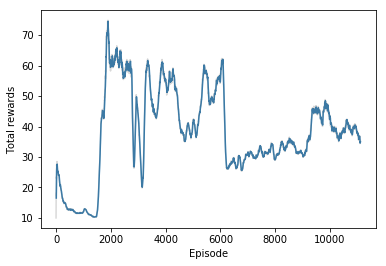

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

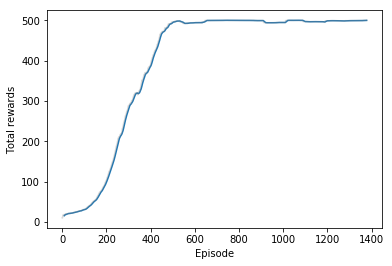

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

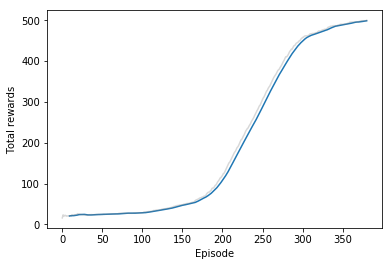

In [59]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

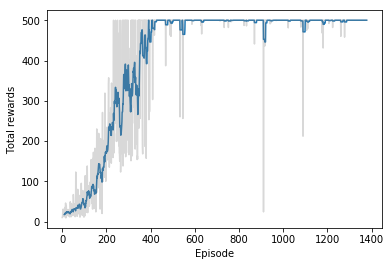

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

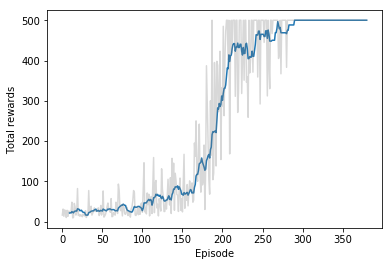

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.